In [11]:
import cell2location as c2l
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import anndata as ad
import os
import json
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scikit_posthocs import posthoc_dunn
from kneed import KneeLocator
from collections import defaultdict
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import ace_tools_open as tools
from tqdm import tqdm
from sklearn.neighbors import KDTree
from scipy.stats import kruskal
import scikit_posthocs as sp
from scipy.stats import mannwhitneyu
import itertools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats
import statsmodels.api as sm
import matplotlib.ticker as ticker
from scipy.sparse import issparse
from sklearn.feature_selection import mutual_info_classif
import json
import sys
import shap
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils.validation import check_is_fitted
from itertools import combinations

✅ AnnData object loaded successfully.
✅ Calculated average cell diameter: 65.70 µm
✅ Calculated standard deviation: 15.23 µm
✅ Recommended distance threshold for neighborhood analysis: 65.70 µm
✅ Percentage of cells within 1 SD: 69.47%
✅ Histogram with standard deviation and percentage text saved to /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/cell_diameter_histogram.png


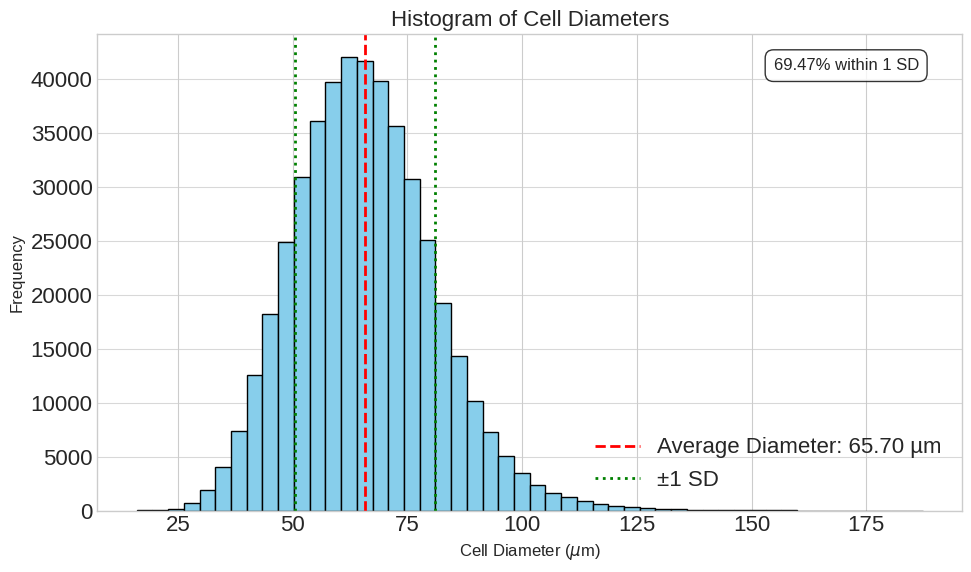

In [12]:
# --- 1. Load the new data ---
adata = sc.read(
    filename = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/CompleteCosMx_singlecellspatialresolution.h5ad"
)
print("✅ AnnData object loaded successfully.")

# --- 2. Calculate cell diameters from the 'Area' column ---
# The formula for the diameter of a circle is 2 * sqrt(Area / pi)
cell_diameters_um = 2 * np.sqrt(adata.obs['Area'] / np.pi)

# --- 3. Calculate key statistics ---
avg_cell_diameter_um = cell_diameters_um.mean()
std_cell_diameter_um = np.std(cell_diameters_um)
print(f"✅ Calculated average cell diameter: {avg_cell_diameter_um:.2f} µm")
print(f"✅ Calculated standard deviation: {std_cell_diameter_um:.2f} µm")

# --- 4. Determine the recommended distance threshold ---
# Recommended practice is often 1x or 2x the average cell diameter
distance_threshold = avg_cell_diameter_um * 1 
print(f"✅ Recommended distance threshold for neighborhood analysis: {distance_threshold:.2f} µm")

# --- 5. Calculate percentage of cells within 1 standard deviation ---
lower_bound_sd = avg_cell_diameter_um - std_cell_diameter_um
upper_bound_sd = avg_cell_diameter_um + std_cell_diameter_um

within_sd_count = np.sum((cell_diameters_um >= lower_bound_sd) & (cell_diameters_um <= upper_bound_sd))
total_count = len(cell_diameters_um)
percent_within_sd = (within_sd_count / total_count) * 100
print(f"✅ Percentage of cells within 1 SD: {percent_within_sd:.2f}%")

# --- 6. Plot the histogram ---
plt.figure(figsize=(10, 6))
plt.hist(cell_diameters_um, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Cell Diameters', fontsize=16)
plt.xlabel('Cell Diameter ($\mu$m)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)

# Add line for the average diameter
plt.axvline(avg_cell_diameter_um, color='red', linestyle='dashed', linewidth=2, label=f'Average Diameter: {avg_cell_diameter_um:.2f} µm')

# Add lines for one standard deviation
plt.axvline(lower_bound_sd, color='green', linestyle='dotted', linewidth=2, label=f'±1 SD')
plt.axvline(upper_bound_sd, color='green', linestyle='dotted', linewidth=2)

# Add text annotation with the percentage
plt.text(0.95, 0.95, f'{percent_within_sd:.2f}% within 1 SD',
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

plt.legend()
plt.tight_layout()

# Save the figure to the specified output directory
output_dir = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis'
plt.savefig(f'{output_dir}/cell_diameter_histogram.png')

print(f"✅ Histogram with standard deviation and percentage text saved to {output_dir}/cell_diameter_histogram.png")

In [22]:
# Check if 'PredictedCellType' exists in the metadata
if 'PredictedCellType' in adata.obs.columns:
    # Get unique values
    unique_values = adata.obs['PredictedCellType'].unique()
    print(f"Number of unique PredictedCellType values: {len(unique_values)}")
    print("Unique PredictedCellType values:")
    for val in unique_values:
        print(f"- {val}")
else:
    print("'PredictedCellType' column not found in adata.obs")

Number of unique PredictedCellType values: 54
Unique PredictedCellType values:
- N2
- NK
- MT T cells
- Eosinophils
- Cycling T cells
- CD4
- Inflammatory fibroblasts
- M0
- Glia
- Tuft cells
- N3
- FRCs
- Tregs
- DN
- Ribhi T cells
- Cycling myeloid
- Mast
- ILC4
- CD8
- Endothelium
- Memory B cell
- N1
- S2b
- M2
- BEST4 OTOP2
- PC IgG
- Secretory progenitor
- Epithelium Ribhi
- T cells CCL20
- Cycling TA
- Naïve B cell
- Cycling cells
- PC IgA
- Paneth-like
- gd IEL
- MAIT
- Goblet
- PC IgA heat shock
- Enteroendocrine
- Colonocytes
- B cell
- GC B cell
- PC IgA IgM
- Myofibroblasts
- Pericytes
- IDA macrophage
- DCs
- M1
- Inflammatory monocytes
- S3
- S2a
- S1
- Fibroblasts
- PC  immediate early response


In [23]:
# File paths
scrna_file = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/scRNA/combined_10x_reference_final.h5ad"
cosmx_file = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_combined.h5ad"

# Load the datasets
adata_scrna = sc.read_h5ad(scrna_file)
adata_cosmx = sc.read_h5ad(cosmx_file)

# Extract gene names
genes_scrna = set(adata_scrna.var_names)
genes_cosmx = set(adata_cosmx.var_names)

# Find common genes
common_genes = genes_scrna.intersection(genes_cosmx)

# Print results
print(f"Number of genes in scRNA dataset: {len(genes_scrna)}")
print(f"Number of genes in CosMx dataset: {len(genes_cosmx)}")
print(f"Number of common/shared genes: {len(common_genes)}\n")

# Optional: list some shared genes
print("Example shared genes:")
for gene in list(common_genes)[:20]:
    print(f"- {gene}")

Number of genes in scRNA dataset: 33538
Number of genes in CosMx dataset: 980
Number of common/shared genes: 976

Example shared genes:
- FFAR2
- CEACAM1
- FGF18
- TOX
- SELPLG
- ACE
- COL17A1
- CCL19
- CD40LG
- CD47
- IL2RB
- CD3D
- NKG7
- EFNB3
- PDGFA
- CD276
- RPL21
- RBPJ
- SPRY2
- CHEK1


In [13]:
adata

AnnData object with n_obs × n_vars = 459095 × 980
    obs: 'cell_id', 'patient', 'subset', 'unique_cell_id', 'PredictedCellType', 'NMF_factor', 'fov', 'cell_ID', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI'

In [14]:
unique_patients = adata.obs['patient'].unique()
unique_patients

['CD c', 'CD b', 'CD a', 'HC c', 'HC b', 'HC a', 'UC a', 'UC b', 'UC c']
Categories (9, object): ['CD a', 'CD b', 'CD c', 'HC a', ..., 'HC c', 'UC a', 'UC b', 'UC c']

In [15]:
unique_cell_id = adata.obs['unique_cell_id'].unique()
unique_cell_id

array(['CD c_1_1', 'CD c_1_2', 'CD c_1_3', ..., 'UC c_21_2247',
       'UC c_21_2248', 'UC c_21_2249'], dtype=object)

In [16]:
# --- Load data ---
adata = ad.read_h5ad("/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/CompleteCosMx_singlecellspatialresolution.h5ad")

# --- Parse unique_cell_id correctly ---
def parse_unique_id(uid):
    # Example: "UC c_21_2249"
    first_space = uid.find(" ")
    disease = uid[:first_space]                # "UC"
    rest = uid[first_space+1:]                 # "c_21_2249"
    
    ffpe = uid[:uid.find("_")]                 # "UC c"
    fov = "_".join(uid.split("_")[:2])         # "UC c_21"
    
    return disease, ffpe, fov

# Apply parsing
parsed = adata.obs["unique_cell_id"].map(parse_unique_id)
adata.obs[["Disease", "FFPE", "FOV"]] = pd.DataFrame(parsed.tolist(), index=adata.obs.index)

# --- Summarize ---
summary = (
    adata.obs
    .groupby(["Disease", "FFPE"])
    .agg(
        Number_of_FOVs=("FOV", "nunique"),
        Number_of_Cells=("unique_cell_id", "count")
    )
    .reset_index()
)

# --- Print tree ---
tot_fov = summary["Number_of_FOVs"].sum()
tot_cells = summary["Number_of_Cells"].sum()

for disease, df_disease in summary.groupby("Disease"):
    print(f"{disease}")
    for _, row in df_disease.iterrows():
        print(f"  └─ {row['FFPE']}: {row['Number_of_FOVs']} FOVs, {row['Number_of_Cells']} cells")

print()
print(f"TOTAL: {summary['Disease'].nunique()} Diseases, "
      f"{summary['FFPE'].nunique()} FFPE samples, "
      f"{tot_fov} FOVs, {tot_cells} Cells")

CD
  └─ CD a: 19 FOVs, 31582 cells
  └─ CD b: 19 FOVs, 72440 cells
  └─ CD c: 16 FOVs, 53344 cells
HC
  └─ HC a: 19 FOVs, 39101 cells
  └─ HC b: 20 FOVs, 54059 cells
  └─ HC c: 16 FOVs, 27905 cells
UC
  └─ UC a: 19 FOVs, 49240 cells
  └─ UC b: 22 FOVs, 76613 cells
  └─ UC c: 21 FOVs, 54811 cells

TOTAL: 3 Diseases, 9 FFPE samples, 171 FOVs, 459095 Cells


### Want to determine which cellular niches (defined by our NMF factors) are spatially attracted to or repelled by each other in the tissue.

#### Using dynamic distance thresholds.

Loading data...
✅ AnnData object loaded successfully.
Found 4 NMF factors: [1, 2, 3, 4]

Processing 171 Fields of View (FOVs)...


171it [05:28,  1.92s/it]



✅ Final enrichment scores calculated.

✅ Heatmap with values saved to /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/niche_enrichment_heatmap_with_values_IndividualDiameters.png


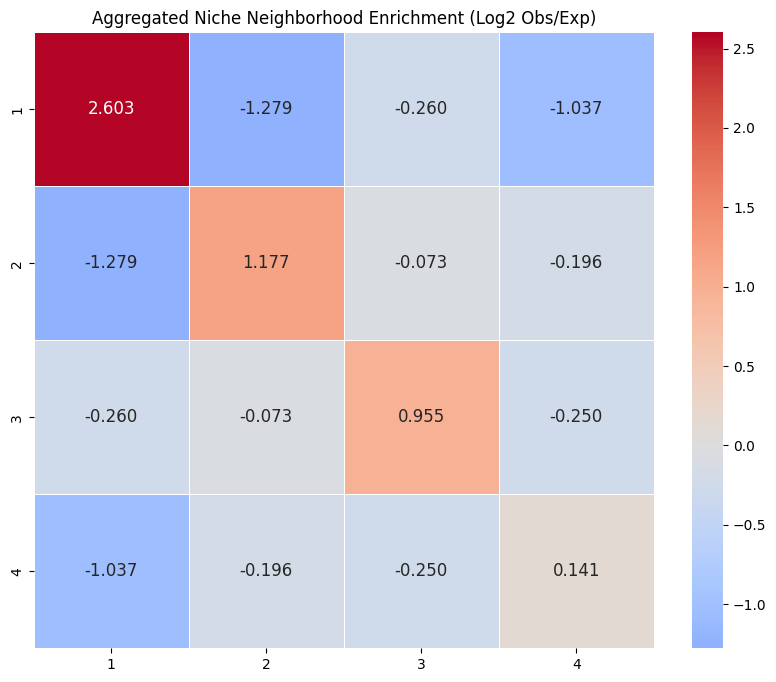

In [16]:
# --- 1. Setup and Parameters ---
# File paths
h5ad_file_path = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/CompleteCosMx_singlecellspatialresolution.h5ad"
output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
output_filename = "niche_enrichment_heatmap_with_values_IndividualDiameters.png"

# Load the AnnData object
print("Loading data...")
try:
    adata = sc.read(filename=h5ad_file_path)
    print("✅ AnnData object loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {h5ad_file_path}")
    exit()

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get the list of unique NMF factors
factor_names = sorted(adata.obs['NMF_factor'].unique())
print(f"Found {len(factor_names)} NMF factors: {factor_names}")

# Prepare the data needed for the analysis
# Use the global coordinates
coords_um = adata.obs[['CenterX_global_px', 'CenterY_global_px']].values
# Use the NMF factor as the niche label
nmf_labels = adata.obs['NMF_factor']
# Calculate cell diameters from the 'Area' column
cell_diameters_um = 2 * np.sqrt(adata.obs['Area'] / np.pi)

# --- CORRECTED: Create the true FOV identifier using the 'patient' and 'fov' columns ---
adata.obs['true_fov'] = adata.obs['patient'].astype(str) + '_' + adata.obs['fov'].astype(str)

# --- 2. Per-Cell Dynamic Neighborhood Analysis ---
fov_interaction_matrices = []
print(f"\nProcessing {adata.obs['true_fov'].nunique()} Fields of View (FOVs)...")

fov_groups = adata.obs.reset_index().groupby('true_fov')['index'].apply(list)

# Use tqdm to show a progress bar
for fov_id, cell_indices in tqdm(fov_groups.items()):
    # Subset data for the current FOV
    fov_coords = coords_um[adata.obs.index.isin(cell_indices)]
    fov_labels = nmf_labels.loc[cell_indices].reset_index(drop=True)
    fov_cell_diameters = cell_diameters_um.loc[cell_indices].reset_index(drop=True)
    
    if len(fov_coords) < 2:
        continue

    # Find neighbors using a KDTree for efficiency
    tree = KDTree(fov_coords)
    
    # Initialize the interaction matrix for this FOV
    interaction_matrix = pd.DataFrame(0, index=factor_names, columns=factor_names)

    # Loop through each cell individually to use its unique radius
    for i in range(len(fov_coords)):
        # Calculate the dynamic distance threshold for this specific cell (2x diameter)
        per_cell_threshold = 2 * fov_cell_diameters[i]
        
        # Query for neighbors of this cell using its specific threshold
        neighbor_indices_list = tree.query_radius([fov_coords[i]], r=per_cell_threshold)
        
        # Extract the array of neighbor indices
        neighbor_indices = neighbor_indices_list[0]
        neighbor_indices = neighbor_indices[neighbor_indices != i] # Exclude self-interaction

        if len(neighbor_indices) > 0:
            factor_i = fov_labels.iloc[i]
            factors_j = fov_labels.iloc[neighbor_indices]
            counts = factors_j.value_counts()
            
            for factor, count in counts.items():
                interaction_matrix.loc[factor_i, factor] += count
    
    fov_interaction_matrices.append(interaction_matrix)

# --- 3. Aggregate and Calculate Final Enrichment ---
if not fov_interaction_matrices:
    print("❌ No interactions found. Check your distance threshold or data.")
else:
    # Sum matrices and calculate enrichment
    total_interaction_matrix = sum(fov_interaction_matrices)
    # Make the matrix symmetric
    total_interaction_matrix = total_interaction_matrix + total_interaction_matrix.T
    
    niche_proportions = nmf_labels.value_counts(normalize=True)
    total_interactions = total_interaction_matrix.sum().sum()
    expected_matrix = total_interactions * np.outer(niche_proportions.loc[factor_names], niche_proportions.loc[factor_names])
    expected_matrix = pd.DataFrame(expected_matrix, index=factor_names, columns=factor_names)
    
    enrichment = np.log2((total_interaction_matrix + 1) / (expected_matrix + 1))
    print("\n✅ Final enrichment scores calculated.")
    
    # --- 4. Visualize and Save Results ---
    # Plot the heatmap with values
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        enrichment,
        cmap='coolwarm',
        center=0,
        annot=True,
        fmt=".3f",
        linewidths=.5,
        annot_kws={"size": 12}
    )
    plt.title("Aggregated Niche Neighborhood Enrichment (Log2 Obs/Exp)")
    
    # Save the figure
    save_path = f"{output_dir}/{output_filename}"
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    
    print(f"\n✅ Heatmap with values saved to {save_path}")

#### Performing the analysis for each disease state

Loading data...
✅ AnnData object loaded successfully.

Analyzing Disease Group: CD


Processing FOVs for CD: 54it [03:18,  3.67s/it]



✅ Final enrichment scores calculated.


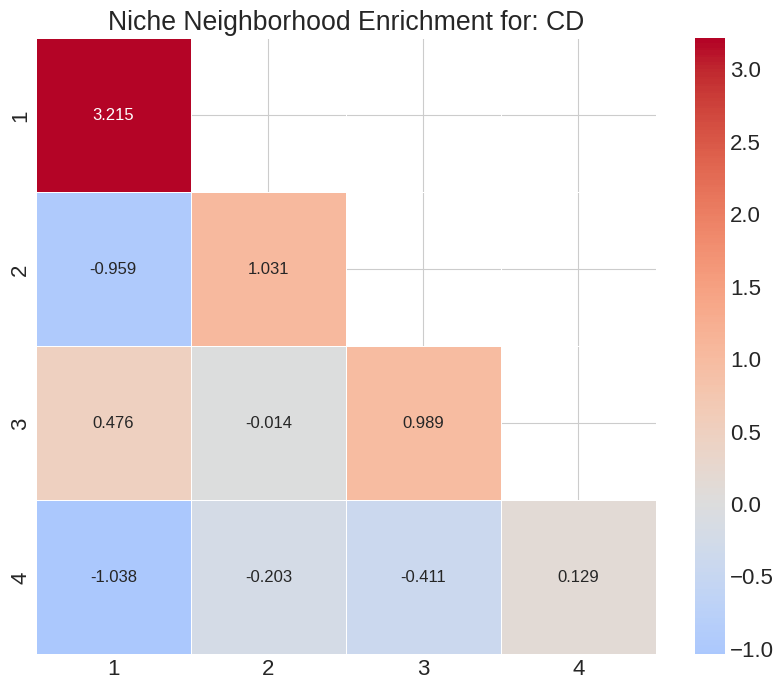


Analyzing Disease Group: HC


Processing FOVs for HC: 55it [02:09,  2.35s/it]



✅ Final enrichment scores calculated.


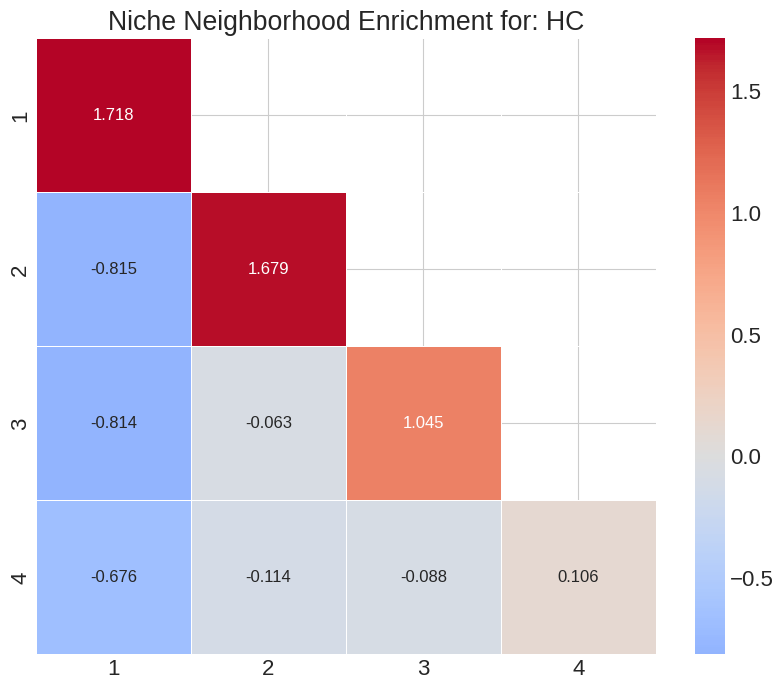


Analyzing Disease Group: UC


Processing FOVs for UC: 62it [03:31,  3.41s/it]



✅ Final enrichment scores calculated.


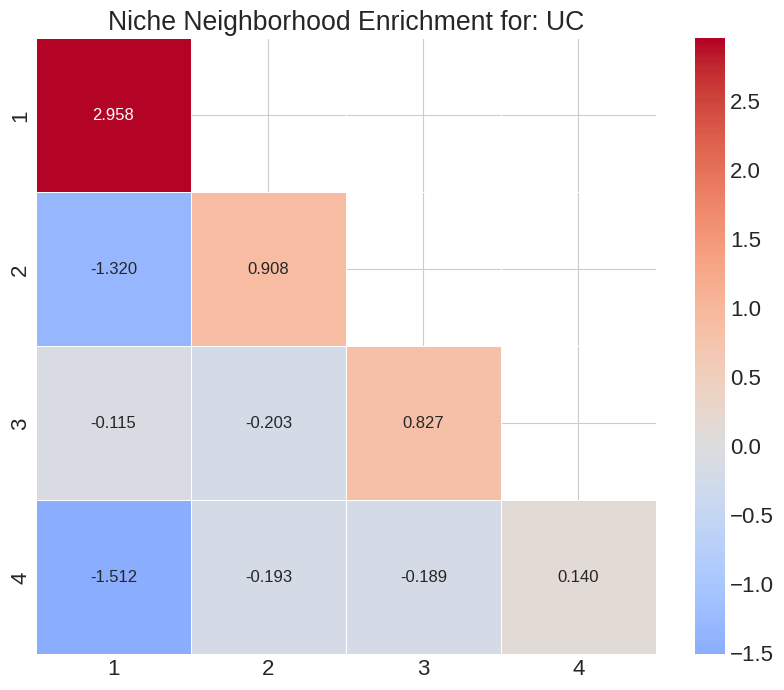


✅ Heatmap generation complete.


In [17]:
# --- 1. Setup and Parameters ---
# File paths
h5ad_file_path = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/CompleteCosMx_singlecellspatialresolution.h5ad"
output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"

# Load the AnnData object
print("Loading data...")
try:
    adata = sc.read(filename=h5ad_file_path)
    print("✅ AnnData object loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {h5ad_file_path}")
    exit()

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Create the 'Disease_State' column from the 'patient' column
adata.obs['Disease_State'] = adata.obs['patient'].astype(str).str[:2]

# --- NEW: Create a truly unique FOV identifier for the whole dataset ---
adata.obs['unique_fov'] = adata.obs['patient'].astype(str) + '_' + adata.obs['fov'].astype(str)

# Prepare the data needed for the analysis
coords_um = adata.obs[['CenterX_global_px', 'CenterY_global_px']].values.astype('float64')
nmf_labels = adata.obs['NMF_factor']
cell_diameters_um = 2 * np.sqrt(adata.obs['Area'] / np.pi)

# Get the unique disease states and all unique factor names
disease_groups = adata.obs['Disease_State'].unique()
all_factor_names = sorted(adata.obs['NMF_factor'].unique())

# --- 2. Loop Through Each Disease Group ---
for disease in disease_groups:
    print(f"\n{'='*20}\nAnalyzing Disease Group: {disease}\n{'='*20}")

    # Subset the data for the current disease group
    adata_subset = adata[adata.obs['Disease_State'] == disease].copy()
    coords_um_subset = adata_subset.obs[['CenterX_global_px', 'CenterY_global_px']].values.astype('float64')
    nmf_labels_subset = adata_subset.obs['NMF_factor']
    cell_diameters_subset = cell_diameters_um.loc[adata_subset.obs.index]

    # Group by FOV and Analyze
    fov_interaction_matrices = []
    
    # --- CORRECTED: Group by the new 'unique_fov' column ---
    fov_groups = adata_subset.obs.reset_index().groupby('unique_fov')['index'].apply(list)
    
    # Use tqdm to show a progress bar
    for fov_id, cell_indices in tqdm(fov_groups.items(), desc=f"Processing FOVs for {disease}"):
        original_indices = adata_subset.obs.index.get_indexer(cell_indices)
        fov_coords = coords_um_subset[original_indices]
        fov_cell_diameters = cell_diameters_subset.loc[cell_indices].values

        if len(fov_coords) < 2:
            continue

        tree = KDTree(fov_coords)
        
        interaction_matrix = pd.DataFrame(0, index=all_factor_names, columns=all_factor_names)

        for i in range(len(fov_coords)):
            per_cell_threshold = 2 * fov_cell_diameters[i]
            neighbor_indices_list = tree.query_radius([fov_coords[i]], r=per_cell_threshold)
            neighbor_indices = neighbor_indices_list[0]
            neighbor_indices = neighbor_indices[neighbor_indices != i]

            if len(neighbor_indices) > 0:
                factor_i = nmf_labels_subset.loc[cell_indices[i]]
                factors_j = nmf_labels_subset.loc[np.array(cell_indices)[neighbor_indices]]
                counts = factors_j.value_counts()
                
                for factor, count in counts.items():
                    interaction_matrix.loc[factor_i, factor] += count

        fov_interaction_matrices.append(interaction_matrix)

    if not fov_interaction_matrices:
        print(f"⚠️ No interactions found for '{disease}'. Skipping.")
        continue

    total_interaction_matrix = sum(fov_interaction_matrices)
    total_interaction_matrix = total_interaction_matrix + total_interaction_matrix.T
    niche_proportions = nmf_labels_subset.value_counts(normalize=True).reindex(all_factor_names, fill_value=0)
    total_interactions = total_interaction_matrix.sum().sum()
    expected_matrix = total_interactions * np.outer(niche_proportions, niche_proportions)
    expected_matrix = pd.DataFrame(expected_matrix, index=all_factor_names, columns=all_factor_names)
    enrichment = np.log2((total_interaction_matrix + 1) / (expected_matrix + 1))
    print("\n✅ Final enrichment scores calculated.")

    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(enrichment, dtype=bool), k=1)
    sns.heatmap(
        enrichment,
        mask=mask,
        cmap='coolwarm',
        center=0,
        annot=True,
        fmt=".3f",
        linewidths=.5,
        annot_kws={"size": 12}
    )
    plt.title(f"Niche Neighborhood Enrichment for: {disease}")
    save_path = f"{output_dir}/Niche_Enrichment_Dynamic_{disease}.png"
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

print("\n✅ Heatmap generation complete.")

In [21]:
# --- 1. Setup paths ---
h5ad_file_path = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/CompleteCosMx_singlecellspatialresolution.h5ad"
output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
analysis_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Analysis"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(analysis_dir, exist_ok=True)

# --- 2. Load data ---
print("Loading data...")
adata = sc.read(filename=h5ad_file_path)
print("✅ AnnData object loaded successfully.")

# Create 'Disease_State' column
adata.obs['Disease_State'] = adata.obs['patient'].astype(str).str[:2]

# Create unique FOV identifier
adata.obs['unique_fov'] = adata.obs['patient'].astype(str) + '_' + adata.obs['fov'].astype(str)

# Extract needed data
coords_um = adata.obs[['CenterX_global_px', 'CenterY_global_px']].values.astype('float64')
nmf_labels = adata.obs['NMF_factor']
cell_diameters_um = 2 * np.sqrt(adata.obs['Area'] / np.pi)

# Define groups
disease_groups = ["HC", "UC", "CD"]
all_factor_names = sorted(adata.obs['NMF_factor'].unique())
print("Detected niche labels:", all_factor_names)

# --- 3. Compute enrichment per FOV ---
per_fov_data = []  # to store enrichment results for every FOV

for disease in disease_groups:
    print(f"\n{'='*20}\nAnalyzing Disease Group: {disease}\n{'='*20}")

    # Subset by disease
    adata_subset = adata[adata.obs['Disease_State'] == disease].copy()
    coords_um_subset = adata_subset.obs[['CenterX_global_px', 'CenterY_global_px']].values.astype('float64')
    nmf_labels_subset = adata_subset.obs['NMF_factor']
    cell_diameters_subset = cell_diameters_um.loc[adata_subset.obs.index]

    # Group by FOV
    fov_groups = adata_subset.obs.reset_index().groupby('unique_fov')['index'].apply(list)

    for fov_id, cell_indices in tqdm(fov_groups.items(), desc=f"Processing FOVs for {disease}"):
        original_indices = adata_subset.obs.index.get_indexer(cell_indices)
        fov_coords = coords_um_subset[original_indices]
        fov_cell_diameters = cell_diameters_subset.loc[cell_indices].values

        if len(fov_coords) < 2:
            continue  # Skip if too few cells

        # Build spatial tree
        tree = KDTree(fov_coords)

        # Initialize matrix for this FOV
        interaction_matrix = pd.DataFrame(0, index=all_factor_names, columns=all_factor_names)

        # Compute interactions for this FOV
        for i in range(len(fov_coords)):
            per_cell_threshold = 2 * fov_cell_diameters[i]
            neighbor_indices_list = tree.query_radius([fov_coords[i]], r=per_cell_threshold)
            neighbor_indices = neighbor_indices_list[0]
            neighbor_indices = neighbor_indices[neighbor_indices != i]

            if len(neighbor_indices) > 0:
                factor_i = nmf_labels_subset.loc[cell_indices[i]]
                factors_j = nmf_labels_subset.loc[np.array(cell_indices)[neighbor_indices]]
                counts = factors_j.value_counts()
                for factor, count in counts.items():
                    interaction_matrix.loc[factor_i, factor] += count

        # Expected matrix for this FOV
        niche_proportions = nmf_labels_subset.value_counts(normalize=True).reindex(all_factor_names, fill_value=0)
        total_interactions = interaction_matrix.sum().sum()
        expected_matrix = total_interactions * np.outer(niche_proportions, niche_proportions)
        expected_matrix = pd.DataFrame(expected_matrix, index=all_factor_names, columns=all_factor_names)

        # Calculate enrichment
        enrichment_matrix = np.log2((interaction_matrix + 1) / (expected_matrix + 1))

        # Store results in a long format
        for ni in all_factor_names:
            for nj in all_factor_names:
                per_fov_data.append({
                    "FOV": fov_id,
                    "Disease_State": disease,
                    "Interaction": f"{ni} vs {nj}",
                    "Enrichment": enrichment_matrix.loc[ni, nj]
                })

# Convert to DataFrame
per_fov_df = pd.DataFrame(per_fov_data)
print("\n✅ Per-FOV enrichment data prepared.")
print(per_fov_df.head())

# --- 4. Global Kruskal-Wallis and pairwise post-hoc Mann-Whitney ---
comparisons = list(combinations(disease_groups, 2))  # [('HC', 'UC'), ('HC', 'CD'), ('UC', 'CD')]
kruskal_results = []
pairwise_results = []

for interaction in per_fov_df['Interaction'].unique():
    subset = per_fov_df[per_fov_df['Interaction'] == interaction]

    # Get distributions for each group
    group_vals = {
        disease: subset[subset['Disease_State'] == disease]['Enrichment'].values
        for disease in disease_groups
    }

    # Skip if any group doesn't have enough data
    if any(len(vals) < 2 for vals in group_vals.values()):
        continue

    # --- Global Kruskal-Wallis test ---
    stat, p_value = kruskal(*group_vals.values())

    kruskal_results.append({
        "Interaction": interaction,
        "Test": "Kruskal-Wallis",
        "H_statistic": stat,
        "Raw_p_value": p_value
    })

    # --- If global test significant, do pairwise Mann-Whitney ---
    if p_value < 0.05:
        for group1, group2 in comparisons:
            vals1 = group_vals[group1]
            vals2 = group_vals[group2]

            if len(vals1) < 2 or len(vals2) < 2:
                continue

            mw_stat, mw_p = mannwhitneyu(vals1, vals2, alternative='two-sided')

            direction = "Equal"
            if np.mean(vals1) > np.mean(vals2):
                direction = "Up"
            elif np.mean(vals1) < np.mean(vals2):
                direction = "Down"

            pairwise_results.append({
                "Interaction": interaction,
                "Group 1": group1,
                "Group 2": group2,
                "Direction": direction,
                "Raw_p_value": mw_p,
                "Mean_Group1": np.mean(vals1),
                "Mean_Group2": np.mean(vals2),
                "N_Group1": len(vals1),
                "N_Group2": len(vals2)
            })

# --- 5. Adjust p-values ---
kruskal_df = pd.DataFrame(kruskal_results)
if not kruskal_df.empty:
    reject, p_adj, _, _ = multipletests(kruskal_df["Raw_p_value"], method='fdr_bh', alpha=0.05)
    kruskal_df["Adjusted_p_value"] = p_adj
    kruskal_df["Significant"] = np.where(reject, "Yes", "No")

pairwise_df = pd.DataFrame(pairwise_results)
if not pairwise_df.empty:
    reject, p_adj, _, _ = multipletests(pairwise_df["Raw_p_value"], method='fdr_bh', alpha=0.05)
    pairwise_df["Adjusted_p_value"] = p_adj
    pairwise_df["Significant"] = np.where(reject, "Yes", "No")

# --- 6. Save outputs ---
kruskal_path = os.path.join(analysis_dir, "kruskal_wallis_results.csv")
pairwise_path = os.path.join(analysis_dir, "pairwise_mannwhitney_results.csv")

kruskal_df.to_csv(kruskal_path, index=False)
pairwise_df.to_csv(pairwise_path, index=False)

print(f"\n✅ Global Kruskal-Wallis results saved to: {kruskal_path}")
print(f"✅ Pairwise Mann-Whitney results saved to: {pairwise_path}")

Loading data...
✅ AnnData object loaded successfully.
Detected niche labels: [1, 2, 3, 4]

Analyzing Disease Group: HC


Processing FOVs for HC: 55it [02:23,  2.61s/it]



Analyzing Disease Group: UC


Processing FOVs for UC: 62it [03:45,  3.63s/it]



Analyzing Disease Group: CD


Processing FOVs for CD: 54it [03:14,  3.60s/it]


✅ Per-FOV enrichment data prepared.
      FOV Disease_State Interaction  Enrichment
0  HC a_1            HC      1 vs 1   -0.311520
1  HC a_1            HC      1 vs 2   -1.237430
2  HC a_1            HC      1 vs 3   -0.602151
3  HC a_1            HC      1 vs 4   -1.167627
4  HC a_1            HC      2 vs 1   -2.311431

✅ Global Kruskal-Wallis results saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Analysis/kruskal_wallis_results.csv
✅ Pairwise Mann-Whitney results saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Analysis/pairwise_mannwhitney_results.csv


In [11]:
# --- 1. Setup and Parameters ---

# File paths
h5ad_file_path = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/CompleteCosMx_singlecellspatialresolution.h5ad"
output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
os.makedirs(output_dir, exist_ok=True)

# Load AnnData
adata = sc.read(filename=h5ad_file_path)

# Create disease state and unique FOV
adata.obs['Disease_State'] = adata.obs['patient'].astype(str).str[:2]
adata.obs['unique_fov'] = adata.obs['patient'].astype(str) + '_' + adata.obs['fov'].astype(str)

coords_um = adata.obs[['CenterX_global_px', 'CenterY_global_px']].values.astype('float64')
nmf_labels = adata.obs['NMF_factor']
cell_diameters_um = 2 * np.sqrt(adata.obs['Area'] / np.pi)

disease_groups = adata.obs['Disease_State'].unique()
all_factor_names = sorted(adata.obs['NMF_factor'].unique())

# Save enrichment matrices
enrichment_results = {}

for disease in disease_groups:
    print(f"\n=== Analyzing {disease} ===")

    adata_subset = adata[adata.obs['Disease_State'] == disease].copy()
    coords_um_subset = adata_subset.obs[['CenterX_global_px', 'CenterY_global_px']].values.astype('float64')
    nmf_labels_subset = adata_subset.obs['NMF_factor']
    cell_diameters_subset = cell_diameters_um.loc[adata_subset.obs.index]

    fov_interaction_matrices = []
    fov_groups = adata_subset.obs.reset_index().groupby('unique_fov')['index'].apply(list)

    for fov_id, cell_indices in tqdm(fov_groups.items(), desc=f"Processing FOVs for {disease}"):
        original_indices = adata_subset.obs.index.get_indexer(cell_indices)
        fov_coords = coords_um_subset[original_indices]
        fov_cell_diameters = cell_diameters_subset.loc[cell_indices].values

        if len(fov_coords) < 2:
            continue

        tree = KDTree(fov_coords)
        interaction_matrix = pd.DataFrame(0, index=all_factor_names, columns=all_factor_names)

        for i in range(len(fov_coords)):
            per_cell_threshold = 2 * fov_cell_diameters[i]
            neighbor_indices = tree.query_radius([fov_coords[i]], r=per_cell_threshold)[0]
            neighbor_indices = neighbor_indices[neighbor_indices != i]

            if len(neighbor_indices) > 0:
                factor_i = nmf_labels_subset.loc[cell_indices[i]]
                factors_j = nmf_labels_subset.loc[np.array(cell_indices)[neighbor_indices]]
                counts = factors_j.value_counts()
                for factor, count in counts.items():
                    interaction_matrix.loc[factor_i, factor] += count

        fov_interaction_matrices.append(interaction_matrix)

    if not fov_interaction_matrices:
        continue

    total_interaction_matrix = sum(fov_interaction_matrices)
    total_interaction_matrix = total_interaction_matrix + total_interaction_matrix.T
    niche_proportions = nmf_labels_subset.value_counts(normalize=True).reindex(all_factor_names, fill_value=0)
    total_interactions = total_interaction_matrix.sum().sum()
    expected_matrix = total_interactions * np.outer(niche_proportions, niche_proportions)
    expected_matrix = pd.DataFrame(expected_matrix, index=all_factor_names, columns=all_factor_names)
    enrichment = np.log2((total_interaction_matrix + 1) / (expected_matrix + 1))

    enrichment_results[disease] = enrichment

# --- Save enrichment matrices as CSV ---
for disease, enrichment in enrichment_results.items():
    save_path = os.path.join(output_dir, f"enrichment_{disease}.csv")
    enrichment.to_csv(save_path)
    print(f"✅ Saved enrichment matrix for {disease} -> {save_path}")

print("✅ Enrichment matrices saved.")


=== Analyzing CD ===


Processing FOVs for CD: 54it [03:50,  4.27s/it]



=== Analyzing HC ===


Processing FOVs for HC: 55it [02:41,  2.95s/it]



=== Analyzing UC ===


Processing FOVs for UC: 62it [04:22,  4.23s/it]

✅ Saved enrichment matrix for CD -> /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/enrichment_CD.csv
✅ Saved enrichment matrix for HC -> /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/enrichment_HC.csv
✅ Saved enrichment matrix for UC -> /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/enrichment_UC.csv
✅ Enrichment matrices saved.


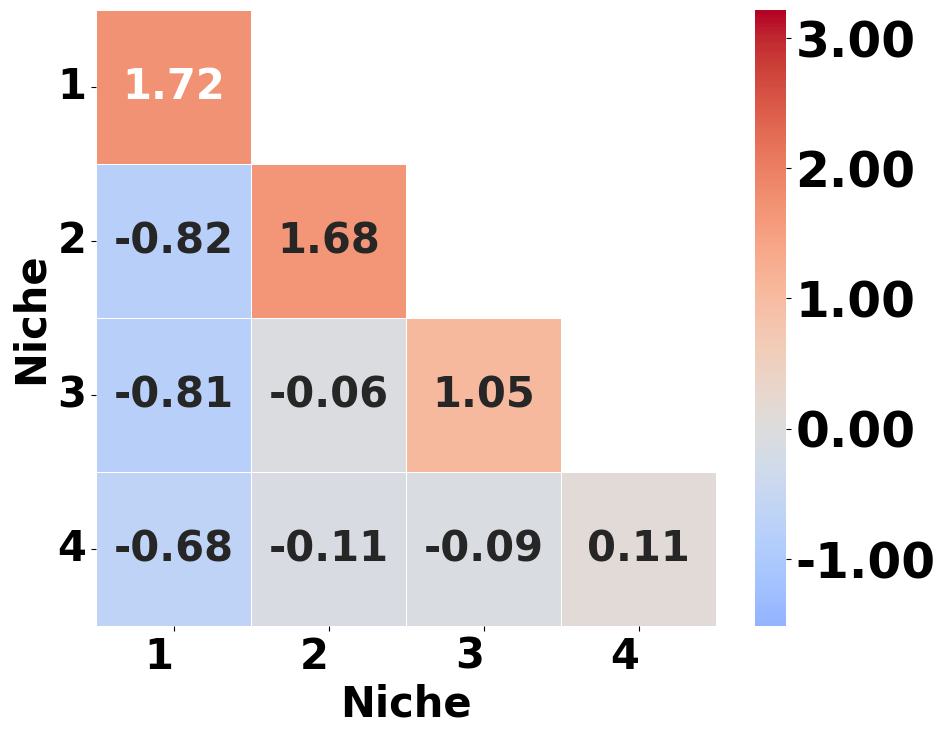

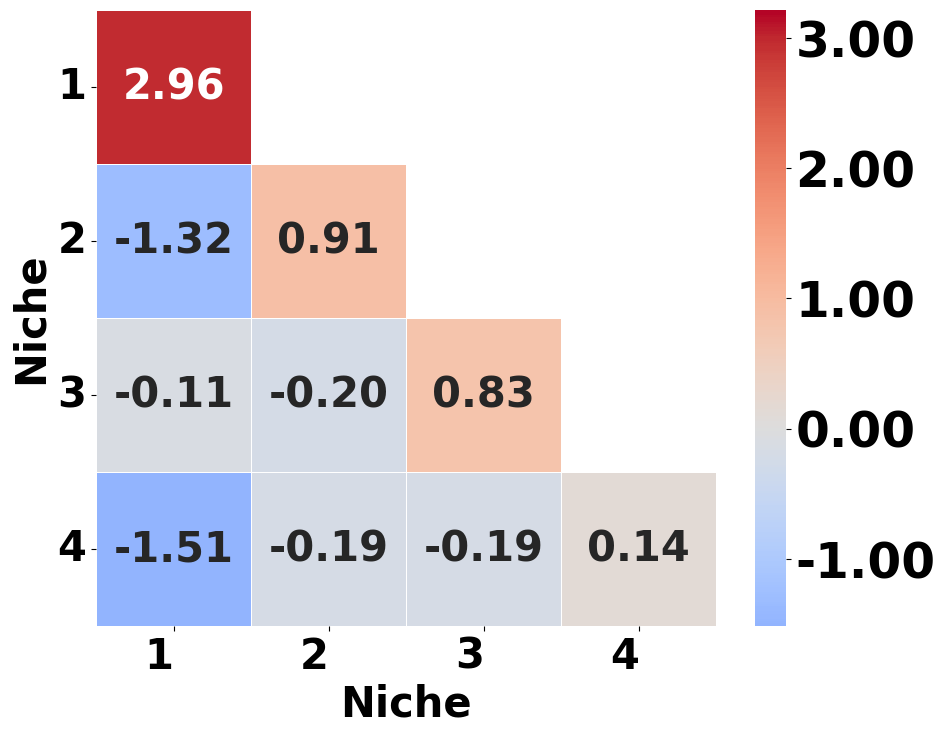

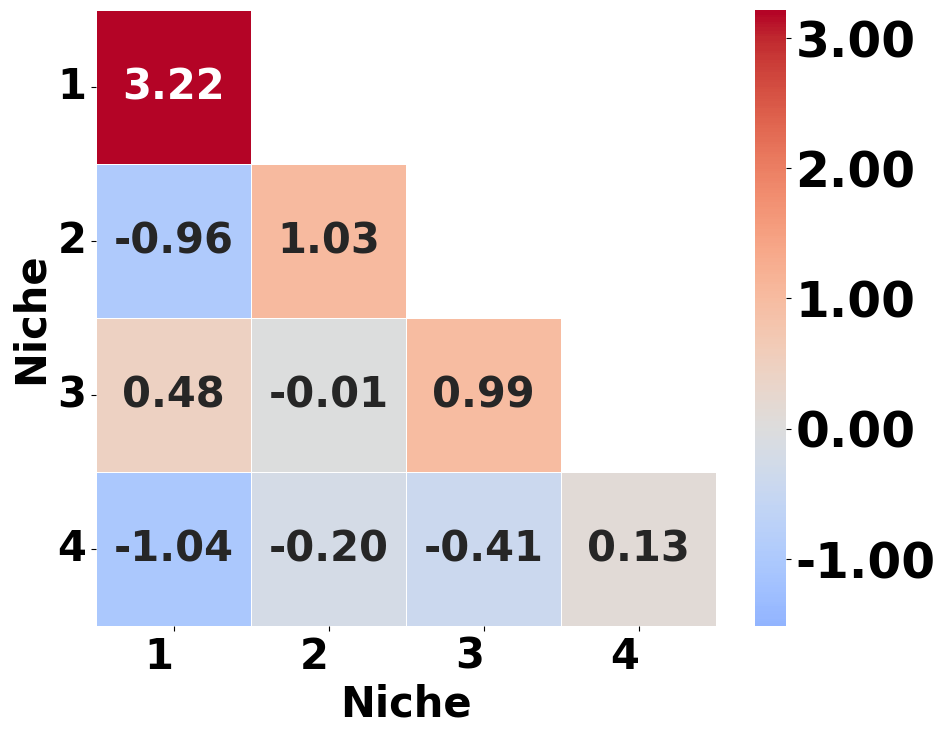

✅ Heatmaps generated from CSVs with uniform scales and font sizes.


In [27]:
output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"

# Disease label mapping
disease_labels = {
    "HC": "Healthy Controls",
    "UC": "Ulcerative Colitis",
    "CD": "Crohn's Disease"
}

# Load enrichment matrices from CSV
enrichment_results = {}
for disease in ["HC", "UC", "CD"]:
    csv_path = os.path.join(output_dir, f"enrichment_{disease}.csv")
    if os.path.exists(csv_path):
        enrichment_results[disease] = pd.read_csv(csv_path, index_col=0)

# --- Uniform scale across all diseases ---
all_values = np.concatenate([mat.values.flatten() for mat in enrichment_results.values()])
vmin, vmax = np.min(all_values), np.max(all_values)

# --- Plot each disease heatmap ---
for disease, enrichment in enrichment_results.items():
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(enrichment, dtype=bool), k=1)

    ax = sns.heatmap(
        enrichment,
        mask=mask,
        cmap='coolwarm',
        center=0,
        annot=True,
        fmt=".2f",
        linewidths=.5,
        annot_kws={"size": 30, "weight": "bold"},
        cbar_kws={"shrink": 1, "format": "%.2f"},
        vmin=vmin,
        vmax=vmax
    )
    
    # --- Adjust colorbar font size ---
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=35)   # adjust tick label font size
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight("bold")

    #plt.title(disease_labels.get(disease, disease), fontsize=25)
    plt.xticks(fontsize=30, rotation=0, ha="right", fontweight="bold")
    plt.yticks(fontsize=30, rotation=0, fontweight="bold")
    plt.xlabel("Niche", fontsize=30, fontweight="bold")
    plt.ylabel("Niche", fontsize=30, fontweight="bold")

    save_path = f"{output_dir}/Niche_Enrichment_{disease_labels.get(disease, disease).replace(' ', '')}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

print("✅ Heatmaps generated from CSVs with uniform scales and font sizes.")

#### Statistial Tests

In [20]:
# --- 1. Setup and Parameters ---
h5ad_file_path = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/CompleteCosMx_singlecellspatialresolution.h5ad"
output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"

print("Loading data...")
try:
    adata = sc.read(filename=h5ad_file_path)
    print("✅ AnnData object loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {h5ad_file_path}")
    exit()

os.makedirs(output_dir, exist_ok=True)

# Create the disease state column and a unique FOV identifier
adata.obs['Disease_State'] = adata.obs['patient'].astype(str).str[:2]
adata.obs['unique_fov'] = adata.obs['patient'].astype(str) + '_' + adata.obs['fov'].astype(str)

# Prepare data for analysis
coords_um = adata.obs[['CenterX_global_px', 'CenterY_global_px']].values.astype('float64')
nmf_labels = adata.obs['NMF_factor']
cell_diameters_um = 2 * np.sqrt(adata.obs['Area'] / np.pi)
all_factor_names = sorted(adata.obs['NMF_factor'].unique())
disease_groups = adata.obs['Disease_State'].unique()

# --- 2. Calculate FOV-Level Enrichment Scores ---
fov_results = []
print(f"\nProcessing {adata.obs['unique_fov'].nunique()} Fields of View (FOVs)...")
fov_groups = adata.obs.reset_index().groupby('unique_fov')['index'].apply(list)

for fov_id, cell_indices in tqdm(fov_groups.items()):
    fov_coords = coords_um[adata.obs.index.isin(cell_indices)]
    if len(fov_coords) < 2:
        continue

    tree = KDTree(fov_coords)
    nmf_labels_subset = nmf_labels.loc[cell_indices]
    cell_diameters_subset = cell_diameters_um.loc[cell_indices].values
    
    interaction_matrix = pd.DataFrame(0, index=all_factor_names, columns=all_factor_names)

    for i in range(len(fov_coords)):
        per_cell_threshold = 2 * cell_diameters_subset[i]
        neighbor_indices_list = tree.query_radius([fov_coords[i]], r=per_cell_threshold)
        neighbor_indices = neighbor_indices_list[0][neighbor_indices_list[0] != i]

        if len(neighbor_indices) > 0:
            factor_i = nmf_labels_subset.iloc[i]
            factors_j = nmf_labels_subset.iloc[neighbor_indices]
            counts = factors_j.value_counts()
            interaction_matrix.loc[factor_i, counts.index] += counts
    
    total_interaction_matrix = interaction_matrix + interaction_matrix.T
    niche_proportions = nmf_labels_subset.value_counts(normalize=True).reindex(all_factor_names, fill_value=0)
    total_interactions = total_interaction_matrix.sum().sum()
    if total_interactions == 0: continue
    
    expected_matrix = total_interactions * np.outer(niche_proportions, niche_proportions)
    enrichment_fov = np.log2((total_interaction_matrix + 1) / (expected_matrix + 1))
    
    enrichment_tidy = enrichment_fov.stack().reset_index()
    enrichment_tidy.columns = ['Niche_1', 'Niche_2', 'Enrichment_Score']
    enrichment_tidy['fov'] = fov_id
    
    disease_state = adata.obs.loc[cell_indices[0], 'Disease_State']
    enrichment_tidy['Disease_State'] = disease_state
    
    fov_results.append(enrichment_tidy)

if not fov_results:
    raise ValueError("No results were generated. Check your data and parameters.")
    
results_df = pd.concat(fov_results, ignore_index=True)
print("\n✅ FOV-level enrichment scores calculated and compiled.")

# --- 3. Perform Pairwise Statistical Comparisons ---
def perform_pairwise_comparison(df, group1_name, group2_name):
    """Performs pairwise statistical comparison between two disease groups."""
    comparison_results = []
    
    unique_pairs_df = df[df['Niche_1'] < df['Niche_2']]
    unique_pairs = unique_pairs_df.groupby(['Niche_1', 'Niche_2'])
    
    for (niche1, niche2), group_df in unique_pairs:
        scores1 = group_df['Enrichment_Score'][group_df['Disease_State'] == group1_name].values
        scores2 = group_df['Enrichment_Score'][group_df['Disease_State'] == group2_name].values

        if len(scores1) > 1 and len(scores2) > 1:
            mean1 = np.mean(scores1)
            mean2 = np.mean(scores2)
            mean_difference = mean1 - mean2
            
            stat, p_value = mannwhitneyu(scores1, scores2, alternative='two-sided')

            comparison_results.append({
                'Niche_1': niche1,
                'Niche_2': niche2,
                f'Mean_{group1_name}': mean1,
                f'Mean_{group2_name}': mean2,
                'Mean_Difference': mean_difference,
                'p_value': p_value
            })
            
    if not comparison_results:
        return pd.DataFrame()

    results_table = pd.DataFrame(comparison_results).dropna()
    reject, p_adj, _, _ = multipletests(results_table['p_value'], alpha=0.05, method='fdr_bh')
    results_table['p_adj_fdr'] = p_adj
    results_table['Significant'] = reject
    
    return results_table

# --- Main analysis part ---
print("\n--- Running Pairwise Comparisons ---")

# Comparison 1: UC vs HC
print("\n--- Comparison: UC vs HC ---")
uc_vs_hc_stats = perform_pairwise_comparison(results_df, 'UC', 'HC')
significant_uc_hc = uc_vs_hc_stats[uc_vs_hc_stats['Significant']].sort_values('p_adj_fdr')
print(significant_uc_hc)
uc_vs_hc_stats.to_csv(f"{output_dir}/stats_full_UC_vs_HC.csv", index=False)
significant_uc_hc.to_csv(f"{output_dir}/stats_significant_UC_vs_HC.csv", index=False)

# Comparison 2: CD vs HC
print("\n--- Comparison: CD vs HC ---")
cd_vs_hc_stats = perform_pairwise_comparison(results_df, 'CD', 'HC')
significant_cd_hc = cd_vs_hc_stats[cd_vs_hc_stats['Significant']].sort_values('p_adj_fdr')
print(significant_cd_hc)
cd_vs_hc_stats.to_csv(f"{output_dir}/stats_full_CD_vs_HC.csv", index=False)
significant_cd_hc.to_csv(f"{output_dir}/stats_significant_CD_vs_HC.csv", index=False)

# Comparison 3: UC vs CD
print("\n--- Comparison: UC vs CD ---")
uc_vs_cd_stats = perform_pairwise_comparison(results_df, 'UC', 'CD')
significant_uc_cd = uc_vs_cd_stats[uc_vs_cd_stats['Significant']].sort_values('p_adj_fdr')
print(significant_uc_cd)
uc_vs_cd_stats.to_csv(f"{output_dir}/stats_full_UC_vs_CD.csv", index=False)
significant_uc_cd.to_csv(f"{output_dir}/stats_significant_UC_vs_CD.csv", index=False)

print(f"\n✅ Statistical results saved to: {output_dir}")

Loading data...
✅ AnnData object loaded successfully.

Processing 171 Fields of View (FOVs)...


171it [09:43,  3.41s/it]


✅ FOV-level enrichment scores calculated and compiled.

--- Running Pairwise Comparisons ---

--- Comparison: UC vs HC ---
   Niche_1  Niche_2   Mean_UC   Mean_HC  Mean_Difference   p_value  p_adj_fdr  \
1        1        3  0.014146 -0.333804         0.347950  0.000615   0.003691   
3        2        3  0.039876 -0.197620         0.237497  0.002051   0.006153   

   Significant  
1         True  
3         True  

--- Comparison: CD vs HC ---
   Niche_1  Niche_2   Mean_CD   Mean_HC  Mean_Difference   p_value  p_adj_fdr  \
3        2        3  0.092553 -0.197620         0.290173  0.000019   0.000114   
1        1        3 -0.103959 -0.333804         0.229846  0.000419   0.001258   
5        3        4 -0.116615 -0.031542        -0.085073  0.001935   0.003870   
2        1        4 -0.479453 -0.633093         0.153641  0.032191   0.048287   

   Significant  
3         True  
1         True  
5         True  
2         True  

--- Comparison: UC vs CD ---
Empty DataFrame
Columns: [Nich

Loading data...
✅ AnnData object loaded successfully.

Analyzing Disease Group: CD


Processing FOVs for CD: 54it [03:01,  3.35s/it]


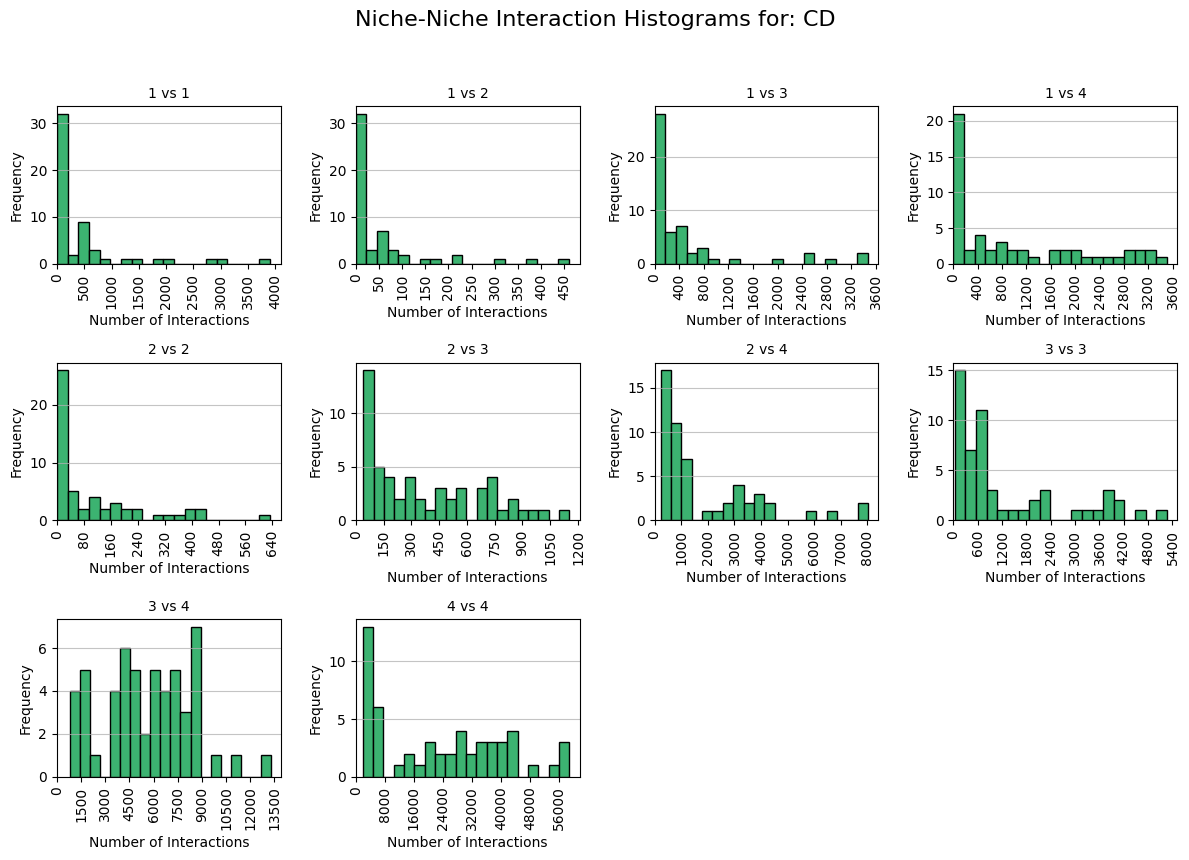


Analyzing Disease Group: HC


Processing FOVs for HC: 55it [02:20,  2.55s/it]


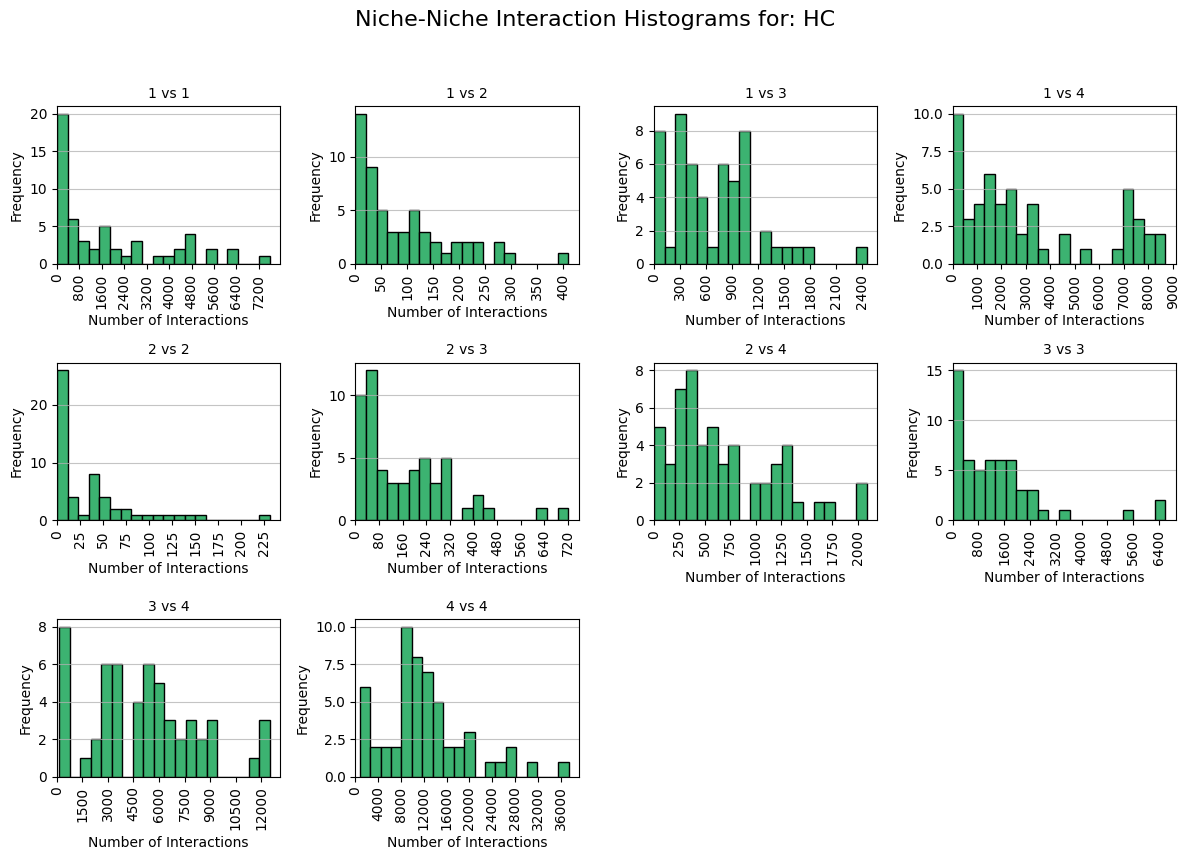


Analyzing Disease Group: UC


Processing FOVs for UC: 62it [03:30,  3.39s/it]


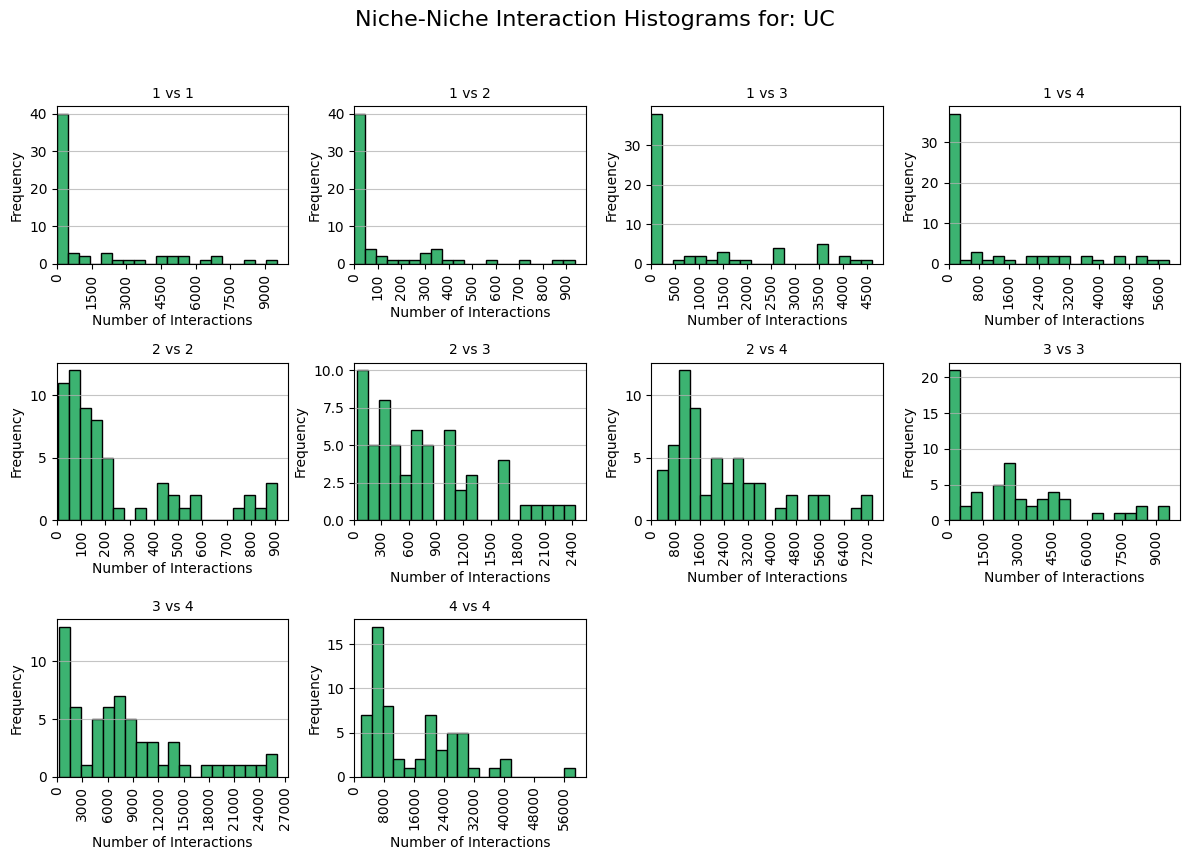


✅ All histograms generated and saved successfully.


In [26]:
# --- 1. Setup and Parameters ---
# File paths
h5ad_file_path = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/CompleteCosMx_singlecellspatialresolution.h5ad"
output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"

# Load the AnnData object
print("Loading data...")
try:
    adata = sc.read(filename=h5ad_file_path)
    print("✅ AnnData object loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {h5ad_file_path}")
    exit()

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Create the 'Disease_State' column from the 'patient' column
adata.obs['Disease_State'] = adata.obs['patient'].astype(str).str[:2]

# Create a truly unique FOV identifier for the whole dataset
adata.obs['unique_fov'] = adata.obs['patient'].astype(str) + '_' + adata.obs['fov'].astype(str)

# Prepare data for analysis
coords_um = adata.obs[['CenterX_global_px', 'CenterY_global_px']].values.astype('float64')
nmf_labels = adata.obs['NMF_factor']
cell_diameters_um = 2 * np.sqrt(adata.obs['Area'] / np.pi)
all_factor_names = sorted(adata.obs['NMF_factor'].unique())
disease_groups = adata.obs['Disease_State'].unique()

# --- 2. Loop Through Each Disease Group ---
for disease in disease_groups:
    print(f"\n{'='*20}\nAnalyzing Disease Group: {disease}\n{'='*20}")

    # Subset the data for the current disease group
    adata_subset = adata[adata.obs['Disease_State'] == disease].copy()
    
    # --- Calculate FOV-Level Interaction Matrices ---
    fov_interaction_matrices = []
    fov_groups = adata_subset.obs.reset_index().groupby('unique_fov')['index'].apply(list)
    
    for fov_id, cell_indices in tqdm(fov_groups.items(), desc=f"Processing FOVs for {disease}"):
        fov_coords = coords_um[adata.obs.index.isin(cell_indices)]
        if len(fov_coords) < 2:
            continue
        tree = KDTree(fov_coords)
        nmf_labels_subset = nmf_labels.loc[cell_indices]
        cell_diameters_subset = cell_diameters_um.loc[cell_indices].values
        interaction_matrix = pd.DataFrame(0, index=all_factor_names, columns=all_factor_names)

        for i in range(len(fov_coords)):
            per_cell_threshold = 2 * cell_diameters_subset[i]
            neighbor_indices_list = tree.query_radius([fov_coords[i]], r=per_cell_threshold)
            neighbor_indices = neighbor_indices_list[0][neighbor_indices_list[0] != i]

            if len(neighbor_indices) > 0:
                factor_i = nmf_labels_subset.iloc[i]
                factors_j = nmf_labels_subset.iloc[neighbor_indices]
                counts = factors_j.value_counts()
                interaction_matrix.loc[factor_i, counts.index] += counts
    
        fov_interaction_matrices.append(interaction_matrix)

    if not fov_interaction_matrices:
        print(f"⚠️ No interactions found for '{disease}'. Skipping plots.")
        continue

    # --- Collect all interactions for each pair ---
    interaction_counts_dict = {f"{n1} vs {n2}": [] for n1, n2 in itertools.combinations_with_replacement(all_factor_names, 2)}
    
    for matrix in fov_interaction_matrices:
        for n1, n2 in itertools.combinations_with_replacement(all_factor_names, 2):
            count = matrix.loc[n1, n2]
            if n1 != n2:
                count += matrix.loc[n2, n1]
            interaction_counts_dict[f"{n1} vs {n2}"].append(count)

    # --- Create the multi-plot figure ---
    n_plots = len(interaction_counts_dict)
    cols = int(np.ceil(np.sqrt(n_plots)))
    rows = int(np.ceil(n_plots / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = axes.flatten()

    for idx, (pair_name, counts) in enumerate(interaction_counts_dict.items()):
        ax = axes[idx]
        ax.hist(counts, bins=20, color='mediumseagreen', edgecolor='black')
        ax.set_title(pair_name, fontsize=10)
        ax.set_xlabel('Number of Interactions')
        ax.set_ylabel('Frequency')
        ax.grid(axis='y', alpha=0.75)
        
        # Set the minimum x-axis value to 0 and use whole numbers
        ax.set_xlim(left=0)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
        # --- NEW: Rotate the x-axis labels 90 degrees ---
        ax.tick_params(axis='x', rotation=90)

    for i in range(len(interaction_counts_dict), len(axes)):
        fig.delaxes(axes[i])
        
    plt.suptitle(f"Niche-Niche Interaction Histograms for: {disease}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    filename = f"Niche_Interaction_Histograms_{disease}_DynamicThreshold.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=600)
    plt.show()

print("\n✅ All histograms generated and saved successfully.")

#### Training the Random Forest Model

## Spatial Feature Engineering with Random Forest

#### Feature Engineering

##### Niche-gene features - significantly dysregulated genes per disease/health state in each niche

In [79]:
# Suppress warnings from scikit-learn for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=FutureWarning, module='pandas')

# --- 1. Setup and Data Loading ---
h5ad_file_path = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Corrected_CompleteCosMx.h5ad"
feature_output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
dysregulated_genes_dir = os.path.join(feature_output_dir, 'DysregulatedGenesPerDiseaseStatePerNiche')

os.makedirs(feature_output_dir, exist_ok=True)

print("Loading data...")
try:
    adata = sc.read(filename=h5ad_file_path)
    print("✅ AnnData object loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {h5ad_file_path}")
    exit()

# --- 2. Data Preparation ---
adata.obs['Disease_State'] = adata.obs['patient'].astype(str).str[:2]
adata.obs['unique_fov'] = adata.obs['patient'].astype(str) + '_' + adata.obs['fov'].astype(str)

# --- FIX ---
# CONVERT NMF_factor to string to match the key from the dictionary
adata.obs['NMF_factor'] = adata.obs['NMF_factor'].astype(str)

nmf_labels = adata.obs['NMF_factor']
all_factor_names = sorted(adata.obs['NMF_factor'].unique())

# --- 3. Generate Niche-Specific Gene Expression Features ---

print("\n--- Generating Niche-Specific Gene Expression Features ---")
# a. Collect all significant genes from CSV files
significant_genes_dict = {}
if os.path.isdir(dysregulated_genes_dir):
    for filename in os.listdir(dysregulated_genes_dir):
        if filename.endswith(".csv"):
            parts = filename.split('_')
            niche = parts[1]
            disease_state = parts[-1].split('.')[0]
            df_genes = pd.read_csv(os.path.join(dysregulated_genes_dir, filename))
            
            for gene in df_genes['gene'].tolist():
                key = f"niche_{niche}_gene_{gene}"
                if key not in significant_genes_dict:
                    significant_genes_dict[key] = (niche, gene)

print(f"✅ Found {len(significant_genes_dict)} unique niche-gene features.")

# b. Calculate the mean expression for each niche-gene pair
# --- FINAL CORRECTED METHOD ---
fov_list = adata.obs['unique_fov'].unique().tolist()
feature_columns = list(significant_genes_dict.keys())

niche_gene_features_df = pd.DataFrame(0.0, index=fov_list, columns=feature_columns)

# Get the expression matrix and obs data in a usable format
adata_X = adata.X.A if issparse(adata.X) else adata.X
obs_df = adata.obs[['unique_fov', 'NMF_factor']].copy()
# Create a global index to map from pandas Index to a NumPy array position
obs_df['global_idx'] = np.arange(adata.n_obs)

for key, (niche, gene) in tqdm(significant_genes_dict.items(), desc="Calculating Niche-Gene Features"):
    if gene in adata.var_names:
        gene_idx = adata.var_names.get_loc(gene)
        
        # Get all cells that belong to this niche
        niche_cells_obs = obs_df[obs_df['NMF_factor'] == niche]
        
        if not niche_cells_obs.empty:
            mean_expression_per_fov = niche_cells_obs.groupby('unique_fov').apply(
                lambda fov_group: 
                    adata_X[fov_group['global_idx'].values, gene_idx].mean()
            )
            
            niche_gene_features_df.loc[mean_expression_per_fov.index, key] = mean_expression_per_fov

print("✅ Niche-gene features pre-calculated successfully.")


# --- 4. Print a preview of the new features and save them ---
print("\n--- Engineered Niche-Gene Feature DataFrame (X_genes) ---")
print(f"DataFrame shape: {niche_gene_features_df.shape}")
print(niche_gene_features_df.head())

niche_gene_features_df.to_parquet(os.path.join(feature_output_dir, 'niche_gene_features.parquet'))
print("\n✅ Niche-gene features saved to niche_gene_features.parquet.")

Loading data...
✅ AnnData object loaded successfully.

--- Generating Niche-Specific Gene Expression Features ---
✅ Found 2751 unique niche-gene features.


Calculating Niche-Gene Features:   0%|          | 0/2751 [00:00<?, ?it/s]/scratch/local/10764473/ipykernel_301452/1000531431.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_expression_per_fov = niche_cells_obs.groupby('unique_fov').apply(
/scratch/local/10764473/ipykernel_301452/1000531431.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_expression_per_fov = niche_cells_obs.groupby('unique_fov').ap

✅ Niche-gene features pre-calculated successfully.

--- Engineered Niche-Gene Feature DataFrame (X_genes) ---
DataFrame shape: (171, 2751)
        niche_1_gene_MZT2A  niche_1_gene_S100A6  niche_1_gene_MALAT1  \
CD c_1            0.833134             0.609082             0.839878   
CD c_2            0.736191             0.615549             1.030041   
CD c_3            0.531510             0.718989             0.877707   
CD c_4            1.030746             0.000000             0.000000   
CD c_5            0.621997             0.624098             1.171348   

        niche_1_gene_S100P  niche_1_gene_NEAT1  niche_1_gene_HSPB1  \
CD c_1            0.170163            0.177036            0.138408   
CD c_2            0.264964            0.256021            0.104252   
CD c_3            0.322172            0.350875            0.251939   
CD c_4            0.386375            0.000000            0.000000   
CD c_5            0.221180            0.418898            0.135382   

       

In [10]:
def parquet_to_csv(parquet_file_path):
    """
    Converts a Parquet file to a CSV file in the same directory.
    
    Args:
        parquet_file_path (str): The full path to the Parquet file.
    """
    
    # Check if the file exists
    if not os.path.exists(parquet_file_path):
        print(f"Error: The file '{parquet_file_path}' does not exist.")
        return

    # Create the output CSV file path
    directory = os.path.dirname(parquet_file_path)
    filename = os.path.basename(parquet_file_path)
    csv_filename = os.path.splitext(filename)[0] + '.csv'
    csv_file_path = os.path.join(directory, csv_filename)
    
    try:
        # Read the Parquet file into a pandas DataFrame
        print(f"Reading Parquet file: {parquet_file_path}")
        df = pd.read_parquet(parquet_file_path)
        
        # Write the DataFrame to a CSV file
        print(f"Writing to CSV file: {csv_file_path}")
        df.to_csv(csv_file_path, index=False)
        
        print("Conversion complete!")
        
    except Exception as e:
        print(f"An error occurred: {e}")

# Specify the path to your Parquet file
parquet_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/niche_gene_features_filtered.parquet'

# Run the function to perform the conversion
parquet_to_csv(parquet_file)

Reading Parquet file: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/niche_gene_features_filtered.parquet
Writing to CSV file: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/niche_gene_features_filtered.csv
Conversion complete!


In [8]:
def filter_parquet_features(input_path, output_path, prefix_to_remove):
    """
    Removes columns from a Parquet file whose names start with a specified prefix.

    Args:
        input_path (str): The path to the input Parquet file.
        output_path (str): The path where the filtered Parquet file will be saved.
        prefix_to_remove (str): The prefix of the column names to be removed.
    """
    try:
        # Read the Parquet file into a pandas DataFrame
        print(f"Reading file: {input_path}")
        df = pd.read_parquet(input_path)

        # Identify columns to keep
        # This creates a list of column names that do NOT start with the specified prefix
        columns_to_keep = [col for col in df.columns if not col.startswith(prefix_to_remove)]

        # Filter the DataFrame to keep only the desired columns
        print(f"Filtering columns that start with '{prefix_to_remove}'...")
        filtered_df = df[columns_to_keep]

        # Save the new, filtered DataFrame to a new Parquet file
        print(f"Saving filtered data to: {output_path}")
        filtered_df.to_parquet(output_path, engine='pyarrow')

        print("Filtering complete! The new file has been created.")

    except FileNotFoundError:
        print(f"Error: The file '{input_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Define the paths and the prefix
input_parquet_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/niche_gene_features.parquet'
output_parquet_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/niche_gene_features_filtered.parquet'
prefix_to_remove = 'niche_Genes'

# Run the function to perform the filtering
filter_parquet_features(input_parquet_file, output_parquet_file, prefix_to_remove)

Reading file: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/niche_gene_features.parquet
Filtering columns that start with 'niche_Genes'...
Saving filtered data to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/niche_gene_features_filtered.parquet
Filtering complete! The new file has been created.


In [11]:
# --- File path ---
file_path = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/niche_gene_features.parquet"

# --- Check for the existence of the file ---
if not os.path.exists(file_path):
    print(f"Error: The file was not found at the specified path:\n{file_path}")
else:
    # --- Load the parquet file ---
    try:
        df = pd.read_parquet(file_path)
        
        # --- Count total, zero, and non-zero values ---
        total_values = df.size
        zero_values = (df == 0).sum().sum()
        non_zero_values = (df != 0).sum().sum()
        
        # --- Calculate percentages ---
        percent_zero = (zero_values / total_values) * 100
        percent_non_zero = (non_zero_values / total_values) * 100
        
        # --- Print the report ---
        print("✅ Analysis of Niche-Gene Features Complete")
        print("--------------------------------------------------")
        print(f"Total values in the DataFrame: {total_values}")
        print(f"Total non-zero values:       {non_zero_values}")
        print(f"Total zero values:           {zero_values}")
        print("--------------------------------------------------")
        print(f"Percentage of non-zero values: {percent_non_zero:.2f}%")
        print(f"Percentage of zero values:     {percent_zero:.2f}%")
            
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")

✅ Analysis of Niche-Gene Features Complete
--------------------------------------------------
Total values in the DataFrame: 470421
Total non-zero values:       254073
Total zero values:           216348
--------------------------------------------------
Percentage of non-zero values: 54.01%
Percentage of zero values:     45.99%


In [13]:
# --- File directory ---
file_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
print(f"Loading files from: {file_dir}\n")

# --- List of files to load ---
files_to_check = [
    'combined_features_filtered.parquet',
    'targets_y.parquet',
    'groups.parquet',
    'features_X.parquet'
]

for filename in files_to_check:
    file_path = os.path.join(file_dir, filename)
    print("=" * 60)
    print(f"--- Previewing: {filename} ---")
    
    if not os.path.exists(file_path):
        print(f"❌ Error: File not found at {file_path}")
        continue
    
    try:
        # Load the file
        df = pd.read_parquet(file_path)
        
        # Squeeze the DataFrame if it has only one column to make it a Series
        if df.shape[1] == 1:
            df = df.squeeze()
        
        # Print the shape and a preview of the head
        print(f"DataFrame shape: {df.shape}")
        print("\n", df.head())
        
    except Exception as e:
        print(f"An error occurred while loading {filename}: {e}")

Loading files from: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis

--- Previewing: combined_features_filtered.parquet ---
DataFrame shape: (171, 1836)

          comp_niche_1  comp_niche_2  comp_niche_3  comp_niche_4  \
CD a_1       0.169811      0.033019      0.370283      0.426887   
CD a_10      0.136503      0.057515      0.347393      0.458589   
CD a_11      0.065599      0.049070      0.439050      0.446281   
CD a_12      0.091099      0.050262      0.435602      0.423037   
CD a_13      0.048752      0.053395      0.475914      0.421938   

         enrichment_1-1  enrichment_1-2  enrichment_1-3  enrichment_1-4  \
CD a_1         1.366921       -0.548594       -0.471924       -0.630312   
CD a_10        2.015358       -0.856613       -0.757777       -0.668378   
CD a_11        2.275095       -1.632515       -0.591459       -0.531085   
CD a_12        1.621309       -0.166728       -0.324380       -0.355137   
CD a_13        1.410277       -0.648091        0.05699

In [88]:
# --- File Paths ---
feature_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
niche_gene_path = os.path.join(feature_dir, 'niche_gene_features.parquet')
features_X_path = os.path.join(feature_dir, 'features_X.parquet')
combined_features_path = os.path.join(feature_dir, 'combined_features.parquet')

print("Loading feature sets...")
try:
    niche_gene_df = pd.read_parquet(niche_gene_path)
    features_X_df = pd.read_parquet(features_X_path)
    
    print("✅ Feature files loaded successfully.")

    # --- FIX: Sort the indices of both DataFrames ---
    print("\nSorting DataFrame indices to ensure alignment...")
    niche_gene_df = niche_gene_df.sort_index()
    features_X_df = features_X_df.sort_index()
    
    # --- Check for index equality after sorting ---
    if not niche_gene_df.index.equals(features_X_df.index):
        print("❌ Error: Indices do not match even after sorting. Cannot combine.")
    else:
        # --- Combine the two DataFrames ---
        print("✅ Indices are now aligned. Combining DataFrames...")
        combined_df = pd.concat([features_X_df, niche_gene_df], axis=1)
        
        # --- Save the combined DataFrame ---
        print("\nSaving combined features...")
        combined_df.to_parquet(combined_features_path)
        
        print("✅ Combined DataFrame created and saved.")
        print(f"New DataFrame shape: {combined_df.shape}")
        print(f"File saved to: {combined_features_path}")

except FileNotFoundError as e:
    print(f"❌ Error: One of the files was not found: {e}")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")

Loading feature sets...
✅ Feature files loaded successfully.

Sorting DataFrame indices to ensure alignment...
✅ Indices are now aligned. Combining DataFrames...

Saving combined features...
✅ Combined DataFrame created and saved.
New DataFrame shape: (171, 2771)
File saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/combined_features.parquet


In [83]:
# --- 1. Setup and Data Loading ---
h5ad_file_path = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/CompleteCosMx_singlecellspatialresolution.h5ad"
feature_output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
os.makedirs(feature_output_dir, exist_ok=True)

print("Loading data...")
try:
    adata = sc.read(filename=h5ad_file_path)
    print("✅ AnnData object loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {h5ad_file_path}")
    exit()

# --- 2. Data Preparation for Feature Engineering ---
adata.obs['Disease_State'] = adata.obs['patient'].astype(str).str[:2]
adata.obs['unique_fov'] = adata.obs['patient'].astype(str) + '_' + adata.obs['fov'].astype(str)

coords_um = adata.obs[['CenterX_global_px', 'CenterY_global_px']].values.astype('float64')
nmf_labels = adata.obs['NMF_factor']
cell_diameters_um = 2 * np.sqrt(adata.obs['Area'] / np.pi)
all_factor_names = sorted(adata.obs['NMF_factor'].unique())

# --- 3. Engineer FOV-Level Features ---
features = []
targets = []
groups = []
# NEW: Create a list to store the FOV IDs
fov_ids_list = []
fov_groups = adata.obs.reset_index().groupby('unique_fov')['index'].apply(list)
print(f"\nBuilding features for {len(fov_groups)} unique Fields of View...")

for fov_id, cell_indices in tqdm(fov_groups.items(), desc="Calculating Features per FOV"):
    fov_df = adata.obs.loc[cell_indices]
    fov_coords = coords_um[adata.obs.index.isin(cell_indices)]
    fov_labels = nmf_labels.loc[cell_indices]
    fov_cell_diameters = cell_diameters_um.loc[cell_indices].values
    
    if len(fov_coords) < 2: continue
        
    composition = fov_labels.value_counts(normalize=True).reindex(all_factor_names, fill_value=0)
    
    tree = KDTree(fov_coords)
    interaction_matrix = pd.DataFrame(0, index=all_factor_names, columns=all_factor_names)
    for i in range(len(fov_coords)):
        per_cell_threshold = 2 * fov_cell_diameters[i]
        neighbor_indices_list = tree.query_radius([fov_coords[i]], r=per_cell_threshold)
        neighbor_indices = neighbor_indices_list[0][neighbor_indices_list[0] != i]
        if len(neighbor_indices) > 0:
            factor_i = fov_labels.iloc[i]
            factors_j = fov_labels.iloc[neighbor_indices]
            counts = factors_j.value_counts()
            interaction_matrix.loc[factor_i, counts.index] += counts

    total_interaction_matrix = interaction_matrix + interaction_matrix.T
    niche_proportions = fov_labels.value_counts(normalize=True).reindex(all_factor_names, fill_value=0)
    total_interactions = total_interaction_matrix.sum().sum()
    if total_interactions == 0:
        enrichment_matrix = pd.DataFrame(0, index=all_factor_names, columns=all_factor_names)
    else:
        expected_matrix = total_interactions * np.outer(niche_proportions, niche_proportions)
        enrichment_matrix = np.log2((total_interaction_matrix + 1) / (expected_matrix + 1))
    
    enrichment_features_dict = {}
    for n1 in all_factor_names:
        for n2 in all_factor_names:
            enrichment_features_dict[f'enrichment_{n1}-{n2}'] = enrichment_matrix.loc[n1, n2]
    
    fov_features_dict = {
        **{f"comp_niche_{c}": val for c, val in composition.items()},
        **enrichment_features_dict
    }
    features.append(fov_features_dict)
    targets.append(fov_df['Disease_State'].iloc[0])
    groups.append(fov_df['patient'].iloc[0])
    # NEW: Append the FOV ID
    fov_ids_list.append(fov_id)

# NEW: Create the DataFrame with the FOV IDs as the index
X = pd.DataFrame(features, index=fov_ids_list)
y = pd.Series(targets, index=fov_ids_list)
groups = pd.Series(groups, index=fov_ids_list)
X.dropna(inplace=True)
y = y.loc[X.index]
groups = groups.loc[X.index]

# --- Save the engineered features and labels ---
X.to_parquet(os.path.join(feature_output_dir, 'features_X.parquet'))
y.to_frame('Disease_State').to_parquet(os.path.join(feature_output_dir, 'targets_y.parquet'))
groups.to_frame('patient').to_parquet(os.path.join(feature_output_dir, 'groups.parquet'))
print("\n✅ Engineered features, targets, and groups saved successfully.")

Loading data...
✅ AnnData object loaded successfully.

Building features for 171 unique Fields of View...


Calculating Features per FOV: 171it [09:38,  3.38s/it]


✅ Engineered features, targets, and groups saved successfully.


In [84]:
# --- Define the directory where the files were saved ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"

# --- Load the pre-calculated features and labels ---
X = pd.read_parquet(os.path.join(feature_input_dir, 'features_X.parquet'))
y = pd.read_parquet(os.path.join(feature_input_dir, 'targets_y.parquet')).squeeze()
groups = pd.read_parquet(os.path.join(feature_input_dir, 'groups.parquet')).squeeze()

print("✅ Engineered features and labels loaded successfully.")

print("\n--- Engineered Feature DataFrame (X.head()) ---")
print(X.head())
print(f"\nDataFrame shape: {X.shape}")

print("\n--- Target Labels (y.head()) ---")
print(y.head())

print("\n--- Grouping Labels (groups.head()) ---")
print(groups.head())

✅ Engineered features and labels loaded successfully.

--- Engineered Feature DataFrame (X.head()) ---
         comp_niche_1  comp_niche_2  comp_niche_3  comp_niche_4  \
CD a_1       0.169811      0.033019      0.370283      0.426887   
CD a_10      0.136503      0.057515      0.347393      0.458589   
CD a_11      0.065599      0.049070      0.439050      0.446281   
CD a_12      0.091099      0.050262      0.435602      0.423037   
CD a_13      0.048752      0.053395      0.475914      0.421938   

         enrichment_1-1  enrichment_1-2  enrichment_1-3  enrichment_1-4  \
CD a_1         1.366921       -0.548594       -0.471924       -0.630312   
CD a_10        2.015358       -0.856613       -0.757777       -0.668378   
CD a_11        2.275095       -1.632515       -0.591459       -0.531085   
CD a_12        1.621309       -0.166728       -0.324380       -0.355137   
CD a_13        1.410277       -0.648091        0.056991       -0.296770   

         enrichment_2-1  enrichment_2-2  en

### Information-Theoretic Feature Selection

#### 10 Features

In [30]:
# --- File Paths ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
features_path = os.path.join(feature_input_dir, 'combined_features_filtered.parquet')
targets_path = os.path.join(feature_input_dir, 'targets_y.parquet')

# --- CORRECTED: Use a new output directory for 10 features ---
output_dir = os.path.join(feature_input_dir, '10BestFeatures_InformationTheoretic')
os.makedirs(output_dir, exist_ok=True)

print("Loading data...")
try:
    X = pd.read_parquet(features_path)
    y = pd.read_parquet(targets_path).squeeze()
    
    print("✅ Data loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error: One of the files was not found: {e}")
    exit()

# --- Filter for only niche-gene features ---
niche_gene_features = X.filter(like='niche_')

print(f"✅ Filtered for {niche_gene_features.shape[1]} niche-gene features.")

# --- Define number of features to select ---
num_features_to_select = 10

# --- Calculate MI for each disease state ---
unique_disease_states = y.unique()
all_p_values = {}
all_top_features_dfs = []

for disease_state in unique_disease_states:
    print(f"\n--- Calculating Mutual Information for: {disease_state} vs. All Other States ---")
    
    y_binary = (y == disease_state).astype(int)
    mi_scores = mutual_info_classif(niche_gene_features, y_binary, random_state=42)
    mi_series = pd.Series(mi_scores, index=niche_gene_features.columns)
    
    # NEW: Get the top 10 features
    top_features = mi_series.nlargest(num_features_to_select).to_frame('MI_Score')
    
    p_values = []
    
    for feature in tqdm(top_features.index, desc=f"Running statistical tests for {disease_state}"):
        group_1 = niche_gene_features.loc[y == disease_state, feature]
        group_2 = niche_gene_features.loc[y != disease_state, feature]
        stat, p_val = mannwhitneyu(group_1, group_2, alternative='two-sided')
        p_values.append(p_val)
        
    top_features['p_value'] = p_values
    top_features['Disease_State'] = disease_state
    
    all_p_values[disease_state] = p_values
    all_top_features_dfs.append(top_features)

    print(f"\nTop {num_features_to_select} most informative features for distinguishing '{disease_state}':")
    print(top_features)
    
    # NEW: Save the top 10 features to a CSV file
    output_path = os.path.join(output_dir, f"{num_features_to_select}BestFeatures_{disease_state}.csv")
    top_features.to_csv(output_path)
    
    print(f"✅ Top {num_features_to_select} features for {disease_state} saved to {output_path}")

# --- NEW: Apply multiple testing correction and filter for unique features ---
print("\n--- Applying Multiple Testing Correction (Benjamini-Hochberg) ---")
all_p_values_flat = [p for sublist in all_p_values.values() for p in sublist]
reject, p_adj, _, _ = multipletests(all_p_values_flat, method='fdr_bh')

# Combine all top features into one DataFrame
all_features_combined = pd.concat(all_top_features_dfs)
all_features_combined['p_adj_fdr'] = p_adj

# Filter for features that appear only once (unique)
unique_features = all_features_combined.groupby(all_features_combined.index).filter(lambda x: len(x) == 1)

# Filter for statistical significance
final_unique_features = unique_features[unique_features['p_adj_fdr'] < 0.05]

print(f"\n✅ Found {len(final_unique_features)} unique, significant features.")
print("\nFinal Unique Features Table:")
print(final_unique_features)

# NEW: Save the final list to a CSV
final_output_path = os.path.join(output_dir, 'Final_Unique_Significant_Features.csv')
final_unique_features.to_csv(final_output_path)
print(f"✅ Final list of features saved to {final_output_path}")

Loading data...
✅ Data loaded successfully.
✅ Filtered for 1820 niche-gene features.

--- Calculating Mutual Information for: CD vs. All Other States ---


Running statistical tests for CD: 100%|██████████| 10/10 [00:00<00:00, 676.46it/s]



Top 10 most informative features for distinguishing 'CD':
                      MI_Score   p_value Disease_State
niche_4_gene_FZD1     0.352488  0.000361            CD
niche_3_gene_IGHG2    0.280828  0.021758            CD
niche_4_gene_HDAC5    0.262171  0.002564            CD
niche_3_gene_IGHG1    0.253393  0.024786            CD
niche_4_gene_COL5A1   0.252364  0.000134            CD
niche_3_gene_MZT2A    0.244038  0.000233            CD
niche_2_gene_B2M      0.241641  0.346148            CD
niche_4_gene_RARRES2  0.241029  0.010159            CD
niche_4_gene_SOX6     0.235310  0.006729            CD
niche_3_gene_COL9A2   0.229591  0.014928            CD
✅ Top 10 features for CD saved to /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/10BestFeatures_InformationTheoretic/10BestFeatures_CD.csv

--- Calculating Mutual Information for: HC vs. All Other States ---


Running statistical tests for HC: 100%|██████████| 10/10 [00:00<00:00, 671.36it/s]



Top 10 most informative features for distinguishing 'HC':
                     MI_Score       p_value Disease_State
niche_3_gene_IGHG2   0.468081  8.485607e-24            HC
niche_3_gene_IGHG1   0.442345  7.119781e-23            HC
niche_1_gene_IGHG1   0.435818  1.345161e-04            HC
niche_4_gene_CD38    0.400881  1.592304e-21            HC
niche_4_gene_IGHG1   0.386193  1.643826e-21            HC
niche_1_gene_IFI27   0.378352  4.668550e-02            HC
niche_4_gene_IGHG2   0.369088  1.023175e-20            HC
niche_4_gene_STAT1   0.367323  3.004217e-21            HC
niche_4_gene_CHI3L1  0.362760  2.264906e-19            HC
niche_1_gene_PIGR    0.356891  5.409724e-19            HC
✅ Top 10 features for HC saved to /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/10BestFeatures_InformationTheoretic/10BestFeatures_HC.csv

--- Calculating Mutual Information for: UC vs. All Other States ---


Running statistical tests for UC: 100%|██████████| 10/10 [00:00<00:00, 697.96it/s]


Top 10 most informative features for distinguishing 'UC':
                       MI_Score       p_value Disease_State
niche_4_gene_IGKC      0.313496  7.119205e-04            UC
niche_3_gene_IGHG2     0.291168  4.277335e-14            UC
niche_3_gene_IGHG1     0.290972  1.415877e-13            UC
niche_1_gene_IGHG1     0.286613  3.221542e-03            UC
niche_4_gene_IGHG1     0.283584  3.281769e-11            UC
niche_4_gene_CASP3     0.280068  3.944337e-16            UC
niche_4_gene_HLA-DQB1  0.277384  8.841964e-13            UC
niche_3_gene_IGFBP5    0.276245  7.129288e-12            UC
niche_2_gene_IGFBP5    0.270732  1.288248e-10            UC
niche_1_gene_MX1       0.269371  9.673197e-01            UC
✅ Top 10 features for UC saved to /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/10BestFeatures_InformationTheoretic/10BestFeatures_UC.csv

--- Applying Multiple Testing Correction (Benjamini-Hochberg) ---

✅ Found 17 unique, significant features.

Final Unique Featu

#### 15 Features

In [33]:
# --- File Paths ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
features_path = os.path.join(feature_input_dir, 'combined_features_filtered.parquet')
targets_path = os.path.join(feature_input_dir, 'targets_y.parquet')

# --- CORRECTED: Use a new output directory for 15 features ---
output_dir = os.path.join(feature_input_dir, '15BestFeatures_InformationTheoretic')
os.makedirs(output_dir, exist_ok=True)

print("Loading data...")
try:
    X = pd.read_parquet(features_path)
    y = pd.read_parquet(targets_path).squeeze()
    
    print("✅ Data loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error: One of the files was not found: {e}")
    exit()

# --- Filter for only niche-gene features ---
niche_gene_features = X.filter(like='niche_')

print(f"✅ Filtered for {niche_gene_features.shape[1]} niche-gene features.")

# --- Define number of features to select ---
num_features_to_select = 15

# --- Calculate MI for each disease state ---
unique_disease_states = y.unique()
all_p_values = {}
all_top_features_dfs = []

for disease_state in unique_disease_states:
    print(f"\n--- Calculating Mutual Information for: {disease_state} vs. All Other States ---")
    
    y_binary = (y == disease_state).astype(int)
    mi_scores = mutual_info_classif(niche_gene_features, y_binary, random_state=42)
    mi_series = pd.Series(mi_scores, index=niche_gene_features.columns)
    
    # NEW: Get the top 15 features
    top_features = mi_series.nlargest(num_features_to_select).to_frame('MI_Score')
    
    p_values = []
    
    for feature in tqdm(top_features.index, desc=f"Running statistical tests for {disease_state}"):
        group_1 = niche_gene_features.loc[y == disease_state, feature]
        group_2 = niche_gene_features.loc[y != disease_state, feature]
        stat, p_val = mannwhitneyu(group_1, group_2, alternative='two-sided')
        p_values.append(p_val)
        
    top_features['p_value'] = p_values
    top_features['Disease_State'] = disease_state
    
    all_p_values[disease_state] = p_values
    all_top_features_dfs.append(top_features)

    print(f"\nTop {num_features_to_select} most informative features for distinguishing '{disease_state}':")
    print(top_features)
    
    # NEW: Save the top 15 features to a CSV file
    output_path = os.path.join(output_dir, f"{num_features_to_select}BestFeatures_{disease_state}.csv")
    top_features.to_csv(output_path)
    
    print(f"✅ Top {num_features_to_select} features for {disease_state} saved to {output_path}")

# --- NEW: Apply multiple testing correction and filter for unique features ---
print("\n--- Applying Multiple Testing Correction (Benjamini-Hochberg) ---")
all_p_values_flat = [p for sublist in all_p_values.values() for p in sublist]
reject, p_adj, _, _ = multipletests(all_p_values_flat, method='fdr_bh')

# Combine all top features into one DataFrame
all_features_combined = pd.concat(all_top_features_dfs)
all_features_combined['p_adj_fdr'] = p_adj

# Filter for features that appear only once (unique)
unique_features = all_features_combined.groupby(all_features_combined.index).filter(lambda x: len(x) == 1)

# Filter for statistical significance
final_unique_features = unique_features[unique_features['p_adj_fdr'] < 0.05]

print(f"\n✅ Found {len(final_unique_features)} unique, significant features.")
print("\nFinal Unique Features Table:")
print(final_unique_features)

# NEW: Save the final list to a CSV
final_output_path = os.path.join(output_dir, 'Final_Unique_Significant_Features.csv')
final_unique_features.to_csv(final_output_path)
print(f"✅ Final list of features saved to {final_output_path}")

Loading data...
✅ Data loaded successfully.
✅ Filtered for 1820 niche-gene features.

--- Calculating Mutual Information for: CD vs. All Other States ---


Running statistical tests for CD: 100%|██████████| 15/15 [00:00<00:00, 707.62it/s]



Top 15 most informative features for distinguishing 'CD':
                      MI_Score   p_value Disease_State
niche_4_gene_FZD1     0.352488  0.000361            CD
niche_3_gene_IGHG2    0.280828  0.021758            CD
niche_4_gene_HDAC5    0.262171  0.002564            CD
niche_3_gene_IGHG1    0.253393  0.024786            CD
niche_4_gene_COL5A1   0.252364  0.000134            CD
niche_3_gene_MZT2A    0.244038  0.000233            CD
niche_2_gene_B2M      0.241641  0.346148            CD
niche_4_gene_RARRES2  0.241029  0.010159            CD
niche_4_gene_SOX6     0.235310  0.006729            CD
niche_3_gene_COL9A2   0.229591  0.014928            CD
niche_1_gene_IGHG1    0.227650  0.430441            CD
niche_4_gene_CHN1     0.225589  0.067349            CD
niche_4_gene_KRT8     0.213269  0.819935            CD
niche_4_gene_FOXF1    0.211092  0.007509            CD
niche_4_gene_MZT2A    0.209236  0.001161            CD
✅ Top 15 features for CD saved to /blue/pbenos/tan.m/IBDCosMx

Running statistical tests for HC: 100%|██████████| 15/15 [00:00<00:00, 686.76it/s]



Top 15 most informative features for distinguishing 'HC':
                       MI_Score       p_value Disease_State
niche_3_gene_IGHG2     0.468081  8.485607e-24            HC
niche_3_gene_IGHG1     0.442345  7.119781e-23            HC
niche_1_gene_IGHG1     0.435818  1.345161e-04            HC
niche_4_gene_CD38      0.400881  1.592304e-21            HC
niche_4_gene_IGHG1     0.386193  1.643826e-21            HC
niche_1_gene_IFI27     0.378352  4.668550e-02            HC
niche_4_gene_IGHG2     0.369088  1.023175e-20            HC
niche_4_gene_STAT1     0.367323  3.004217e-21            HC
niche_4_gene_CHI3L1    0.362760  2.264906e-19            HC
niche_1_gene_PIGR      0.356891  5.409724e-19            HC
niche_2_gene_IGHG2     0.351998  2.018946e-20            HC
niche_1_gene_IGHG2     0.351286  5.082147e-05            HC
niche_1_gene_HLA-DRB1  0.350982  2.973350e-02            HC
niche_2_gene_IGHG1     0.347818  3.759198e-20            HC
niche_1_gene_OLFM4     0.339359  4.630691

Running statistical tests for UC: 100%|██████████| 15/15 [00:00<00:00, 692.18it/s]


Top 15 most informative features for distinguishing 'UC':
                       MI_Score       p_value Disease_State
niche_4_gene_IGKC      0.313496  7.119205e-04            UC
niche_3_gene_IGHG2     0.291168  4.277335e-14            UC
niche_3_gene_IGHG1     0.290972  1.415877e-13            UC
niche_1_gene_IGHG1     0.286613  3.221542e-03            UC
niche_4_gene_IGHG1     0.283584  3.281769e-11            UC
niche_4_gene_CASP3     0.280068  3.944337e-16            UC
niche_4_gene_HLA-DQB1  0.277384  8.841964e-13            UC
niche_3_gene_IGFBP5    0.276245  7.129288e-12            UC
niche_2_gene_IGFBP5    0.270732  1.288248e-10            UC
niche_1_gene_MX1       0.269371  9.673197e-01            UC
niche_4_gene_COL3A1    0.266505  1.931792e-14            UC
niche_4_gene_RARRES2   0.262874  2.331621e-10            UC
niche_3_gene_HLA-DQB1  0.261409  4.362259e-13            UC
niche_1_gene_IFITM1    0.256529  8.181436e-01            UC
niche_1_gene_RPS4Y1    0.254905  5.228729

#### 20 Features

In [16]:
# --- File Paths ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
features_path = os.path.join(feature_input_dir, 'combined_features_filtered.parquet')
targets_path = os.path.join(feature_input_dir, 'targets_y.parquet')
output_dir = os.path.join(feature_input_dir, '20BestFeatures_InformationTheoretic')
os.makedirs(output_dir, exist_ok=True)

print("Loading data...")
try:
    X = pd.read_parquet(features_path)
    y = pd.read_parquet(targets_path).squeeze()
    
    print("✅ Data loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error: One of the files was not found: {e}")
    exit()

# --- Filter for only niche-gene features ---
niche_gene_features = X.filter(like='niche_')

print(f"✅ Filtered for {niche_gene_features.shape[1]} niche-gene features.")

# --- Calculate MI for each disease state ---
unique_disease_states = y.unique()
all_p_values = {}

for disease_state in unique_disease_states:
    print(f"\n--- Calculating Mutual Information for: {disease_state} vs. All Other States ---")
    
    # Create a binarized target variable for this disease state
    y_binary = (y == disease_state).astype(int)
    
    # Calculate the mutual information scores
    mi_scores = mutual_info_classif(niche_gene_features, y_binary, random_state=42)
    mi_series = pd.Series(mi_scores, index=niche_gene_features.columns)
    
    top_20_features = mi_series.nlargest(20).to_frame('MI_Score')
    
    # --- NEW: Perform Mann-Whitney U test for each feature ---
    p_values = []
    
    # Get the two groups to compare
    group_1_labels = top_20_features.index.tolist()
    group_1_data = niche_gene_features.loc[y == disease_state, group_1_labels]
    
    # Combine the other groups into a single 'rest' group
    rest_labels = niche_gene_features.columns.difference(group_1_labels).tolist()
    
    for feature in tqdm(top_20_features.index, desc=f"Running statistical tests for {disease_state}"):
        group_1 = niche_gene_features.loc[y == disease_state, feature]
        group_2 = niche_gene_features.loc[y != disease_state, feature]
        
        # Mann-Whitney U test
        stat, p_val = mannwhitneyu(group_1, group_2, alternative='two-sided')
        p_values.append(p_val)
        
    top_20_features['p_value'] = p_values
    
    # Store all p-values for multiple testing correction later
    all_p_values[disease_state] = p_values

    print(f"\nTop 20 most informative features for distinguishing '{disease_state}':")
    print(top_20_features)
    
    output_path = os.path.join(output_dir, f"20BestFeatures_{disease_state}.csv")
    top_20_features.to_csv(output_path)
    
    print(f"✅ Top 20 features for {disease_state} saved to {output_path}")

# --- NEW: Apply multiple testing correction to all p-values ---
print("\n--- Applying Multiple Testing Correction (Benjamini-Hochberg) ---")
all_p_values_flat = [p for sublist in all_p_values.values() for p in sublist]
reject, p_adj, _, _ = multipletests(all_p_values_flat, method='fdr_bh')

# The `p_adj` can now be used to determine the final list of significant features
print(f"✅ Multiple testing correction applied. {sum(reject)} features remain significant after correction.")

Loading data...
✅ Data loaded successfully.
✅ Filtered for 1820 niche-gene features.

--- Calculating Mutual Information for: CD vs. All Other States ---


Running statistical tests for CD: 100%|██████████| 20/20 [00:00<00:00, 399.21it/s]



Top 20 most informative features for distinguishing 'CD':
                      MI_Score       p_value
niche_4_gene_FZD1     0.352488  3.606897e-04
niche_3_gene_IGHG2    0.280828  2.175809e-02
niche_4_gene_HDAC5    0.262171  2.564156e-03
niche_3_gene_IGHG1    0.253393  2.478619e-02
niche_4_gene_COL5A1   0.252364  1.335364e-04
niche_3_gene_MZT2A    0.244038  2.329822e-04
niche_2_gene_B2M      0.241641  3.461485e-01
niche_4_gene_RARRES2  0.241029  1.015878e-02
niche_4_gene_SOX6     0.235310  6.729427e-03
niche_3_gene_COL9A2   0.229591  1.492753e-02
niche_1_gene_IGHG1    0.227650  4.304408e-01
niche_4_gene_CHN1     0.225589  6.734902e-02
niche_4_gene_KRT8     0.213269  8.199348e-01
niche_4_gene_FOXF1    0.211092  7.508846e-03
niche_4_gene_MZT2A    0.209236  1.161053e-03
niche_4_gene_MXRA8    0.208886  3.606897e-04
niche_4_gene_OLFM4    0.206149  1.838843e-02
niche_4_gene_ITGA1    0.203161  8.539808e-04
niche_4_gene_DCN      0.199151  2.345329e-08
niche_4_gene_GPER1    0.198421  2.749996e

Running statistical tests for HC: 100%|██████████| 20/20 [00:00<00:00, 726.95it/s]



Top 20 most informative features for distinguishing 'HC':
                       MI_Score       p_value
niche_3_gene_IGHG2     0.468081  8.485607e-24
niche_3_gene_IGHG1     0.442345  7.119781e-23
niche_1_gene_IGHG1     0.435818  1.345161e-04
niche_4_gene_CD38      0.400881  1.592304e-21
niche_4_gene_IGHG1     0.386193  1.643826e-21
niche_1_gene_IFI27     0.378352  4.668550e-02
niche_4_gene_IGHG2     0.369088  1.023175e-20
niche_4_gene_STAT1     0.367323  3.004217e-21
niche_4_gene_CHI3L1    0.362760  2.264906e-19
niche_1_gene_PIGR      0.356891  5.409724e-19
niche_2_gene_IGHG2     0.351998  2.018946e-20
niche_1_gene_IGHG2     0.351286  5.082147e-05
niche_1_gene_HLA-DRB1  0.350982  2.973350e-02
niche_2_gene_IGHG1     0.347818  3.759198e-20
niche_1_gene_OLFM4     0.339359  4.630691e-02
niche_1_gene_HLA-DPA1  0.334077  8.177240e-02
niche_4_gene_TAP2      0.331819  1.926168e-18
niche_3_gene_STAT1     0.329142  1.484017e-19
niche_3_gene_FCER1G    0.321959  1.702823e-15
niche_1_gene_TAP2    

Running statistical tests for UC: 100%|██████████| 20/20 [00:00<00:00, 708.40it/s]


Top 20 most informative features for distinguishing 'UC':
                       MI_Score       p_value
niche_4_gene_IGKC      0.313496  7.119205e-04
niche_3_gene_IGHG2     0.291168  4.277335e-14
niche_3_gene_IGHG1     0.290972  1.415877e-13
niche_1_gene_IGHG1     0.286613  3.221542e-03
niche_4_gene_IGHG1     0.283584  3.281769e-11
niche_4_gene_CASP3     0.280068  3.944337e-16
niche_4_gene_HLA-DQB1  0.277384  8.841964e-13
niche_3_gene_IGFBP5    0.276245  7.129288e-12
niche_2_gene_IGFBP5    0.270732  1.288248e-10
niche_1_gene_MX1       0.269371  9.673197e-01
niche_4_gene_COL3A1    0.266505  1.931792e-14
niche_4_gene_RARRES2   0.262874  2.331621e-10
niche_3_gene_HLA-DQB1  0.261409  4.362259e-13
niche_1_gene_IFITM1    0.256529  8.181436e-01
niche_1_gene_RPS4Y1    0.254905  5.228729e-01
niche_1_gene_CXCL1     0.250919  1.821213e-01
niche_3_gene_DCN       0.248469  8.437549e-13
niche_1_gene_GAS6      0.248349  7.601654e-01
niche_1_gene_NDRG1     0.247929  9.493024e-02
niche_1_gene_IGHG2   

#### 12, 17, 25 Features

In [36]:
def run_feature_selection_analysis(num_features_to_select):
    """
    Runs the full mutual information and statistical test pipeline
    for a given number of top features.
    """
    # --- File Paths ---
    feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
    features_path = os.path.join(feature_input_dir, 'combined_features_filtered.parquet')
    targets_path = os.path.join(feature_input_dir, 'targets_y.parquet')

    # Create a unique output directory for this run
    output_dir = os.path.join(feature_input_dir, f'{num_features_to_select}BestFeatures_InformationTheoretic')
    os.makedirs(output_dir, exist_ok=True)

    print(f"\n--- Running analysis for {num_features_to_select} features ---")
    
    try:
        X = pd.read_parquet(features_path)
        y = pd.read_parquet(targets_path).squeeze()
    except FileNotFoundError as e:
        print(f"❌ Error: One of the files was not found: {e}")
        return

    niche_gene_features = X.filter(like='niche_')

    unique_disease_states = y.unique()
    all_p_values = {}
    all_top_features_dfs = []

    for disease_state in unique_disease_states:
        print(f"\n--- Calculating Mutual Information for: {disease_state} vs. All Other States ---")
        
        y_binary = (y == disease_state).astype(int)
        mi_scores = mutual_info_classif(niche_gene_features, y_binary, random_state=42)
        mi_series = pd.Series(mi_scores, index=niche_gene_features.columns)
        
        top_features = mi_series.nlargest(num_features_to_select).to_frame('MI_Score')
        p_values = []
        
        for feature in tqdm(top_features.index, desc=f"Running statistical tests for {disease_state}"):
            group_1 = niche_gene_features.loc[y == disease_state, feature]
            group_2 = niche_gene_features.loc[y != disease_state, feature]
            stat, p_val = mannwhitneyu(group_1, group_2, alternative='two-sided')
            p_values.append(p_val)
            
        top_features['p_value'] = p_values
        top_features['Disease_State'] = disease_state
        
        all_p_values[disease_state] = p_values
        all_top_features_dfs.append(top_features)

        print(f"\nTop {num_features_to_select} most informative features for distinguishing '{disease_state}':")
        print(top_features)
        
        output_path = os.path.join(output_dir, f"{num_features_to_select}BestFeatures_{disease_state}.csv")
        top_features.to_csv(output_path)
        
        print(f"✅ Top {num_features_to_select} features for {disease_state} saved to {output_path}")

    print("\n--- Applying Multiple Testing Correction (Benjamini-Hochberg) ---")
    all_p_values_flat = [p for sublist in all_p_values.values() for p in sublist]
    reject, p_adj, _, _ = multipletests(all_p_values_flat, method='fdr_bh')

    all_features_combined = pd.concat(all_top_features_dfs)
    all_features_combined['p_adj_fdr'] = p_adj

    unique_features = all_features_combined.groupby(all_features_combined.index).filter(lambda x: len(x) == 1)
    final_unique_features = unique_features[unique_features['p_adj_fdr'] < 0.05]

    print(f"\n✅ Found {len(final_unique_features)} unique, significant features.")
    print("\nFinal Unique Features Table:")
    print(final_unique_features)

    final_output_path = os.path.join(output_dir, 'Final_Unique_Significant_Features.csv')
    final_unique_features.to_csv(final_output_path)
    print(f"✅ Final list of features saved to {final_output_path}")

# --- Main part of the script ---
if __name__ == '__main__':
    feature_counts = [12, 17, 25]
    for num in feature_counts:
        run_feature_selection_analysis(num)


--- Running analysis for 12 features ---

--- Calculating Mutual Information for: CD vs. All Other States ---


Running statistical tests for CD: 100%|██████████| 12/12 [00:00<00:00, 661.81it/s]



Top 12 most informative features for distinguishing 'CD':
                      MI_Score   p_value Disease_State
niche_4_gene_FZD1     0.352488  0.000361            CD
niche_3_gene_IGHG2    0.280828  0.021758            CD
niche_4_gene_HDAC5    0.262171  0.002564            CD
niche_3_gene_IGHG1    0.253393  0.024786            CD
niche_4_gene_COL5A1   0.252364  0.000134            CD
niche_3_gene_MZT2A    0.244038  0.000233            CD
niche_2_gene_B2M      0.241641  0.346148            CD
niche_4_gene_RARRES2  0.241029  0.010159            CD
niche_4_gene_SOX6     0.235310  0.006729            CD
niche_3_gene_COL9A2   0.229591  0.014928            CD
niche_1_gene_IGHG1    0.227650  0.430441            CD
niche_4_gene_CHN1     0.225589  0.067349            CD
✅ Top 12 features for CD saved to /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/12BestFeatures_InformationTheoretic/12BestFeatures_CD.csv

--- Calculating Mutual Information for: HC vs. All Other States ---


Running statistical tests for HC: 100%|██████████| 12/12 [00:00<00:00, 638.79it/s]



Top 12 most informative features for distinguishing 'HC':
                     MI_Score       p_value Disease_State
niche_3_gene_IGHG2   0.468081  8.485607e-24            HC
niche_3_gene_IGHG1   0.442345  7.119781e-23            HC
niche_1_gene_IGHG1   0.435818  1.345161e-04            HC
niche_4_gene_CD38    0.400881  1.592304e-21            HC
niche_4_gene_IGHG1   0.386193  1.643826e-21            HC
niche_1_gene_IFI27   0.378352  4.668550e-02            HC
niche_4_gene_IGHG2   0.369088  1.023175e-20            HC
niche_4_gene_STAT1   0.367323  3.004217e-21            HC
niche_4_gene_CHI3L1  0.362760  2.264906e-19            HC
niche_1_gene_PIGR    0.356891  5.409724e-19            HC
niche_2_gene_IGHG2   0.351998  2.018946e-20            HC
niche_1_gene_IGHG2   0.351286  5.082147e-05            HC
✅ Top 12 features for HC saved to /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/12BestFeatures_InformationTheoretic/12BestFeatures_HC.csv

--- Calculating Mutual Informatio

Running statistical tests for UC: 100%|██████████| 12/12 [00:00<00:00, 686.51it/s]



Top 12 most informative features for distinguishing 'UC':
                       MI_Score       p_value Disease_State
niche_4_gene_IGKC      0.313496  7.119205e-04            UC
niche_3_gene_IGHG2     0.291168  4.277335e-14            UC
niche_3_gene_IGHG1     0.290972  1.415877e-13            UC
niche_1_gene_IGHG1     0.286613  3.221542e-03            UC
niche_4_gene_IGHG1     0.283584  3.281769e-11            UC
niche_4_gene_CASP3     0.280068  3.944337e-16            UC
niche_4_gene_HLA-DQB1  0.277384  8.841964e-13            UC
niche_3_gene_IGFBP5    0.276245  7.129288e-12            UC
niche_2_gene_IGFBP5    0.270732  1.288248e-10            UC
niche_1_gene_MX1       0.269371  9.673197e-01            UC
niche_4_gene_COL3A1    0.266505  1.931792e-14            UC
niche_4_gene_RARRES2   0.262874  2.331621e-10            UC
✅ Top 12 features for UC saved to /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/12BestFeatures_InformationTheoretic/12BestFeatures_UC.csv

--- App

Running statistical tests for CD: 100%|██████████| 17/17 [00:00<00:00, 710.91it/s]



Top 17 most informative features for distinguishing 'CD':
                      MI_Score   p_value Disease_State
niche_4_gene_FZD1     0.352488  0.000361            CD
niche_3_gene_IGHG2    0.280828  0.021758            CD
niche_4_gene_HDAC5    0.262171  0.002564            CD
niche_3_gene_IGHG1    0.253393  0.024786            CD
niche_4_gene_COL5A1   0.252364  0.000134            CD
niche_3_gene_MZT2A    0.244038  0.000233            CD
niche_2_gene_B2M      0.241641  0.346148            CD
niche_4_gene_RARRES2  0.241029  0.010159            CD
niche_4_gene_SOX6     0.235310  0.006729            CD
niche_3_gene_COL9A2   0.229591  0.014928            CD
niche_1_gene_IGHG1    0.227650  0.430441            CD
niche_4_gene_CHN1     0.225589  0.067349            CD
niche_4_gene_KRT8     0.213269  0.819935            CD
niche_4_gene_FOXF1    0.211092  0.007509            CD
niche_4_gene_MZT2A    0.209236  0.001161            CD
niche_4_gene_MXRA8    0.208886  0.000361            CD
niche_

Running statistical tests for HC: 100%|██████████| 17/17 [00:00<00:00, 683.41it/s]



Top 17 most informative features for distinguishing 'HC':
                       MI_Score       p_value Disease_State
niche_3_gene_IGHG2     0.468081  8.485607e-24            HC
niche_3_gene_IGHG1     0.442345  7.119781e-23            HC
niche_1_gene_IGHG1     0.435818  1.345161e-04            HC
niche_4_gene_CD38      0.400881  1.592304e-21            HC
niche_4_gene_IGHG1     0.386193  1.643826e-21            HC
niche_1_gene_IFI27     0.378352  4.668550e-02            HC
niche_4_gene_IGHG2     0.369088  1.023175e-20            HC
niche_4_gene_STAT1     0.367323  3.004217e-21            HC
niche_4_gene_CHI3L1    0.362760  2.264906e-19            HC
niche_1_gene_PIGR      0.356891  5.409724e-19            HC
niche_2_gene_IGHG2     0.351998  2.018946e-20            HC
niche_1_gene_IGHG2     0.351286  5.082147e-05            HC
niche_1_gene_HLA-DRB1  0.350982  2.973350e-02            HC
niche_2_gene_IGHG1     0.347818  3.759198e-20            HC
niche_1_gene_OLFM4     0.339359  4.630691

Running statistical tests for UC: 100%|██████████| 17/17 [00:00<00:00, 740.65it/s]



Top 17 most informative features for distinguishing 'UC':
                       MI_Score       p_value Disease_State
niche_4_gene_IGKC      0.313496  7.119205e-04            UC
niche_3_gene_IGHG2     0.291168  4.277335e-14            UC
niche_3_gene_IGHG1     0.290972  1.415877e-13            UC
niche_1_gene_IGHG1     0.286613  3.221542e-03            UC
niche_4_gene_IGHG1     0.283584  3.281769e-11            UC
niche_4_gene_CASP3     0.280068  3.944337e-16            UC
niche_4_gene_HLA-DQB1  0.277384  8.841964e-13            UC
niche_3_gene_IGFBP5    0.276245  7.129288e-12            UC
niche_2_gene_IGFBP5    0.270732  1.288248e-10            UC
niche_1_gene_MX1       0.269371  9.673197e-01            UC
niche_4_gene_COL3A1    0.266505  1.931792e-14            UC
niche_4_gene_RARRES2   0.262874  2.331621e-10            UC
niche_3_gene_HLA-DQB1  0.261409  4.362259e-13            UC
niche_1_gene_IFITM1    0.256529  8.181436e-01            UC
niche_1_gene_RPS4Y1    0.254905  5.228729

Running statistical tests for CD: 100%|██████████| 25/25 [00:00<00:00, 696.58it/s]



Top 25 most informative features for distinguishing 'CD':
                      MI_Score       p_value Disease_State
niche_4_gene_FZD1     0.352488  3.606897e-04            CD
niche_3_gene_IGHG2    0.280828  2.175809e-02            CD
niche_4_gene_HDAC5    0.262171  2.564156e-03            CD
niche_3_gene_IGHG1    0.253393  2.478619e-02            CD
niche_4_gene_COL5A1   0.252364  1.335364e-04            CD
niche_3_gene_MZT2A    0.244038  2.329822e-04            CD
niche_2_gene_B2M      0.241641  3.461485e-01            CD
niche_4_gene_RARRES2  0.241029  1.015878e-02            CD
niche_4_gene_SOX6     0.235310  6.729427e-03            CD
niche_3_gene_COL9A2   0.229591  1.492753e-02            CD
niche_1_gene_IGHG1    0.227650  4.304408e-01            CD
niche_4_gene_CHN1     0.225589  6.734902e-02            CD
niche_4_gene_KRT8     0.213269  8.199348e-01            CD
niche_4_gene_FOXF1    0.211092  7.508846e-03            CD
niche_4_gene_MZT2A    0.209236  1.161053e-03            

Running statistical tests for HC: 100%|██████████| 25/25 [00:00<00:00, 712.68it/s]



Top 25 most informative features for distinguishing 'HC':
                       MI_Score       p_value Disease_State
niche_3_gene_IGHG2     0.468081  8.485607e-24            HC
niche_3_gene_IGHG1     0.442345  7.119781e-23            HC
niche_1_gene_IGHG1     0.435818  1.345161e-04            HC
niche_4_gene_CD38      0.400881  1.592304e-21            HC
niche_4_gene_IGHG1     0.386193  1.643826e-21            HC
niche_1_gene_IFI27     0.378352  4.668550e-02            HC
niche_4_gene_IGHG2     0.369088  1.023175e-20            HC
niche_4_gene_STAT1     0.367323  3.004217e-21            HC
niche_4_gene_CHI3L1    0.362760  2.264906e-19            HC
niche_1_gene_PIGR      0.356891  5.409724e-19            HC
niche_2_gene_IGHG2     0.351998  2.018946e-20            HC
niche_1_gene_IGHG2     0.351286  5.082147e-05            HC
niche_1_gene_HLA-DRB1  0.350982  2.973350e-02            HC
niche_2_gene_IGHG1     0.347818  3.759198e-20            HC
niche_1_gene_OLFM4     0.339359  4.630691

Running statistical tests for UC: 100%|██████████| 25/25 [00:00<00:00, 718.24it/s]


Top 25 most informative features for distinguishing 'UC':
                       MI_Score       p_value Disease_State
niche_4_gene_IGKC      0.313496  7.119205e-04            UC
niche_3_gene_IGHG2     0.291168  4.277335e-14            UC
niche_3_gene_IGHG1     0.290972  1.415877e-13            UC
niche_1_gene_IGHG1     0.286613  3.221542e-03            UC
niche_4_gene_IGHG1     0.283584  3.281769e-11            UC
niche_4_gene_CASP3     0.280068  3.944337e-16            UC
niche_4_gene_HLA-DQB1  0.277384  8.841964e-13            UC
niche_3_gene_IGFBP5    0.276245  7.129288e-12            UC
niche_2_gene_IGFBP5    0.270732  1.288248e-10            UC
niche_1_gene_MX1       0.269371  9.673197e-01            UC
niche_4_gene_COL3A1    0.266505  1.931792e-14            UC
niche_4_gene_RARRES2   0.262874  2.331621e-10            UC
niche_3_gene_HLA-DQB1  0.261409  4.362259e-13            UC
niche_1_gene_IFITM1    0.256529  8.181436e-01            UC
niche_1_gene_RPS4Y1    0.254905  5.228729

In [18]:
# --- File Paths ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
features_path = os.path.join(feature_input_dir, 'combined_features_filtered.parquet')
targets_path = os.path.join(feature_input_dir, 'targets_y.parquet')
output_dir = os.path.join(feature_input_dir, '20BestFeatures_InformationTheoretic')
os.makedirs(output_dir, exist_ok=True)

print("Loading data...")
try:
    X = pd.read_parquet(features_path)
    y = pd.read_parquet(targets_path).squeeze()
    
    print("✅ Data loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error: One of the files was not found: {e}")
    exit()

# --- Filter for only niche-gene features ---
niche_gene_features = X.filter(like='niche_')

print(f"✅ Filtered for {niche_gene_features.shape[1]} niche-gene features.")

# --- Calculate MI for each disease state ---
unique_disease_states = y.unique()
all_p_values = {}
all_top_features_dfs = []

for disease_state in unique_disease_states:
    print(f"\n--- Calculating Mutual Information for: {disease_state} vs. All Other States ---")
    
    y_binary = (y == disease_state).astype(int)
    mi_scores = mutual_info_classif(niche_gene_features, y_binary, random_state=42)
    mi_series = pd.Series(mi_scores, index=niche_gene_features.columns)
    top_20_features = mi_series.nlargest(20).to_frame('MI_Score')
    
    p_values = []
    
    for feature in tqdm(top_20_features.index, desc=f"Running statistical tests for {disease_state}"):
        group_1 = niche_gene_features.loc[y == disease_state, feature]
        group_2 = niche_gene_features.loc[y != disease_state, feature]
        stat, p_val = mannwhitneyu(group_1, group_2, alternative='two-sided')
        p_values.append(p_val)
        
    top_20_features['p_value'] = p_values
    top_20_features['Disease_State'] = disease_state
    
    all_p_values[disease_state] = p_values
    all_top_features_dfs.append(top_20_features)

    print(f"\nTop 20 most informative features for distinguishing '{disease_state}':")
    print(top_20_features)
    
    output_path = os.path.join(output_dir, f"20BestFeatures_{disease_state}.csv")
    top_20_features.to_csv(output_path)
    
    print(f"✅ Top 20 features for {disease_state} saved to {output_path}")

# --- NEW: Apply multiple testing correction and filter for unique features ---
print("\n--- Applying Multiple Testing Correction (Benjamini-Hochberg) ---")
all_p_values_flat = [p for sublist in all_p_values.values() for p in sublist]
reject, p_adj, _, _ = multipletests(all_p_values_flat, method='fdr_bh')

# Combine all top features into one DataFrame
all_features_combined = pd.concat(all_top_features_dfs)
all_features_combined['p_adj_fdr'] = p_adj

# Filter for features that appear only once (unique)
unique_features = all_features_combined.groupby(all_features_combined.index).filter(lambda x: len(x) == 1)

# Filter for statistical significance
final_unique_features = unique_features[unique_features['p_adj_fdr'] < 0.05]

print(f"\n✅ Found {len(final_unique_features)} unique, significant features.")
print("\nFinal Unique Features Table:")
print(final_unique_features)

# Save the final list to a CSV
final_output_path = os.path.join(output_dir, 'Final_Unique_Significant_Features.csv')
final_unique_features.to_csv(final_output_path)
print(f"✅ Final list of features saved to {final_output_path}")

Loading data...
✅ Data loaded successfully.
✅ Filtered for 1820 niche-gene features.

--- Calculating Mutual Information for: CD vs. All Other States ---


Running statistical tests for CD: 100%|██████████| 20/20 [00:00<00:00, 676.97it/s]



Top 20 most informative features for distinguishing 'CD':
                      MI_Score       p_value Disease_State
niche_4_gene_FZD1     0.352488  3.606897e-04            CD
niche_3_gene_IGHG2    0.280828  2.175809e-02            CD
niche_4_gene_HDAC5    0.262171  2.564156e-03            CD
niche_3_gene_IGHG1    0.253393  2.478619e-02            CD
niche_4_gene_COL5A1   0.252364  1.335364e-04            CD
niche_3_gene_MZT2A    0.244038  2.329822e-04            CD
niche_2_gene_B2M      0.241641  3.461485e-01            CD
niche_4_gene_RARRES2  0.241029  1.015878e-02            CD
niche_4_gene_SOX6     0.235310  6.729427e-03            CD
niche_3_gene_COL9A2   0.229591  1.492753e-02            CD
niche_1_gene_IGHG1    0.227650  4.304408e-01            CD
niche_4_gene_CHN1     0.225589  6.734902e-02            CD
niche_4_gene_KRT8     0.213269  8.199348e-01            CD
niche_4_gene_FOXF1    0.211092  7.508846e-03            CD
niche_4_gene_MZT2A    0.209236  1.161053e-03            

Running statistical tests for HC: 100%|██████████| 20/20 [00:00<00:00, 138.34it/s]



Top 20 most informative features for distinguishing 'HC':
                       MI_Score       p_value Disease_State
niche_3_gene_IGHG2     0.468081  8.485607e-24            HC
niche_3_gene_IGHG1     0.442345  7.119781e-23            HC
niche_1_gene_IGHG1     0.435818  1.345161e-04            HC
niche_4_gene_CD38      0.400881  1.592304e-21            HC
niche_4_gene_IGHG1     0.386193  1.643826e-21            HC
niche_1_gene_IFI27     0.378352  4.668550e-02            HC
niche_4_gene_IGHG2     0.369088  1.023175e-20            HC
niche_4_gene_STAT1     0.367323  3.004217e-21            HC
niche_4_gene_CHI3L1    0.362760  2.264906e-19            HC
niche_1_gene_PIGR      0.356891  5.409724e-19            HC
niche_2_gene_IGHG2     0.351998  2.018946e-20            HC
niche_1_gene_IGHG2     0.351286  5.082147e-05            HC
niche_1_gene_HLA-DRB1  0.350982  2.973350e-02            HC
niche_2_gene_IGHG1     0.347818  3.759198e-20            HC
niche_1_gene_OLFM4     0.339359  4.630691

Running statistical tests for UC: 100%|██████████| 20/20 [00:00<00:00, 711.98it/s]


Top 20 most informative features for distinguishing 'UC':
                       MI_Score       p_value Disease_State
niche_4_gene_IGKC      0.313496  7.119205e-04            UC
niche_3_gene_IGHG2     0.291168  4.277335e-14            UC
niche_3_gene_IGHG1     0.290972  1.415877e-13            UC
niche_1_gene_IGHG1     0.286613  3.221542e-03            UC
niche_4_gene_IGHG1     0.283584  3.281769e-11            UC
niche_4_gene_CASP3     0.280068  3.944337e-16            UC
niche_4_gene_HLA-DQB1  0.277384  8.841964e-13            UC
niche_3_gene_IGFBP5    0.276245  7.129288e-12            UC
niche_2_gene_IGFBP5    0.270732  1.288248e-10            UC
niche_1_gene_MX1       0.269371  9.673197e-01            UC
niche_4_gene_COL3A1    0.266505  1.931792e-14            UC
niche_4_gene_RARRES2   0.262874  2.331621e-10            UC
niche_3_gene_HLA-DQB1  0.261409  4.362259e-13            UC
niche_1_gene_IFITM1    0.256529  8.181436e-01            UC
niche_1_gene_RPS4Y1    0.254905  5.228729

#### 30 Features

In [25]:
# --- File Paths ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
features_path = os.path.join(feature_input_dir, 'combined_features_filtered.parquet')
targets_path = os.path.join(feature_input_dir, 'targets_y.parquet')
output_dir = os.path.join(feature_input_dir, '30BestFeatures_InformationTheoretic')
os.makedirs(output_dir, exist_ok=True)

print("Loading data...")
try:
    X = pd.read_parquet(features_path)
    y = pd.read_parquet(targets_path).squeeze()
    
    print("✅ Data loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error: One of the files was not found: {e}")
    exit()

# --- Filter for only niche-gene features ---
niche_gene_features = X.filter(like='niche_')

print(f"✅ Filtered for {niche_gene_features.shape[1]} niche-gene features.")

# --- Define number of features to select ---
num_features_to_select = 30

# --- Calculate MI for each disease state ---
unique_disease_states = y.unique()
all_p_values = {}
all_top_features_dfs = []

for disease_state in unique_disease_states:
    print(f"\n--- Calculating Mutual Information for: {disease_state} vs. All Other States ---")
    
    y_binary = (y == disease_state).astype(int)
    mi_scores = mutual_info_classif(niche_gene_features, y_binary, random_state=42)
    mi_series = pd.Series(mi_scores, index=niche_gene_features.columns)
    
    # NEW: Get the top 30 features
    top_features = mi_series.nlargest(num_features_to_select).to_frame('MI_Score')
    
    p_values = []
    
    for feature in tqdm(top_features.index, desc=f"Running statistical tests for {disease_state}"):
        group_1 = niche_gene_features.loc[y == disease_state, feature]
        group_2 = niche_gene_features.loc[y != disease_state, feature]
        stat, p_val = mannwhitneyu(group_1, group_2, alternative='two-sided')
        p_values.append(p_val)
        
    top_features['p_value'] = p_values
    top_features['Disease_State'] = disease_state
    
    all_p_values[disease_state] = p_values
    all_top_features_dfs.append(top_features)

    print(f"\nTop {num_features_to_select} most informative features for distinguishing '{disease_state}':")
    print(top_features)
    
    # NEW: Save the top 30 features to a CSV file
    output_path = os.path.join(output_dir, f"{num_features_to_select}BestFeatures_{disease_state}.csv")
    top_features.to_csv(output_path)
    
    print(f"✅ Top {num_features_to_select} features for {disease_state} saved to {output_path}")

# --- NEW: Apply multiple testing correction and filter for unique features ---
print("\n--- Applying Multiple Testing Correction (Benjamini-Hochberg) ---")
all_p_values_flat = [p for sublist in all_p_values.values() for p in sublist]
reject, p_adj, _, _ = multipletests(all_p_values_flat, method='fdr_bh')

# Combine all top features into one DataFrame
all_features_combined = pd.concat(all_top_features_dfs)
all_features_combined['p_adj_fdr'] = p_adj

# Filter for features that appear only once (unique)
unique_features = all_features_combined.groupby(all_features_combined.index).filter(lambda x: len(x) == 1)

# Filter for statistical significance
final_unique_features = unique_features[unique_features['p_adj_fdr'] < 0.05]

print(f"\n✅ Found {len(final_unique_features)} unique, significant features.")
print("\nFinal Unique Features Table:")
print(final_unique_features)

# NEW: Save the final list to a CSV
final_output_path = os.path.join(output_dir, 'Final_Unique_Significant_Features.csv')
final_unique_features.to_csv(final_output_path)
print(f"✅ Final list of features saved to {final_output_path}")

Loading data...
✅ Data loaded successfully.
✅ Filtered for 1820 niche-gene features.

--- Calculating Mutual Information for: CD vs. All Other States ---


Running statistical tests for CD: 100%|██████████| 30/30 [00:00<00:00, 721.91it/s]



Top 30 most informative features for distinguishing 'CD':
                      MI_Score       p_value Disease_State
niche_4_gene_FZD1     0.352488  3.606897e-04            CD
niche_3_gene_IGHG2    0.280828  2.175809e-02            CD
niche_4_gene_HDAC5    0.262171  2.564156e-03            CD
niche_3_gene_IGHG1    0.253393  2.478619e-02            CD
niche_4_gene_COL5A1   0.252364  1.335364e-04            CD
niche_3_gene_MZT2A    0.244038  2.329822e-04            CD
niche_2_gene_B2M      0.241641  3.461485e-01            CD
niche_4_gene_RARRES2  0.241029  1.015878e-02            CD
niche_4_gene_SOX6     0.235310  6.729427e-03            CD
niche_3_gene_COL9A2   0.229591  1.492753e-02            CD
niche_1_gene_IGHG1    0.227650  4.304408e-01            CD
niche_4_gene_CHN1     0.225589  6.734902e-02            CD
niche_4_gene_KRT8     0.213269  8.199348e-01            CD
niche_4_gene_FOXF1    0.211092  7.508846e-03            CD
niche_4_gene_MZT2A    0.209236  1.161053e-03            

Running statistical tests for HC: 100%|██████████| 30/30 [00:00<00:00, 706.99it/s]



Top 30 most informative features for distinguishing 'HC':
                       MI_Score       p_value Disease_State
niche_3_gene_IGHG2     0.468081  8.485607e-24            HC
niche_3_gene_IGHG1     0.442345  7.119781e-23            HC
niche_1_gene_IGHG1     0.435818  1.345161e-04            HC
niche_4_gene_CD38      0.400881  1.592304e-21            HC
niche_4_gene_IGHG1     0.386193  1.643826e-21            HC
niche_1_gene_IFI27     0.378352  4.668550e-02            HC
niche_4_gene_IGHG2     0.369088  1.023175e-20            HC
niche_4_gene_STAT1     0.367323  3.004217e-21            HC
niche_4_gene_CHI3L1    0.362760  2.264906e-19            HC
niche_1_gene_PIGR      0.356891  5.409724e-19            HC
niche_2_gene_IGHG2     0.351998  2.018946e-20            HC
niche_1_gene_IGHG2     0.351286  5.082147e-05            HC
niche_1_gene_HLA-DRB1  0.350982  2.973350e-02            HC
niche_2_gene_IGHG1     0.347818  3.759198e-20            HC
niche_1_gene_OLFM4     0.339359  4.630691

Running statistical tests for UC: 100%|██████████| 30/30 [00:00<00:00, 713.36it/s]


Top 30 most informative features for distinguishing 'UC':
                       MI_Score       p_value Disease_State
niche_4_gene_IGKC      0.313496  7.119205e-04            UC
niche_3_gene_IGHG2     0.291168  4.277335e-14            UC
niche_3_gene_IGHG1     0.290972  1.415877e-13            UC
niche_1_gene_IGHG1     0.286613  3.221542e-03            UC
niche_4_gene_IGHG1     0.283584  3.281769e-11            UC
niche_4_gene_CASP3     0.280068  3.944337e-16            UC
niche_4_gene_HLA-DQB1  0.277384  8.841964e-13            UC
niche_3_gene_IGFBP5    0.276245  7.129288e-12            UC
niche_2_gene_IGFBP5    0.270732  1.288248e-10            UC
niche_1_gene_MX1       0.269371  9.673197e-01            UC
niche_4_gene_COL3A1    0.266505  1.931792e-14            UC
niche_4_gene_RARRES2   0.262874  2.331621e-10            UC
niche_3_gene_HLA-DQB1  0.261409  4.362259e-13            UC
niche_1_gene_IFITM1    0.256529  8.181436e-01            UC
niche_1_gene_RPS4Y1    0.254905  5.228729

####  Modifying the features parquet

#### 10 Features

In [31]:
# --- File Paths ---
feature_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
combined_features_path = os.path.join(feature_dir, 'combined_features_filtered.parquet')

# --- CORRECTED: Use the path for the top 10 features ---
best_features_csv_path = os.path.join(feature_dir, '10BestFeatures_InformationTheoretic/Final_Unique_Significant_Features.csv')

# --- CORRECTED: Use a descriptive name for the output files ---
output_parquet_path = os.path.join(feature_dir, 'reduced_features_final_10.parquet')
output_csv_path = os.path.join(feature_dir, 'reduced_features_final_10.csv')

print("Loading data...")
try:
    # Load the master feature set
    combined_df = pd.read_parquet(combined_features_path)
    # Load the list of unique, significant features
    best_features_df = pd.read_csv(best_features_csv_path, index_col=0)
    
    print("✅ Files loaded successfully.")

    # --- Step 1: Define all columns to keep ---
    # Get compositional features
    comp_features = combined_df.filter(like='comp_niche_').columns
    
    # Get enrichment features
    enrichment_features = combined_df.filter(like='enrichment_').columns
    
    # Get niche-gene features from the CSV index
    niche_gene_features = best_features_df.index.to_list()
    
    # Combine all column names and ensure uniqueness
    final_columns = list(comp_features) + list(enrichment_features) + niche_gene_features
    final_columns = pd.unique(final_columns)
    
    print(f"✅ Defined {len(final_columns)} final features to keep.")

    # --- Step 2: Filter the DataFrame ---
    reduced_df = combined_df[final_columns]
    
    # --- Step 3: Report, Save, and Print ---
    print("\n--- Final Reduced Feature Set ---")
    print(f"Number of samples (FOVs): {reduced_df.shape[0]}")
    print(f"Number of features:       {reduced_df.shape[1]}")
    print("\nPreview of the DataFrame:")
    print(reduced_df.head())
    
    # Save as parquet
    reduced_df.to_parquet(output_parquet_path)
    print(f"\n✅ Parquet file saved to: {output_parquet_path}")
    
    # Save as CSV
    reduced_df.to_csv(output_csv_path)
    print(f"✅ CSV file saved to: {output_csv_path}")

except FileNotFoundError as e:
    print(f"❌ Error: One of the input files was not found: {e}")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")

Loading data...
✅ Files loaded successfully.
✅ Defined 37 final features to keep.

--- Final Reduced Feature Set ---
Number of samples (FOVs): 171
Number of features:       37

Preview of the DataFrame:
         comp_niche_1  comp_niche_2  comp_niche_3  comp_niche_4  \
CD a_1       0.169811      0.033019      0.370283      0.426887   
CD a_10      0.136503      0.057515      0.347393      0.458589   
CD a_11      0.065599      0.049070      0.439050      0.446281   
CD a_12      0.091099      0.050262      0.435602      0.423037   
CD a_13      0.048752      0.053395      0.475914      0.421938   

         enrichment_1-1  enrichment_1-2  enrichment_1-3  enrichment_1-4  \
CD a_1         1.366921       -0.548594       -0.471924       -0.630312   
CD a_10        2.015358       -0.856613       -0.757777       -0.668378   
CD a_11        2.275095       -1.632515       -0.591459       -0.531085   
CD a_12        1.621309       -0.166728       -0.324380       -0.355137   
CD a_13        1.41

/scratch/local/10895733/ipykernel_2741495/281332080.py:33: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  final_columns = pd.unique(final_columns)


#### 15 Features

In [34]:
# --- File Paths ---
feature_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
combined_features_path = os.path.join(feature_dir, 'combined_features_filtered.parquet')

# --- CORRECTED: Use a new output directory for 15 features ---
best_features_csv_path = os.path.join(feature_dir, '15BestFeatures_InformationTheoretic/Final_Unique_Significant_Features.csv')

# --- CORRECTED: Use a descriptive name for the output files ---
output_parquet_path = os.path.join(feature_dir, 'reduced_features_final_15.parquet')
output_csv_path = os.path.join(feature_dir, 'reduced_features_final_15.csv')

print("Loading data...")
try:
    # Load the master feature set
    combined_df = pd.read_parquet(combined_features_path)
    # Load the list of unique, significant features
    best_features_df = pd.read_csv(best_features_csv_path, index_col=0)
    
    print("✅ Files loaded successfully.")

    # --- Step 1: Define all columns to keep ---
    # Get compositional features
    comp_features = combined_df.filter(like='comp_niche_').columns
    
    # Get enrichment features
    enrichment_features = combined_df.filter(like='enrichment_').columns
    
    # Get niche-gene features from the CSV index
    niche_gene_features = best_features_df.index.to_list()
    
    # Combine all column names and ensure uniqueness
    final_columns = list(comp_features) + list(enrichment_features) + niche_gene_features
    final_columns = pd.unique(final_columns)
    
    print(f"✅ Defined {len(final_columns)} final features to keep.")

    # --- Step 2: Filter the DataFrame ---
    reduced_df = combined_df[final_columns]
    
    # --- Step 3: Report, Save, and Print ---
    print("\n--- Final Reduced Feature Set ---")
    print(f"Number of samples (FOVs): {reduced_df.shape[0]}")
    print(f"Number of features:       {reduced_df.shape[1]}")
    print("\nPreview of the DataFrame:")
    print(reduced_df.head())
    
    # Save as parquet
    reduced_df.to_parquet(output_parquet_path)
    print(f"\n✅ Parquet file saved to: {output_parquet_path}")
    
    # Save as CSV
    reduced_df.to_csv(output_csv_path)
    print(f"✅ CSV file saved to: {output_csv_path}")

except FileNotFoundError as e:
    print(f"❌ Error: One of the input files was not found: {e}")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")

Loading data...
✅ Files loaded successfully.
✅ Defined 44 final features to keep.

--- Final Reduced Feature Set ---
Number of samples (FOVs): 171
Number of features:       44

Preview of the DataFrame:
         comp_niche_1  comp_niche_2  comp_niche_3  comp_niche_4  \
CD a_1       0.169811      0.033019      0.370283      0.426887   
CD a_10      0.136503      0.057515      0.347393      0.458589   
CD a_11      0.065599      0.049070      0.439050      0.446281   
CD a_12      0.091099      0.050262      0.435602      0.423037   
CD a_13      0.048752      0.053395      0.475914      0.421938   

         enrichment_1-1  enrichment_1-2  enrichment_1-3  enrichment_1-4  \
CD a_1         1.366921       -0.548594       -0.471924       -0.630312   
CD a_10        2.015358       -0.856613       -0.757777       -0.668378   
CD a_11        2.275095       -1.632515       -0.591459       -0.531085   
CD a_12        1.621309       -0.166728       -0.324380       -0.355137   
CD a_13        1.41

/scratch/local/10895733/ipykernel_2741495/92836857.py:33: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  final_columns = pd.unique(final_columns)


#### 20 Features

In [20]:
# --- File Paths ---
feature_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
combined_features_path = os.path.join(feature_dir, 'combined_features_filtered.parquet')
best_features_csv_path = os.path.join(feature_dir, '20BestFeatures_InformationTheoretic/Final_Unique_Significant_Features.csv')
output_parquet_path = os.path.join(feature_dir, 'reduced_features_final.parquet')
output_csv_path = os.path.join(feature_dir, 'reduced_features_final.csv')

print("Loading data...")
try:
    # Load the master feature set
    combined_df = pd.read_parquet(combined_features_path)
    # Load the list of unique, significant features
    best_features_df = pd.read_csv(best_features_csv_path, index_col=0)
    
    print("✅ Files loaded successfully.")

    # --- Step 1: Define all columns to keep ---
    # Get compositional features
    comp_features = combined_df.filter(like='comp_niche_').columns
    
    # Get enrichment features
    enrichment_features = combined_df.filter(like='enrichment_').columns
    
    # Get niche-gene features from the CSV index
    niche_gene_features = best_features_df.index.to_list()
    
    # Combine all column names and ensure uniqueness
    final_columns = list(comp_features) + list(enrichment_features) + niche_gene_features
    final_columns = pd.unique(final_columns)
    
    print(f"✅ Defined {len(final_columns)} final features to keep.")

    # --- Step 2: Filter the DataFrame ---
    reduced_df = combined_df[final_columns]
    
    # --- Step 3: Report, Save, and Print ---
    print("\n--- Final Reduced Feature Set ---")
    print(f"Number of samples (FOVs): {reduced_df.shape[0]}")
    print(f"Number of features:       {reduced_df.shape[1]}")
    print("\nPreview of the DataFrame:")
    print(reduced_df.head())
    
    # Save as parquet
    reduced_df.to_parquet(output_parquet_path)
    print(f"\n✅ Parquet file saved to: {output_parquet_path}")
    
    # Save as CSV
    reduced_df.to_csv(output_csv_path)
    print(f"✅ CSV file saved to: {output_csv_path}")

except FileNotFoundError as e:
    print(f"❌ Error: One of the input files was not found: {e}")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")

Loading data...
✅ Files loaded successfully.
✅ Defined 51 final features to keep.

--- Final Reduced Feature Set ---
Number of samples (FOVs): 171
Number of features:       51

Preview of the DataFrame:
         comp_niche_1  comp_niche_2  comp_niche_3  comp_niche_4  \
CD a_1       0.169811      0.033019      0.370283      0.426887   
CD a_10      0.136503      0.057515      0.347393      0.458589   
CD a_11      0.065599      0.049070      0.439050      0.446281   
CD a_12      0.091099      0.050262      0.435602      0.423037   
CD a_13      0.048752      0.053395      0.475914      0.421938   

         enrichment_1-1  enrichment_1-2  enrichment_1-3  enrichment_1-4  \
CD a_1         1.366921       -0.548594       -0.471924       -0.630312   
CD a_10        2.015358       -0.856613       -0.757777       -0.668378   
CD a_11        2.275095       -1.632515       -0.591459       -0.531085   
CD a_12        1.621309       -0.166728       -0.324380       -0.355137   
CD a_13        1.41

/scratch/local/10895733/ipykernel_2741495/2982667809.py:29: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  final_columns = pd.unique(final_columns)


#### 12, 17, 25 Features

In [38]:
def reduce_features_and_save(num_features):
    """
    Filters the combined feature set to keep a specific number of niche-gene
    features, along with all compositional and enrichment features.
    Saves the result as parquet and CSV files.
    """
    # --- File Paths ---
    feature_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
    combined_features_path = os.path.join(feature_dir, 'combined_features_filtered.parquet')
    
    best_features_dir = os.path.join(feature_dir, f'{num_features}BestFeatures_InformationTheoretic')
    best_features_csv_path = os.path.join(best_features_dir, 'Final_Unique_Significant_Features.csv')
    
    output_parquet_path = os.path.join(feature_dir, f'reduced_features_final_{num_features}.parquet')
    output_csv_path = os.path.join(feature_dir, f'reduced_features_final_{num_features}.csv')

    print(f"\n--- Running for {num_features} features ---")
    try:
        # Load the master feature set and the list of unique, significant features
        combined_df = pd.read_parquet(combined_features_path)
        best_features_df = pd.read_csv(best_features_csv_path, index_col=0)
        
        print("✅ Files loaded successfully.")

        # --- Step 1: Define all columns to keep ---
        comp_features = combined_df.filter(like='comp_niche_').columns
        enrichment_features = combined_df.filter(like='enrichment_').columns
        niche_gene_features = best_features_df.index.to_list()
        
        final_columns = list(comp_features) + list(enrichment_features) + niche_gene_features
        final_columns = pd.unique(final_columns)
        
        print(f"✅ Defined {len(final_columns)} final features to keep.")

        # --- Step 2: Filter the DataFrame ---
        reduced_df = combined_df[final_columns]
        
        # --- Step 3: Report, Save, and Print ---
        print("\n--- Final Reduced Feature Set ---")
        print(f"Number of samples (FOVs): {reduced_df.shape[0]}")
        print(f"Number of features:       {reduced_df.shape[1]}")
        print("\nPreview of the DataFrame:")
        print(reduced_df.head())
        
        # Save as parquet
        reduced_df.to_parquet(output_parquet_path)
        print(f"\n✅ Parquet file saved to: {output_parquet_path}")
        
        # Save as CSV
        reduced_df.to_csv(output_csv_path)
        print(f"✅ CSV file saved to: {output_csv_path}")

    except FileNotFoundError as e:
        print(f"❌ Error: One of the input files was not found: {e}")
    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")

# --- Main part of the script ---
if __name__ == '__main__':
    feature_counts = [12, 17, 25]
    
    for count in feature_counts:
        reduce_features_and_save(count)


--- Running for 12 features ---
✅ Files loaded successfully.
✅ Defined 39 final features to keep.

--- Final Reduced Feature Set ---
Number of samples (FOVs): 171
Number of features:       39

Preview of the DataFrame:
         comp_niche_1  comp_niche_2  comp_niche_3  comp_niche_4  \
CD a_1       0.169811      0.033019      0.370283      0.426887   
CD a_10      0.136503      0.057515      0.347393      0.458589   
CD a_11      0.065599      0.049070      0.439050      0.446281   
CD a_12      0.091099      0.050262      0.435602      0.423037   
CD a_13      0.048752      0.053395      0.475914      0.421938   

         enrichment_1-1  enrichment_1-2  enrichment_1-3  enrichment_1-4  \
CD a_1         1.366921       -0.548594       -0.471924       -0.630312   
CD a_10        2.015358       -0.856613       -0.757777       -0.668378   
CD a_11        2.275095       -1.632515       -0.591459       -0.531085   
CD a_12        1.621309       -0.166728       -0.324380       -0.355137   
CD

/scratch/local/10895733/ipykernel_2741495/3416129286.py:31: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  final_columns = pd.unique(final_columns)
/scratch/local/10895733/ipykernel_2741495/3416129286.py:31: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  final_columns = pd.unique(final_columns)



✅ Parquet file saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/reduced_features_final_17.parquet
✅ CSV file saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/reduced_features_final_17.csv

--- Running for 25 features ---
✅ Files loaded successfully.
✅ Defined 59 final features to keep.

--- Final Reduced Feature Set ---
Number of samples (FOVs): 171
Number of features:       59

Preview of the DataFrame:
         comp_niche_1  comp_niche_2  comp_niche_3  comp_niche_4  \
CD a_1       0.169811      0.033019      0.370283      0.426887   
CD a_10      0.136503      0.057515      0.347393      0.458589   
CD a_11      0.065599      0.049070      0.439050      0.446281   
CD a_12      0.091099      0.050262      0.435602      0.423037   
CD a_13      0.048752      0.053395      0.475914      0.421938   

         enrichment_1-1  enrichment_1-2  enrichment_1-3  enrichment_1-4  \
CD a_1         1.366921       -0.548594       -0.471924       -0.6303

/scratch/local/10895733/ipykernel_2741495/3416129286.py:31: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  final_columns = pd.unique(final_columns)


#### 30 Features

In [26]:
# --- File Paths ---
feature_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
combined_features_path = os.path.join(feature_dir, 'combined_features_filtered.parquet')

# --- CORRECTED: Use the path for the top 30 features ---
best_features_csv_path = os.path.join(feature_dir, '30BestFeatures_InformationTheoretic/Final_Unique_Significant_Features.csv')

# --- CORRECTED: Use a descriptive name for the output files ---
output_parquet_path = os.path.join(feature_dir, 'reduced_features_final_30.parquet')
output_csv_path = os.path.join(feature_dir, 'reduced_features_final_30.csv')

print("Loading data...")
try:
    # Load the master feature set
    combined_df = pd.read_parquet(combined_features_path)
    # Load the list of unique, significant features
    best_features_df = pd.read_csv(best_features_csv_path, index_col=0)
    
    print("✅ Files loaded successfully.")

    # --- Step 1: Define all columns to keep ---
    # Get compositional features
    comp_features = combined_df.filter(like='comp_niche_').columns
    
    # Get enrichment features
    enrichment_features = combined_df.filter(like='enrichment_').columns
    
    # Get niche-gene features from the CSV index
    niche_gene_features = best_features_df.index.to_list()
    
    # Combine all column names and ensure uniqueness
    final_columns = list(comp_features) + list(enrichment_features) + niche_gene_features
    final_columns = pd.unique(final_columns)
    
    print(f"✅ Defined {len(final_columns)} final features to keep.")

    # --- Step 2: Filter the DataFrame ---
    reduced_df = combined_df[final_columns]
    
    # --- Step 3: Report, Save, and Print ---
    print("\n--- Final Reduced Feature Set ---")
    print(f"Number of samples (FOVs): {reduced_df.shape[0]}")
    print(f"Number of features:       {reduced_df.shape[1]}")
    print("\nPreview of the DataFrame:")
    print(reduced_df.head())
    
    # Save as parquet
    reduced_df.to_parquet(output_parquet_path)
    print(f"\n✅ Parquet file saved to: {output_parquet_path}")
    
    # Save as CSV
    reduced_df.to_csv(output_csv_path)
    print(f"✅ CSV file saved to: {output_csv_path}")

except FileNotFoundError as e:
    print(f"❌ Error: One of the input files was not found: {e}")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")

Loading data...
✅ Files loaded successfully.
✅ Defined 66 final features to keep.

--- Final Reduced Feature Set ---
Number of samples (FOVs): 171
Number of features:       66

Preview of the DataFrame:
         comp_niche_1  comp_niche_2  comp_niche_3  comp_niche_4  \
CD a_1       0.169811      0.033019      0.370283      0.426887   
CD a_10      0.136503      0.057515      0.347393      0.458589   
CD a_11      0.065599      0.049070      0.439050      0.446281   
CD a_12      0.091099      0.050262      0.435602      0.423037   
CD a_13      0.048752      0.053395      0.475914      0.421938   

         enrichment_1-1  enrichment_1-2  enrichment_1-3  enrichment_1-4  \
CD a_1         1.366921       -0.548594       -0.471924       -0.630312   
CD a_10        2.015358       -0.856613       -0.757777       -0.668378   
CD a_11        2.275095       -1.632515       -0.591459       -0.531085   
CD a_12        1.621309       -0.166728       -0.324380       -0.355137   
CD a_13        1.41

/scratch/local/10895733/ipykernel_2741495/3523368750.py:33: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  final_columns = pd.unique(final_columns)


### Random Forest

#### 10 Features

In [32]:
# --- Load the pre-calculated features and labels ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
# CORRECTED: Use the parquet file for the 10-feature set
X = pd.read_parquet(os.path.join(feature_input_dir, 'reduced_features_final_10.parquet'))
y = pd.read_parquet(os.path.join(feature_input_dir, 'targets_y.parquet')).squeeze()
groups = pd.read_parquet(os.path.join(feature_input_dir, 'groups.parquet')).squeeze()

print("✅ Features and labels loaded successfully.")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

# --- 2. Train and Evaluate Random Forest with 3-Fold Cross-Validation ---
print("\n--- Running 3-Fold Stratified Group Cross-Validation ---")
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
all_y_true = []
all_y_pred = []
all_labels = sorted(y.unique())

# Correct the total for the tqdm progress bar
n_folds = sgkf.get_n_splits(X, y, groups)

for i, (train_idx, test_idx) in tqdm(enumerate(sgkf.split(X, y, groups)), total=n_folds, desc="Cross-Validation Folds"):
    print(f"--- Processing Fold {i+1}/{n_folds} ---")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    fold_accuracies.append(accuracy_score(y_test, y_pred))
    fold_precisions.append(precision_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_recalls.append(recall_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_f1_scores.append(f1_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# --- 3. Report Final Metrics ---
print("\n--- Final Performance Report ---")
print(f"Accuracies for each fold: {np.round(fold_accuracies, 3)}")
print(f"Precisions for each fold: {np.round(fold_precisions, 3)}")
print(f"Recalls for each fold: {np.round(fold_recalls, 3)}")
print(f"F1-Scores for each fold: {np.round(fold_f1_scores, 3)}")

print("\n--- Mean and Standard Deviation ---")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.3f} (± {np.std(fold_accuracies):.3f})")
print(f"Mean Precision: {np.mean(fold_precisions):.3f} (± {np.std(fold_precisions):.3f})")
print(f"Mean Recall: {np.mean(fold_recalls):.3f} (± {np.std(fold_recalls):.3f})")
print(f"Mean F1-Score: {np.mean(fold_f1_scores):.3f} (± {np.std(fold_f1_scores):.3f})")

print("\n--- Overall Classification Report ---")
print(classification_report(all_y_true, all_y_pred, zero_division=0))

✅ Features and labels loaded successfully.
Number of samples: 171
Number of features: 37

--- Running 3-Fold Stratified Group Cross-Validation ---


Cross-Validation Folds:   0%|          | 0/3 [00:00<?, ?it/s]

--- Processing Fold 1/3 ---


Cross-Validation Folds:  33%|███▎      | 1/3 [00:00<00:00,  3.31it/s]

--- Processing Fold 2/3 ---


Cross-Validation Folds:  67%|██████▋   | 2/3 [00:00<00:00,  3.39it/s]

--- Processing Fold 3/3 ---


Cross-Validation Folds: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


--- Final Performance Report ---
Accuracies for each fold: [0.8   0.532 0.593]
Precisions for each fold: [0.937 0.614 0.424]
Recalls for each fold: [0.8   0.532 0.593]
F1-Scores for each fold: [0.863 0.55  0.487]

--- Mean and Standard Deviation ---
Mean Accuracy: 0.642 (± 0.115)
Mean Precision: 0.659 (± 0.212)
Mean Recall: 0.642 (± 0.115)
Mean F1-Score: 0.634 (± 0.164)

--- Overall Classification Report ---
              precision    recall  f1-score   support

          CD       0.52      0.44      0.48        54
          HC       0.90      0.85      0.88        55
          UC       0.52      0.61      0.56        62

    accuracy                           0.64       171
   macro avg       0.65      0.64      0.64       171
weighted avg       0.64      0.64      0.64       171



#### 15 Features -- BEST

In [35]:
# --- Load the pre-calculated features and labels ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
# CORRECTED: Use the parquet file for the 15-feature set
X = pd.read_parquet(os.path.join(feature_input_dir, 'reduced_features_final_15.parquet'))
y = pd.read_parquet(os.path.join(feature_input_dir, 'targets_y.parquet')).squeeze()
groups = pd.read_parquet(os.path.join(feature_input_dir, 'groups.parquet')).squeeze()

print("✅ Features and labels loaded successfully.")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

# --- 2. Train and Evaluate Random Forest with 3-Fold Cross-Validation ---
print("\n--- Running 3-Fold Stratified Group Cross-Validation ---")
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
all_y_true = []
all_y_pred = []
all_labels = sorted(y.unique())

# Correct the total for the tqdm progress bar
n_folds = sgkf.get_n_splits(X, y, groups)

for i, (train_idx, test_idx) in tqdm(enumerate(sgkf.split(X, y, groups)), total=n_folds, desc="Cross-Validation Folds"):
    print(f"--- Processing Fold {i+1}/{n_folds} ---")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    fold_accuracies.append(accuracy_score(y_test, y_pred))
    fold_precisions.append(precision_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_recalls.append(recall_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_f1_scores.append(f1_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# --- 3. Report Final Metrics ---
print("\n--- Final Performance Report ---")
print(f"Accuracies for each fold: {np.round(fold_accuracies, 3)}")
print(f"Precisions for each fold: {np.round(fold_precisions, 3)}")
print(f"Recalls for each fold: {np.round(fold_recalls, 3)}")
print(f"F1-Scores for each fold: {np.round(fold_f1_scores, 3)}")

print("\n--- Mean and Standard Deviation ---")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.3f} (± {np.std(fold_accuracies):.3f})")
print(f"Mean Precision: {np.mean(fold_precisions):.3f} (± {np.std(fold_precisions):.3f})")
print(f"Mean Recall: {np.mean(fold_recalls):.3f} (± {np.std(fold_recalls):.3f})")
print(f"Mean F1-Score: {np.mean(fold_f1_scores):.3f} (± {np.std(fold_f1_scores):.3f})")

print("\n--- Overall Classification Report ---")
print(classification_report(all_y_true, all_y_pred, zero_division=0))

✅ Features and labels loaded successfully.
Number of samples: 171
Number of features: 44

--- Running 3-Fold Stratified Group Cross-Validation ---


Cross-Validation Folds:   0%|          | 0/3 [00:00<?, ?it/s]

--- Processing Fold 1/3 ---


Cross-Validation Folds:  33%|███▎      | 1/3 [00:00<00:00,  3.36it/s]

--- Processing Fold 2/3 ---


Cross-Validation Folds:  67%|██████▋   | 2/3 [00:00<00:00,  3.45it/s]

--- Processing Fold 3/3 ---


Cross-Validation Folds: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


--- Final Performance Report ---
Accuracies for each fold: [0.836 0.645 0.611]
Precisions for each fold: [0.927 0.836 0.445]
Recalls for each fold: [0.836 0.645 0.611]
F1-Scores for each fold: [0.877 0.649 0.505]

--- Mean and Standard Deviation ---
Mean Accuracy: 0.698 (± 0.099)
Mean Precision: 0.736 (± 0.209)
Mean Recall: 0.698 (± 0.099)
Mean F1-Score: 0.677 (± 0.153)

--- Overall Classification Report ---
              precision    recall  f1-score   support

          CD       0.56      0.61      0.58        54
          HC       0.96      0.87      0.91        55
          UC       0.61      0.61      0.61        62

    accuracy                           0.70       171
   macro avg       0.71      0.70      0.70       171
weighted avg       0.71      0.70      0.70       171



#### 20 Features

In [21]:
# --- Load the pre-calculated features and labels ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
X = pd.read_parquet(os.path.join(feature_input_dir, 'reduced_features_final_20.parquet'))
y = pd.read_parquet(os.path.join(feature_input_dir, 'targets_y.parquet')).squeeze()
groups = pd.read_parquet(os.path.join(feature_input_dir, 'groups.parquet')).squeeze()

print("✅ Features and labels loaded successfully.")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

# --- 2. Train and Evaluate Random Forest with 3-Fold Cross-Validation ---
print("\n--- Running 3-Fold Stratified Group Cross-Validation ---")
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
all_y_true = []
all_y_pred = []
all_labels = sorted(y.unique())

# Correct the total for the tqdm progress bar
n_folds = sgkf.get_n_splits(X, y, groups)

for i, (train_idx, test_idx) in tqdm(enumerate(sgkf.split(X, y, groups)), total=n_folds, desc="Cross-Validation Folds"):
    print(f"--- Processing Fold {i+1}/{n_folds} ---")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    fold_accuracies.append(accuracy_score(y_test, y_pred))
    fold_precisions.append(precision_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_recalls.append(recall_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_f1_scores.append(f1_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# --- 3. Report Final Metrics ---
print("\n--- Final Performance Report ---")
print(f"Accuracies for each fold: {np.round(fold_accuracies, 3)}")
print(f"Precisions for each fold: {np.round(fold_precisions, 3)}")
print(f"Recalls for each fold: {np.round(fold_recalls, 3)}")
print(f"F1-Scores for each fold: {np.round(fold_f1_scores, 3)}")

print("\n--- Mean and Standard Deviation ---")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.3f} (± {np.std(fold_accuracies):.3f})")
print(f"Mean Precision: {np.mean(fold_precisions):.3f} (± {np.std(fold_precisions):.3f})")
print(f"Mean Recall: {np.mean(fold_recalls):.3f} (± {np.std(fold_recalls):.3f})")
print(f"Mean F1-Score: {np.mean(fold_f1_scores):.3f} (± {np.std(fold_f1_scores):.3f})")

print("\n--- Overall Classification Report ---")
print(classification_report(all_y_true, all_y_pred, zero_division=0))

✅ Features and labels loaded successfully.
Number of samples: 171
Number of features: 51

--- Running 3-Fold Stratified Group Cross-Validation ---


Cross-Validation Folds:   0%|          | 0/3 [00:00<?, ?it/s]

--- Processing Fold 1/3 ---


Cross-Validation Folds:  33%|███▎      | 1/3 [00:00<00:00,  3.43it/s]

--- Processing Fold 2/3 ---


Cross-Validation Folds:  67%|██████▋   | 2/3 [00:00<00:00,  3.53it/s]

--- Processing Fold 3/3 ---


Cross-Validation Folds: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


--- Final Performance Report ---
Accuracies for each fold: [0.818 0.597 0.611]
Precisions for each fold: [0.848 0.736 0.445]
Recalls for each fold: [0.818 0.597 0.611]
F1-Scores for each fold: [0.828 0.607 0.505]

--- Mean and Standard Deviation ---
Mean Accuracy: 0.675 (± 0.101)
Mean Precision: 0.676 (± 0.170)
Mean Recall: 0.675 (± 0.101)
Mean F1-Score: 0.647 (± 0.135)

--- Overall Classification Report ---
              precision    recall  f1-score   support

          CD       0.51      0.48      0.50        54
          HC       0.88      0.93      0.90        55
          UC       0.61      0.61      0.61        62

    accuracy                           0.67       171
   macro avg       0.67      0.67      0.67       171
weighted avg       0.67      0.67      0.67       171



#### 12, 17, 25 Features

In [39]:
def run_rf_analysis(num_features):
    """
    Loads a specific reduced feature set and runs a 3-fold cross-validation
    with a Random Forest classifier.
    """
    # --- File Paths ---
    feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
    features_path = os.path.join(feature_input_dir, f'reduced_features_final_{num_features}.parquet')
    targets_path = os.path.join(feature_input_dir, 'targets_y.parquet')
    groups_path = os.path.join(feature_input_dir, 'groups.parquet')

    print(f"\n--- Running analysis for {num_features} features ---")
    try:
        X = pd.read_parquet(features_path)
        y = pd.read_parquet(targets_path).squeeze()
        groups = pd.read_parquet(groups_path).squeeze()
        print("✅ Features and labels loaded successfully.")
        print(f"Number of samples: {X.shape[0]}")
        print(f"Number of features: {X.shape[1]}")
    except FileNotFoundError as e:
        print(f"❌ Error: One of the files was not found: {e}")
        return

    # --- Train and Evaluate Random Forest with 3-Fold Cross-Validation ---
    print("\n--- Running 3-Fold Stratified Group Cross-Validation ---")
    sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    all_y_true = []
    all_y_pred = []
    all_labels = sorted(y.unique())

    n_folds = sgkf.get_n_splits(X, y, groups)

    for i, (train_idx, test_idx) in tqdm(enumerate(sgkf.split(X, y, groups)), total=n_folds, desc="Cross-Validation Folds"):
        print(f"--- Processing Fold {i+1}/{n_folds} ---")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        
        fold_accuracies.append(accuracy_score(y_test, y_pred))
        fold_precisions.append(precision_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
        fold_recalls.append(recall_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
        fold_f1_scores.append(f1_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
        
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

    # --- Report Final Metrics ---
    print("\n--- Final Performance Report ---")
    print(f"Accuracies for each fold: {np.round(fold_accuracies, 3)}")
    print(f"Precisions for each fold: {np.round(fold_precisions, 3)}")
    print(f"Recalls for each fold: {np.round(fold_recalls, 3)}")
    print(f"F1-Scores for each fold: {np.round(fold_f1_scores, 3)}")

    print("\n--- Mean and Standard Deviation ---")
    print(f"Mean Accuracy: {np.mean(fold_accuracies):.3f} (± {np.std(fold_accuracies):.3f})")
    print(f"Mean Precision: {np.mean(fold_precisions):.3f} (± {np.std(fold_precisions):.3f})")
    print(f"Mean Recall: {np.mean(fold_recalls):.3f} (± {np.std(fold_recalls):.3f})")
    print(f"Mean F1-Score: {np.mean(fold_f1_scores):.3f} (± {np.std(fold_f1_scores):.3f})")

    print("\n--- Overall Classification Report ---")
    print(classification_report(all_y_true, all_y_pred, zero_division=0))

# --- Main part of the script ---
if __name__ == '__main__':
    feature_counts = [12, 17, 25]
    
    for count in feature_counts:
        run_rf_analysis(count)


--- Running analysis for 12 features ---
✅ Features and labels loaded successfully.
Number of samples: 171
Number of features: 39

--- Running 3-Fold Stratified Group Cross-Validation ---


Cross-Validation Folds:   0%|          | 0/3 [00:00<?, ?it/s]

--- Processing Fold 1/3 ---


Cross-Validation Folds:  33%|███▎      | 1/3 [00:00<00:00,  3.39it/s]

--- Processing Fold 2/3 ---


Cross-Validation Folds:  67%|██████▋   | 2/3 [00:00<00:00,  3.57it/s]

--- Processing Fold 3/3 ---


Cross-Validation Folds: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]



--- Final Performance Report ---
Accuracies for each fold: [0.873 0.419 0.593]
Precisions for each fold: [0.961 0.473 0.44 ]
Recalls for each fold: [0.873 0.419 0.593]
F1-Scores for each fold: [0.914 0.44  0.496]

--- Mean and Standard Deviation ---
Mean Accuracy: 0.628 (± 0.187)
Mean Precision: 0.624 (± 0.238)
Mean Recall: 0.628 (± 0.187)
Mean F1-Score: 0.617 (± 0.212)

--- Overall Classification Report ---
              precision    recall  f1-score   support

          CD       0.44      0.35      0.39        54
          HC       0.94      0.91      0.93        55
          UC       0.49      0.60      0.54        62

    accuracy                           0.62       171
   macro avg       0.63      0.62      0.62       171
weighted avg       0.62      0.62      0.62       171


--- Running analysis for 17 features ---
✅ Features and labels loaded successfully.
Number of samples: 171
Number of features: 48

--- Running 3-Fold Stratified Group Cross-Validation ---


Cross-Validation Folds:   0%|          | 0/3 [00:00<?, ?it/s]

--- Processing Fold 1/3 ---


Cross-Validation Folds:  33%|███▎      | 1/3 [00:00<00:00,  3.66it/s]

--- Processing Fold 2/3 ---


Cross-Validation Folds:  67%|██████▋   | 2/3 [00:00<00:00,  3.70it/s]

--- Processing Fold 3/3 ---


Cross-Validation Folds: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]



--- Final Performance Report ---
Accuracies for each fold: [0.855 0.597 0.63 ]
Precisions for each fold: [0.964 0.736 0.467]
Recalls for each fold: [0.855 0.597 0.63 ]
F1-Scores for each fold: [0.905 0.607 0.522]

--- Mean and Standard Deviation ---
Mean Accuracy: 0.694 (± 0.115)
Mean Precision: 0.722 (± 0.203)
Mean Recall: 0.694 (± 0.115)
Mean F1-Score: 0.678 (± 0.164)

--- Overall Classification Report ---
              precision    recall  f1-score   support

          CD       0.55      0.56      0.55        54
          HC       1.00      0.89      0.94        55
          UC       0.58      0.63      0.60        62

    accuracy                           0.69       171
   macro avg       0.71      0.69      0.70       171
weighted avg       0.70      0.69      0.70       171


--- Running analysis for 25 features ---
✅ Features and labels loaded successfully.
Number of samples: 171
Number of features: 59

--- Running 3-Fold Stratified Group Cross-Validation ---


Cross-Validation Folds:   0%|          | 0/3 [00:00<?, ?it/s]

--- Processing Fold 1/3 ---


Cross-Validation Folds:  33%|███▎      | 1/3 [00:00<00:00,  3.52it/s]

--- Processing Fold 2/3 ---


Cross-Validation Folds:  67%|██████▋   | 2/3 [00:00<00:00,  3.63it/s]

--- Processing Fold 3/3 ---


Cross-Validation Folds: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


--- Final Performance Report ---
Accuracies for each fold: [0.818 0.435 0.556]
Precisions for each fold: [0.848 0.494 0.386]
Recalls for each fold: [0.818 0.435 0.556]
F1-Scores for each fold: [0.828 0.457 0.453]

--- Mean and Standard Deviation ---
Mean Accuracy: 0.603 (± 0.160)
Mean Precision: 0.576 (± 0.197)
Mean Recall: 0.603 (± 0.160)
Mean F1-Score: 0.579 (± 0.176)

--- Overall Classification Report ---
              precision    recall  f1-score   support

          CD       0.39      0.30      0.34        54
          HC       0.84      0.93      0.88        55
          UC       0.51      0.56      0.53        62

    accuracy                           0.60       171
   macro avg       0.58      0.60      0.58       171
weighted avg       0.58      0.60      0.58       171



#### Using 30 top niche-gene features according to information-theoretic measures.

In [27]:
# --- Load the pre-calculated features and labels ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
# CORRECTED: Use the parquet file for the 30-feature set
X = pd.read_parquet(os.path.join(feature_input_dir, 'reduced_features_final_30.parquet'))
y = pd.read_parquet(os.path.join(feature_input_dir, 'targets_y.parquet')).squeeze()
groups = pd.read_parquet(os.path.join(feature_input_dir, 'groups.parquet')).squeeze()

print("✅ Features and labels loaded successfully.")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

# --- 2. Train and Evaluate Random Forest with 3-Fold Cross-Validation ---
print("\n--- Running 3-Fold Stratified Group Cross-Validation ---")
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
all_y_true = []
all_y_pred = []
all_labels = sorted(y.unique())

# Correct the total for the tqdm progress bar
n_folds = sgkf.get_n_splits(X, y, groups)

for i, (train_idx, test_idx) in tqdm(enumerate(sgkf.split(X, y, groups)), total=n_folds, desc="Cross-Validation Folds"):
    print(f"--- Processing Fold {i+1}/{n_folds} ---")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    fold_accuracies.append(accuracy_score(y_test, y_pred))
    fold_precisions.append(precision_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_recalls.append(recall_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_f1_scores.append(f1_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# --- 3. Report Final Metrics ---
print("\n--- Final Performance Report ---")
print(f"Accuracies for each fold: {np.round(fold_accuracies, 3)}")
print(f"Precisions for each fold: {np.round(fold_precisions, 3)}")
print(f"Recalls for each fold: {np.round(fold_recalls, 3)}")
print(f"F1-Scores for each fold: {np.round(fold_f1_scores, 3)}")

print("\n--- Mean and Standard Deviation ---")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.3f} (± {np.std(fold_accuracies):.3f})")
print(f"Mean Precision: {np.mean(fold_precisions):.3f} (± {np.std(fold_precisions):.3f})")
print(f"Mean Recall: {np.mean(fold_recalls):.3f} (± {np.std(fold_recalls):.3f})")
print(f"Mean F1-Score: {np.mean(fold_f1_scores):.3f} (± {np.std(fold_f1_scores):.3f})")

print("\n--- Overall Classification Report ---")
print(classification_report(all_y_true, all_y_pred, zero_division=0))

✅ Features and labels loaded successfully.
Number of samples: 171
Number of features: 66

--- Running 3-Fold Stratified Group Cross-Validation ---


Cross-Validation Folds:   0%|          | 0/3 [00:00<?, ?it/s]

--- Processing Fold 1/3 ---


Cross-Validation Folds:  33%|███▎      | 1/3 [00:00<00:00,  3.24it/s]

--- Processing Fold 2/3 ---


Cross-Validation Folds:  67%|██████▋   | 2/3 [00:00<00:00,  3.33it/s]

--- Processing Fold 3/3 ---


Cross-Validation Folds: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


--- Final Performance Report ---
Accuracies for each fold: [0.655 0.419 0.5  ]
Precisions for each fold: [0.619 0.473 0.355]
Recalls for each fold: [0.655 0.419 0.5  ]
F1-Scores for each fold: [0.61  0.44  0.414]

--- Mean and Standard Deviation ---
Mean Accuracy: 0.525 (± 0.098)
Mean Precision: 0.482 (± 0.108)
Mean Recall: 0.525 (± 0.098)
Mean F1-Score: 0.488 (± 0.087)

--- Overall Classification Report ---
              precision    recall  f1-score   support

          CD       0.20      0.13      0.16        54
          HC       0.72      0.91      0.81        55
          UC       0.48      0.52      0.50        62

    accuracy                           0.52       171
   macro avg       0.47      0.52      0.49       171
weighted avg       0.47      0.52      0.49       171



### MLP

#### 20 Features

In [24]:
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform

# --- Load the pre-calculated features and labels ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
X = pd.read_parquet(os.path.join(feature_input_dir, 'reduced_features_final.parquet'))
y = pd.read_parquet(os.path.join(feature_input_dir, 'targets_y.parquet')).squeeze()
groups = pd.read_parquet(os.path.join(feature_input_dir, 'groups.parquet')).squeeze()

# --- 4. Hyperparameter Tuning and Cross-Validation ---
print("\n--- Starting Hyperparameter Search with RandomizedSearchCV ---")
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        solver='adam', learning_rate='adaptive', max_iter=1000, random_state=42
    ))
])
param_distributions = {
    'mlp__hidden_layer_sizes': [
        (128, 64, 32),
        (64, 32, 16),
        (50, 25),
        (100, 50, 25),
        (50, 25, 12),
        (51, 25), # Starts at roughly the number of features
        (100,)
    ],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': loguniform(1e-5, 1e-1),
    'mlp__batch_size': [2, 4, 8, 16]
}
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=pipe, param_distributions=param_distributions, n_iter=1000, cv=sgkf,
    scoring='f1_weighted', n_jobs=-1, random_state=42, verbose=1
)
random_search.fit(X, y, groups=groups)

print("\n--- Hyperparameter Search Complete ---")
print(f"Best F1-Score: {random_search.best_score_:.4f}")
print("Best Hyperparameters Found:")
print(random_search.best_params_)

# --- 5. Run a final cross-validation with the best model ---
print("\n--- Running 3-Fold Stratified Group Cross-Validation with Best Model ---")
best_pipeline = random_search.best_estimator_
all_y_true = []
all_y_pred = []
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
all_labels = sorted(y.unique())

for i, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups)):
    print(f"--- Processing Fold {i+1}/3 ---")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)
    
    fold_accuracies.append(balanced_accuracy_score(y_test, y_pred))
    fold_precisions.append(precision_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_recalls.append(recall_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_f1_scores.append(f1_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# --- 6. Print Final Report and Confusion Matrix ---
print("\n--- Final Performance Report ---")
print(f"Accuracies for each fold: {np.round(fold_accuracies, 3)}")
print(f"Precisions for each fold: {np.round(fold_precisions, 3)}")
print(f"Recalls for each fold: {np.round(fold_recalls, 3)}")
print(f"F1-Scores for each fold: {np.round(fold_f1_scores, 3)}")
print("\n--- Mean and Standard Deviation ---")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.3f} (± {np.std(fold_accuracies):.3f})")
print(f"Mean Precision: {np.mean(fold_precisions):.3f} (± {np.std(fold_precisions):.3f})")
print(f"Mean Recall: {np.mean(fold_recalls):.3f} (± {np.std(fold_recalls):.3f})")
print(f"Mean F1-Score: {np.mean(fold_f1_scores):.3f} (± {np.std(fold_f1_scores):.3f})")
print("\n--- Overall Classification Report ---")
print(classification_report(all_y_true, all_y_pred, zero_division=0))
print("\n--- Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_true, all_y_pred, labels=np.unique(all_y_true))
cm_df = pd.DataFrame(cm, index=np.unique(all_y_true), columns=np.unique(all_y_true))
print(cm_df)


--- Starting Hyperparameter Search with RandomizedSearchCV ---
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits

--- Hyperparameter Search Complete ---
Best F1-Score: 0.6967
Best Hyperparameters Found:
{'mlp__activation': 'relu', 'mlp__alpha': 0.00033241362542283856, 'mlp__batch_size': 2, 'mlp__hidden_layer_sizes': (128, 64, 32)}

--- Running 3-Fold Stratified Group Cross-Validation with Best Model ---
--- Processing Fold 1/3 ---
--- Processing Fold 2/3 ---
--- Processing Fold 3/3 ---

--- Final Performance Report ---
Accuracies for each fold: [0.875 0.729 0.632]
Precisions for each fold: [0.934 0.805 0.462]
Recalls for each fold: [0.927 0.645 0.611]
F1-Scores for each fold: [0.924 0.653 0.514]

--- Mean and Standard Deviation ---
Mean Accuracy: 0.745 (± 0.100)
Mean Precision: 0.734 (± 0.199)
Mean Recall: 0.728 (± 0.142)
Mean F1-Score: 0.697 (± 0.170)

--- Overall Classification Report ---
              precision    recall  f1-score   support

          CD       0.57  

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform

# --- Load the pre-calculated features and labels ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
X = pd.read_parquet(os.path.join(feature_input_dir, 'reduced_features_final.parquet'))
y = pd.read_parquet(os.path.join(feature_input_dir, 'targets_y.parquet')).squeeze()
groups = pd.read_parquet(os.path.join(feature_input_dir, 'groups.parquet')).squeeze()

# --- 4. Hyperparameter Tuning and Cross-Validation ---
print("\n--- Starting Hyperparameter Search with RandomizedSearchCV ---")
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        solver='adam', learning_rate='adaptive', max_iter=1000, random_state=42
    ))
])
param_distributions = {
    'mlp__hidden_layer_sizes': [
        (128, 64, 32),          # A balanced, tapering network. A classic starting point for many problems.
        (64, 32, 16),           # A smaller, more constrained tapering network to prevent overfitting.
        (100, 50, 25),          # A slightly larger tapering option.
        (50, 25, 12),           # A very small network for a highly-regularized search.
        (150, 75, 37),          # A moderately large tapering network.
        (200, 100, 50, 25),     # A deeper, tapering network to capture more complex patterns.
        (100,),                 # A single wide layer to test if a simple model is sufficient.
        (150,),                 # Another single layer to test a different width.
        (200, 100),             # A wide and shallow network.
        (50, 50, 50),           # A network with consistent width, useful for retaining information.
        (75, 75, 75, 75),       # A deeper network with consistent width.
        (256, 128),             # A wider, two-layer option.
        (128,),                 # A single layer to test a different width.
        (128, 64, 32, 16),      # A tapering network with 4 layers.
        (64, 64, 32),           # A network that starts with consistent width and then tapers.
        (100, 100)              # A network with consistent width, useful for retaining information.
    ],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': loguniform(1e-5, 1e-1),
    'mlp__batch_size': [2, 4, 8, 16]
}
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=pipe, param_distributions=param_distributions, n_iter=1000, cv=sgkf,
    scoring='f1_weighted', n_jobs=-1, random_state=42, verbose=1
)
random_search.fit(X, y, groups=groups)

print("\n--- Hyperparameter Search Complete ---")
print(f"Best F1-Score: {random_search.best_score_:.4f}")
print("Best Hyperparameters Found:")
print(random_search.best_params_)

# --- 5. Run a final cross-validation with the best model ---
print("\n--- Running 3-Fold Stratified Group Cross-Validation with Best Model ---")
best_pipeline = random_search.best_estimator_
all_y_true = []
all_y_pred = []
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
all_labels = sorted(y.unique())

for i, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups)):
    print(f"--- Processing Fold {i+1}/3 ---")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)
    
    fold_accuracies.append(balanced_accuracy_score(y_test, y_pred))
    fold_precisions.append(precision_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_recalls.append(recall_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_f1_scores.append(f1_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# --- 6. Print Final Report and Confusion Matrix ---
print("\n--- Final Performance Report ---")
print(f"Accuracies for each fold: {np.round(fold_accuracies, 3)}")
print(f"Precisions for each fold: {np.round(fold_precisions, 3)}")
print(f"Recalls for each fold: {np.round(fold_recalls, 3)}")
print(f"F1-Scores for each fold: {np.round(fold_f1_scores, 3)}")
print("\n--- Mean and Standard Deviation ---")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.3f} (± {np.std(fold_accuracies):.3f})")
print(f"Mean Precision: {np.mean(fold_precisions):.3f} (± {np.std(fold_precisions):.3f})")
print(f"Mean Recall: {np.mean(fold_recalls):.3f} (± {np.std(fold_recalls):.3f})")
print(f"Mean F1-Score: {np.mean(fold_f1_scores):.3f} (± {np.std(fold_f1_scores):.3f})")
print("\n--- Overall Classification Report ---")
print(classification_report(all_y_true, all_y_pred, zero_division=0))
print("\n--- Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_true, all_y_pred, labels=np.unique(all_y_true))
cm_df = pd.DataFrame(cm, index=np.unique(all_y_true), columns=np.unique(all_y_true))
print(cm_df)

#### Using 15 top niche-gene features according to information-theoretic measures.

In [40]:
# --- Load the pre-calculated features and labels ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
# CORRECTED: Use the parquet file for the 15-feature set
X = pd.read_parquet(os.path.join(feature_input_dir, 'reduced_features_final_15.parquet'))
y = pd.read_parquet(os.path.join(feature_input_dir, 'targets_y.parquet')).squeeze()
groups = pd.read_parquet(os.path.join(feature_input_dir, 'groups.parquet')).squeeze()

print("✅ Features and labels loaded successfully.")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

# --- 4. Hyperparameter Tuning and Cross-Validation ---
print("\n--- Starting Hyperparameter Search with RandomizedSearchCV ---")
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        solver='adam', learning_rate='adaptive', max_iter=1000, random_state=42
    ))
])
param_distributions = {
    'mlp__hidden_layer_sizes': [
        (128, 64, 32),
        (64, 32, 16),
        (50, 25),
        (100, 50, 25),
        (50, 25, 12),
        (51, 25),
        (100,)
    ],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': loguniform(1e-5, 1e-1),
    'mlp__batch_size': [2, 4, 8, 16]
}
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=pipe, param_distributions=param_distributions, n_iter=1000, cv=sgkf,
    scoring='f1_weighted', n_jobs=-1, random_state=42, verbose=1
)
random_search.fit(X, y, groups=groups)

print("\n--- Hyperparameter Search Complete ---")
print(f"Best F1-Score: {random_search.best_score_:.4f}")
print("Best Hyperparameters Found:")
print(random_search.best_params_)

# --- 5. Run a final cross-validation with the best model ---
print("\n--- Running 3-Fold Stratified Group Cross-Validation with Best Model ---")
best_pipeline = random_search.best_estimator_
all_y_true = []
all_y_pred = []
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
all_labels = sorted(y.unique())

# CORRECTED: Wrap the loop with tqdm() for a progress bar
for i, (train_idx, test_idx) in tqdm(enumerate(sgkf.split(X, y, groups)), total=sgkf.get_n_splits(X, y, groups), desc="Cross-Validation Folds"):
    print(f"--- Processing Fold {i+1}/3 ---")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)
    
    fold_accuracies.append(balanced_accuracy_score(y_test, y_pred))
    fold_precisions.append(precision_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_recalls.append(recall_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    fold_f1_scores.append(f1_score(y_test, y_pred, labels=all_labels, average='weighted', zero_division=0))
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# --- 6. Print Final Report and Confusion Matrix ---
print("\n--- Final Performance Report ---")
print(f"Accuracies for each fold: {np.round(fold_accuracies, 3)}")
print(f"Precisions for each fold: {np.round(fold_precisions, 3)}")
print(f"Recalls for each fold: {np.round(fold_recalls, 3)}")
print(f"F1-Scores for each fold: {np.round(fold_f1_scores, 3)}")
print("\n--- Mean and Standard Deviation ---")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.3f} (± {np.std(fold_accuracies):.3f})")
print(f"Mean Precision: {np.mean(fold_precisions):.3f} (± {np.std(fold_precisions):.3f})")
print(f"Mean Recall: {np.mean(fold_recalls):.3f} (± {np.std(fold_recalls):.3f})")
print(f"Mean F1-Score: {np.mean(fold_f1_scores):.3f} (± {np.std(fold_f1_scores):.3f})")
print("\n--- Overall Classification Report ---")
print(classification_report(all_y_true, all_y_pred, zero_division=0))
print("\n--- Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_true, all_y_pred, labels=np.unique(all_y_true))
cm_df = pd.DataFrame(cm, index=np.unique(all_y_true), columns=np.unique(all_y_true))
print(cm_df)

✅ Features and labels loaded successfully.
Number of samples: 171
Number of features: 44

--- Starting Hyperparameter Search with RandomizedSearchCV ---
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits

--- Hyperparameter Search Complete ---
Best F1-Score: 0.7052
Best Hyperparameters Found:
{'mlp__activation': 'relu', 'mlp__alpha': 0.010320760237343192, 'mlp__batch_size': 2, 'mlp__hidden_layer_sizes': (100, 50, 25)}

--- Running 3-Fold Stratified Group Cross-Validation with Best Model ---


Cross-Validation Folds:   0%|          | 0/3 [00:00<?, ?it/s]

--- Processing Fold 1/3 ---


Cross-Validation Folds:  33%|███▎      | 1/3 [00:02<00:04,  2.39s/it]

--- Processing Fold 2/3 ---


Cross-Validation Folds:  67%|██████▋   | 2/3 [00:05<00:02,  2.57s/it]

--- Processing Fold 3/3 ---


Cross-Validation Folds: 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]


--- Final Performance Report ---
Accuracies for each fold: [0.974 0.703 0.614]
Precisions for each fold: [0.983 0.773 0.457]
Recalls for each fold: [0.964 0.629 0.593]
F1-Scores for each fold: [0.973 0.638 0.505]

--- Mean and Standard Deviation ---
Mean Accuracy: 0.764 (± 0.153)
Mean Precision: 0.738 (± 0.216)
Mean Recall: 0.728 (± 0.167)
Mean F1-Score: 0.705 (± 0.197)

--- Overall Classification Report ---
              precision    recall  f1-score   support

          CD       0.57      0.61      0.59        54
          HC       1.00      0.96      0.98        55
          UC       0.63      0.61      0.62        62

    accuracy                           0.73       171
   macro avg       0.73      0.73      0.73       171
weighted avg       0.73      0.73      0.73       171


--- Overall Confusion Matrix ---
    CD  HC  UC
CD  33   0  21
HC   1  53   1
UC  24   0  38


Confusion Matrix:
    CD  HC  UC
CD  33   0  21
HC   0  55   0
UC  24   0  38


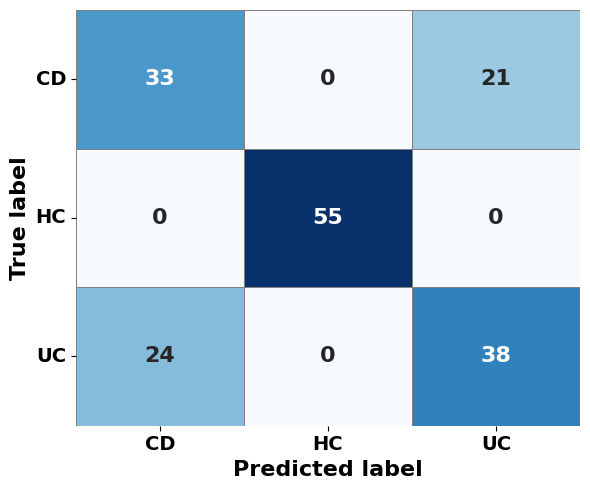

✅ Confusion matrix saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features/Confusion_Matrix.png


In [30]:
# --- Define confusion matrix manually ---
data = [
    [33, 0, 21],   # True CD
    [0, 55, 0],    # True HC
    [24, 0, 38]    # True UC
]
labels = ["CD", "HC", "UC"]

# Put into DataFrame (rows=true, cols=predicted)
cm_df = pd.DataFrame(data, index=labels, columns=labels)

print("Confusion Matrix:")
print(cm_df)

# --- Output directory ---
save_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "Confusion_Matrix.png")

# --- Plot heatmap ---
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm_df, annot=True, fmt="d", cmap="Blues", cbar=False,
    linewidths=.5, linecolor="gray", annot_kws={"size": 16, "weight": "bold"}
)

plt.xlabel("Predicted label", fontsize=16, fontweight="bold")
plt.ylabel("True label", fontsize=16, fontweight="bold")
plt.xticks(fontsize=14, fontweight="bold")
plt.yticks(fontsize=14, fontweight="bold", rotation=0)
#plt.title("Confusion Matrix", fontsize=18, fontweight="bold")

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Confusion matrix saved to: {save_path}")

Reordered Confusion Matrix:
    HC  UC  CD
HC  55   0   0
UC   0  38  24
CD   0  21  33


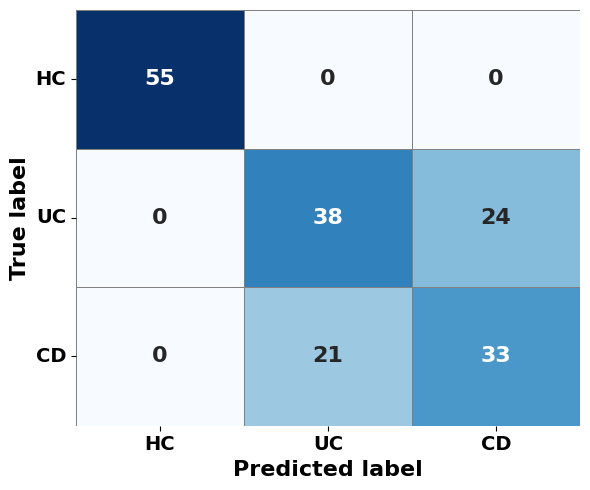

✅ Reordered confusion matrix saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features/Confusion_Matrix_Reordered.png


In [2]:
# --- Define confusion matrix manually in original order ---
data = [
    [33, 0, 21],   # True CD
    [0, 55, 0],    # True HC
    [24, 0, 38]    # True UC
]
original_labels = ["CD", "HC", "UC"]

# Create DataFrame
cm_df = pd.DataFrame(data, index=original_labels, columns=original_labels)

# --- Reorder to HC, UC, CD ---
desired_order = ["HC", "UC", "CD"]
cm_df = cm_df.loc[desired_order, desired_order]

print("Reordered Confusion Matrix:")
print(cm_df)

# --- Output directory ---
save_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "Confusion_Matrix_Reordered.png")

# --- Plot heatmap ---
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    linewidths=.5,
    linecolor="gray",
    annot_kws={"size": 16, "weight": "bold"}
)

plt.xlabel("Predicted label", fontsize=16, fontweight="bold")
plt.ylabel("True label", fontsize=16, fontweight="bold")
plt.xticks(fontsize=14, fontweight="bold")
plt.yticks(fontsize=14, fontweight="bold", rotation=0)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Reordered confusion matrix saved to: {save_path}")

In [34]:
# Confusion matrix (rows = true labels, cols = predicted labels)
#       Pred_CD  Pred_HC  Pred_UC
# CD       33      0       21
# HC        0     55        0
# UC       24      0       38
cm = np.array([[33, 0, 21],
               [0, 55, 0],
               [24, 0, 38]])

# Reconstruct true and predicted labels
y_true = []
y_pred = []

for i in range(cm.shape[0]):       # true class index
    for j in range(cm.shape[1]):   # predicted class index
        y_true += [i] * cm[i, j]
        y_pred += [j] * cm[i, j]

# Class labels in order
labels = ["CD", "HC", "UC"]

# Compute accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=3))

Accuracy: 0.737

Classification Report:
              precision    recall  f1-score   support

          CD      0.579     0.611     0.595        54
          HC      1.000     1.000     1.000        55
          UC      0.644     0.613     0.628        62

    accuracy                          0.737       171
   macro avg      0.741     0.741     0.741       171
weighted avg      0.738     0.737     0.737       171



Binary Confusion Matrix:
     HC  IBD
HC   52    3
IBD  11  105


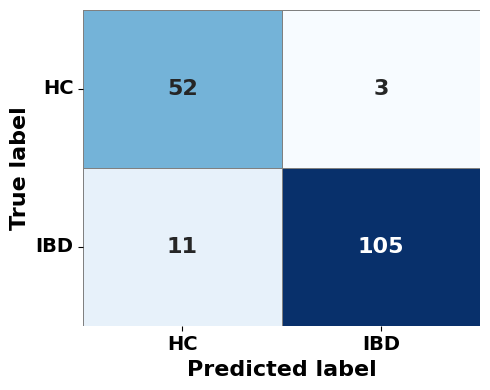

✅ Binary confusion matrix saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features/Confusion_Matrix_Binary.png


In [32]:
# --- Define binary confusion matrix manually ---
data = [
    [52, 3],    # True HC
    [11, 105]   # True IBD
]
labels = ["HC", "IBD"]

# Put into DataFrame (rows=true, cols=predicted)
cm_df = pd.DataFrame(data, index=labels, columns=labels)

print("Binary Confusion Matrix:")
print(cm_df)

# --- Output directory ---
save_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "Confusion_Matrix_Binary.png")

# --- Plot heatmap ---
plt.figure(figsize=(5, 4))
ax = sns.heatmap(
    cm_df, annot=True, fmt="d", cmap="Blues", cbar=False,
    linewidths=.5, linecolor="gray", annot_kws={"size": 16, "weight": "bold"}
)

plt.xlabel("Predicted label", fontsize=16, fontweight="bold")
plt.ylabel("True label", fontsize=16, fontweight="bold")
plt.xticks(fontsize=14, fontweight="bold")
plt.yticks(fontsize=14, fontweight="bold", rotation=0)
#plt.title("Binary Confusion Matrix", fontsize=18, fontweight="bold")

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Binary confusion matrix saved to: {save_path}")

In [33]:
# Confusion matrix you gave:
#       Pred_HC  Pred_IBD
# HC        52         3
# IBD       11       105
cm = np.array([[52, 3],
               [11, 105]])

# Reconstruct true and predicted labels
y_true = []
y_pred = []

# Expand confusion matrix into labels
for i in range(cm.shape[0]):       # true classes
    for j in range(cm.shape[1]):   # predicted classes
        y_true += [i] * cm[i, j]
        y_pred += [j] * cm[i, j]

# Compute accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["HC", "IBD"], digits=3))

Accuracy: 0.918

Classification Report:
              precision    recall  f1-score   support

          HC      0.825     0.945     0.881        55
         IBD      0.972     0.905     0.938       116

    accuracy                          0.918       171
   macro avg      0.899     0.925     0.909       171
weighted avg      0.925     0.918     0.919       171



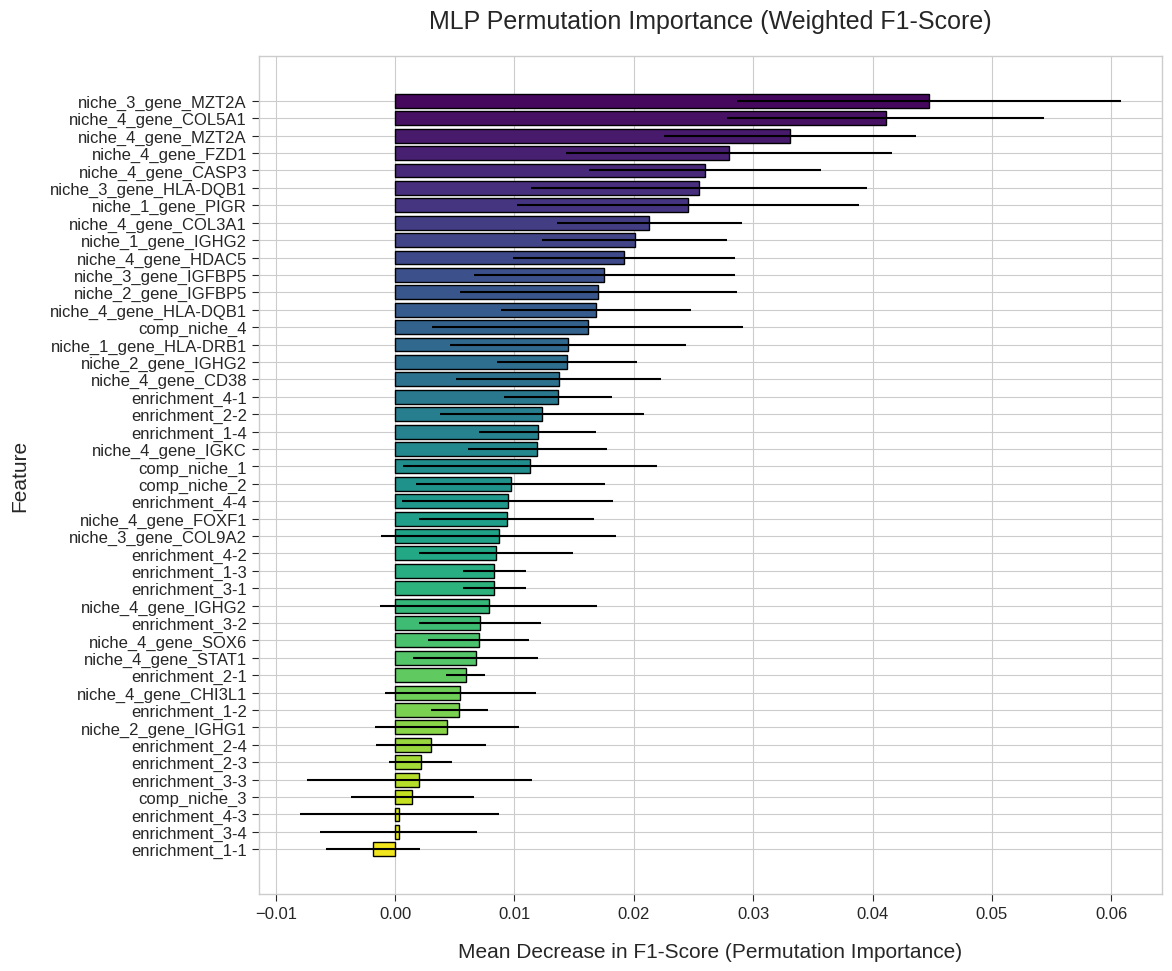

In [47]:
# --- Define the output directory and file paths ---
output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'mlp_permutation_importance.txt')

# --- Redirect print output to the file ---
original_stdout = sys.stdout
sys.stdout = open(output_path, 'w')

try:
    # --- Load the pre-calculated features and labels ---
    print("--- Loading data and best hyperparameters ---")
    feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
    X = pd.read_parquet(os.path.join(feature_input_dir, 'reduced_features_final_15.parquet'))
    y = pd.read_parquet(os.path.join(feature_input_dir, 'targets_y.parquet')).squeeze()
    groups = pd.read_parquet(os.path.join(feature_input_dir, 'groups.parquet')).squeeze()

    # --- Load the best parameters from the previously saved JSON file ---
    best_params_path = os.path.join(output_dir, 'best_params.json')
    if not os.path.exists(best_params_path):
        print("ERROR: best_params.json not found. Please ensure the previous script ran successfully.")
        # Replicate the user's best params for demonstration purposes
        best_params = {
            'mlp__activation': 'relu',
            'mlp__alpha': 0.0010912668217800472,
            'mlp__batch_size': 4,
            'mlp__hidden_layer_sizes': (40, 20, 10, 5)
        }
        print("Using hardcoded best parameters for now.")
    else:
        with open(best_params_path, 'r') as f:
            best_params = json.load(f)

    # --- Rebuild the pipeline with the best hyperparameters ---
    print("Rebuilding the best model pipeline...")
    best_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(
            solver='adam',
            learning_rate='adaptive',
            max_iter=1000,
            random_state=42,
            **{k.replace('mlp__', ''): v for k, v in best_params.items()}
        ))
    ])

    # --- Permutation Importance Analysis with Cross-Validation ---
    print("\n--- Starting Permutation Importance Analysis ---")
    sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
    feature_importances = []

    for i, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups)):
        print(f"--- Processing Fold {i+1}/3 ---")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the best model on the training data for this fold
        best_pipe.fit(X_train, y_train)

        # Calculate permutation importance on the test set
        result = permutation_importance(
            best_pipe,
            X_test,
            y_test,
            n_repeats=10, # Number of times to permute a feature
            random_state=42,
            n_jobs=-1
        )
        feature_importances.append(result)

    # --- Aggregate results and prepare for plotting ---
    print("\n--- Aggregating results and generating output files ---")
    mean_importances = np.mean([r.importances_mean for r in feature_importances], axis=0)
    std_importances = np.mean([r.importances_std for r in feature_importances], axis=0)

    # Create a DataFrame for easy handling and saving
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': mean_importances,
        'importance_std': std_importances
    }).sort_values(by='importance_mean', ascending=False)
    
    # Save the results to a CSV file
    csv_path = os.path.join(output_dir, 'permutation_importance.csv')
    importance_df.to_csv(csv_path, index=False)
    print(f"Permutation importance results saved to: {csv_path}")

    # --- Plotting the Permutation Importance ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create the horizontal bar plot
    ax.barh(
        importance_df['feature'],
        importance_df['importance_mean'],
        xerr=importance_df['importance_std'],
        align='center',
        color=sns.color_palette("viridis", len(importance_df)),
        edgecolor='black'
    )
    
    # Set plot labels and title
    ax.set_xlabel("Mean Decrease in F1-Score (Permutation Importance)", fontsize=15, labelpad=15)
    ax.set_ylabel("Feature", fontsize=15, labelpad=15)
    ax.set_title("MLP Permutation Importance (Weighted F1-Score)", fontsize=18, pad=20)
    
    # Adjust ticks and layout
    ax.tick_params(axis='both', which='major', labelsize=12, length=5)
    ax.invert_yaxis()
    plt.tight_layout()

    # Save the plot with high DPI
    png_path = os.path.join(output_dir, 'permutation_importance.png')
    plt.savefig(png_path, dpi=600, bbox_inches='tight')
    print(f"Permutation importance plot saved to: {png_path}")
    
    print("\n--- Script Finished Successfully ---")

finally:
    # --- Restore original stdout ---
    sys.stdout.close()
    sys.stdout = original_stdout

In [101]:
# --- Define the input/output directory ---
output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features"
# Updated CSV path to point to the 3-class permutation importance data
csv_path = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features/permutation_importance.csv"
png_path = os.path.join(output_dir, '3class_permutation_importance_colored.png')

# --- Check if the CSV file exists ---
if not os.path.exists(csv_path):
    print(f"Error: The file '{csv_path}' was not found. Please ensure the previous script was run successfully.")
else:
    # --- Load the permutation importance data ---
    print("--- Loading permutation importance data ---")
    importance_df = pd.read_csv(csv_path)

    # --- Prepare data for plotting ---
    # Create a column for the absolute importance to sort by magnitude
    importance_df['importance_abs'] = importance_df['importance_mean'].abs()
    
    # Create a color column based on the sign of the original mean importance
    importance_df['color'] = importance_df['importance_mean'].apply(lambda x: 'blue' if x >= 0 else 'red')
    
    # Sort by absolute importance in descending order
    importance_df = importance_df.sort_values(by='importance_abs', ascending=False)
    
    # --- Plotting the Permutation Importance ---
    print("\n--- Generating and saving plot ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(12, 10))
        
    # Create the horizontal bar plot using absolute values for bar height
    # and custom colors
    ax.barh(
        importance_df['feature'],
        importance_df['importance_abs'],
        xerr=importance_df['importance_std'],
        align='center',
        color=importance_df['color'],
        edgecolor='black'
    )
        
    # Set plot labels and title
    ax.set_xlabel("Absolute Mean Decrease in F1-Score (Permutation Importance)", fontsize=15, labelpad=15)
    ax.set_ylabel("Feature", fontsize=15, labelpad=15)
    ax.set_title("MLP Permutation Importance for 3-Class Classification", fontsize=18, pad=20)
        
    # Adjust ticks and layout
    ax.tick_params(axis='both', which='major', labelsize=12, length=5)
    ax.invert_yaxis()
    plt.tight_layout()

    # Save the plot with high DPI
    plt.savefig(png_path, dpi=600, bbox_inches='tight')
    print(f"Permutation importance plot saved to: {png_path}")
        
    print("\n--- Script Finished Successfully ---")


--- Loading permutation importance data ---

--- Generating and saving plot ---
Permutation importance plot saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features/3class_permutation_importance_colored.png

--- Script Finished Successfully ---


--- Loading permutation importance data ---

--- Generating and saving plot ---
Permutation importance plot saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features/3class_permutation_importance_top20.png

--- Script Finished Successfully ---


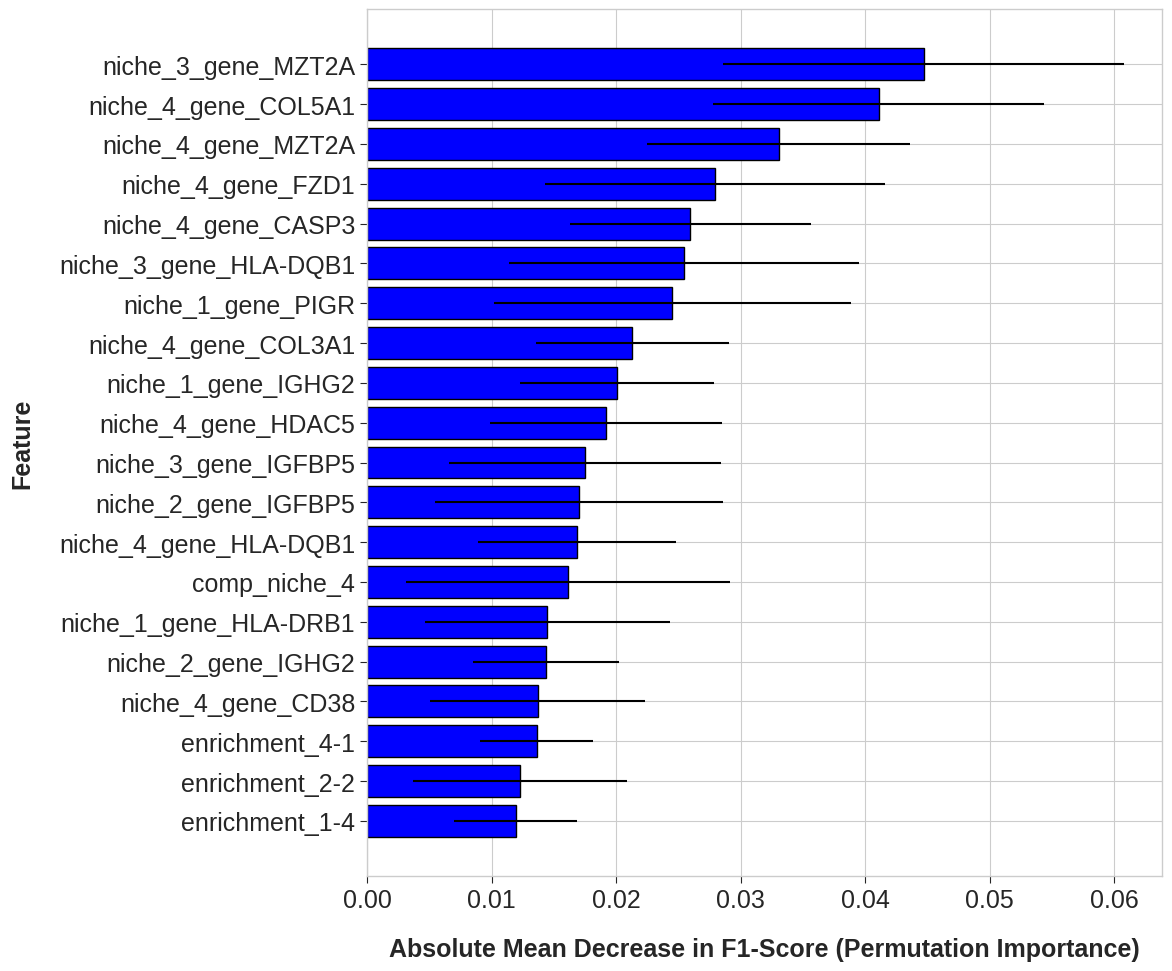

In [10]:
# --- Define the input/output directory ---
output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features"
csv_path = os.path.join(output_dir, "permutation_importance.csv")
png_path = os.path.join(output_dir, "3class_permutation_importance_top20.png")

# --- Check if the CSV file exists ---
if not os.path.exists(csv_path):
    print(f"Error: The file '{csv_path}' was not found. Please ensure the previous script was run successfully.")
else:
    # --- Load the permutation importance data ---
    print("--- Loading permutation importance data ---")
    importance_df = pd.read_csv(csv_path)

    # --- Prepare data for plotting ---
    # Create a column for the absolute importance to sort by magnitude
    importance_df['importance_abs'] = importance_df['importance_mean'].abs()

    # Create a color column based on the sign of the original mean importance
    importance_df['color'] = importance_df['importance_mean'].apply(lambda x: 'blue' if x >= 0 else 'red')

    # Sort by absolute importance in descending order and keep only the top 20
    importance_df = importance_df.sort_values(by='importance_abs', ascending=False).head(20)

    # --- Plotting the top-20 Permutation Importance ---
    print("\n--- Generating and saving plot ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(12, 10))

    # Horizontal bar plot for the top 20 features
    ax.barh(
        importance_df['feature'],
        importance_df['importance_abs'],
        xerr=importance_df['importance_std'],
        align='center',
        color=importance_df['color'],
        edgecolor='black'
    )

    # Set labels and title
    ax.set_xlabel("Absolute Mean Decrease in F1-Score (Permutation Importance)", fontsize=18, labelpad=18,fontweight='bold')
    ax.set_ylabel("Feature", fontsize=18, labelpad=18,fontweight='bold')
    #ax.set_title("Top 20 MLP Permutation Importance for 3-Class Classification", fontsize=18, pad=12)

    # Adjust ticks and layout
    ax.tick_params(axis='both', which='major', labelsize=18, length=5)
    ax.invert_yaxis()  # Highest importance at the top
    plt.tight_layout()

    # Save the plot with high DPI (300)
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    print(f"Permutation importance plot saved to: {png_path}")

    print("\n--- Script Finished Successfully ---")

#### SHAP Analysis

In [95]:
# --- 1. Paths ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
output_dir = os.path.join(feature_input_dir, "MLP_44Features_SHAP")
os.makedirs(output_dir, exist_ok=True)

# --- 2. Load features/labels ---
X = pd.read_parquet(os.path.join(feature_input_dir, 'reduced_features_final_15.parquet'))
y = pd.read_parquet(os.path.join(feature_input_dir, 'targets_y.parquet')).squeeze()

# --- 3. Train Final Model with Best Hyperparameters ---
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        solver='adam', learning_rate='adaptive', max_iter=1000, random_state=42,
        activation='relu',
        alpha=0.0010912668217800472,
        batch_size=4,
        hidden_layer_sizes=(40, 20, 10, 5)
    ))
])
best_pipeline.fit(X, y)

# --- 4. Build SHAP Explainers (per class) ---
print("\n--- Starting SHAP Analysis ---")
X_sample = shap.sample(X, 200, random_state=42)
background = shap.sample(X, 100, random_state=0)
class_names = np.unique(y)

def predict_fn_class(class_idx):
    def f(data):
        data_df = pd.DataFrame(data, columns=X.columns)
        return best_pipeline.predict_proba(data_df)[:, class_idx]
    return f

explainers = []
for i, class_name in enumerate(class_names):
    print(f"Building explainer for class {class_name}...")
    explainer = shap.KernelExplainer(predict_fn_class(i), background)
    explainers.append(explainer)

# --- 5. Global SHAP Analysis ---
shap_values = []
print("\n--- SHAP Debug Info (Global) ---")
print("X_sample shape:", X_sample.shape)

for i, class_name in enumerate(class_names):
    print(f"Explaining class {class_name}...")
    shap_vals = explainers[i].shap_values(X_sample)  # (n_samples, n_features)
    shap_vals = np.array(shap_vals)
    print(f"Class {class_name} → shap_values shape: {shap_vals.shape}")

    # Shape check
    if shap_vals.shape[1] != X_sample.shape[1]:
        raise ValueError(f"Shape mismatch: shap {shap_vals.shape}, X {X_sample.shape}")

    # Plot
    plt.figure()
    shap.summary_plot(shap_vals, X_sample, feature_names=X.columns, show=False)
    plt.title(f"Global SHAP Summary - Class {class_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"shap_global_summary_{class_name}.png"))
    plt.close()

    # Save importances
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    df_importance = pd.DataFrame({
        "feature": X.columns,
        f"mean_abs_shap_{class_name}": mean_abs_shap
    }).sort_values(f"mean_abs_shap_{class_name}", ascending=False)
    df_importance.to_csv(os.path.join(output_dir, f"shap_global_importance_{class_name}.csv"), index=False)
    shap_values.append(shap_vals)

# --- 6. Condition-Specific SHAP Analysis ---
conditions = ["CD", "HC", "UC"]
for cond in conditions:
    X_cond = X[y == cond]
    if len(X_cond) == 0:
        continue
    X_cond_sample = shap.sample(X_cond, min(200, len(X_cond)), random_state=42)

    print(f"\n--- SHAP Debug Info ({cond}) ---")
    print(f"X_cond_sample shape: {X_cond_sample.shape}")

    for i, class_name in enumerate(class_names):
        print(f"Explaining {cond} for class {class_name}...")
        shap_vals_cond = explainers[i].shap_values(X_cond_sample)
        shap_vals_cond = np.array(shap_vals_cond)
        print(f"{cond} | Class {class_name} → shap_values_cond shape: {shap_vals_cond.shape}")

        if shap_vals_cond.shape[1] != X_cond_sample.shape[1]:
            raise ValueError(f"Shape mismatch in {cond}, class {class_name}: {shap_vals_cond.shape} vs {X_cond_sample.shape}")

        # Plot
        plt.figure()
        shap.summary_plot(shap_vals_cond, X_cond_sample, feature_names=X.columns, show=False)
        plt.title(f"SHAP Summary - {cond}, Class {class_name}")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"shap_{cond}_summary_{class_name}.png"))
        plt.close()

        # Save importances
        mean_abs_shap_cond = np.abs(shap_vals_cond).mean(axis=0)
        df_importance_cond = pd.DataFrame({
            "feature": X.columns,
            f"mean_abs_shap_{class_name}_{cond}": mean_abs_shap_cond
        }).sort_values(f"mean_abs_shap_{class_name}_{cond}", ascending=False)
        df_importance_cond.to_csv(os.path.join(output_dir, f"shap_importance_{cond}_{class_name}.csv"), index=False)

print("\n--- SHAP Analysis Complete ---")


--- Starting SHAP Analysis ---
Building explainer for class CD...
Building explainer for class HC...
Building explainer for class UC...

--- SHAP Debug Info (Global) ---
X_sample shape: (171, 44)
Explaining class CD...


  0%|          | 0/171 [00:00<?, ?it/s]

Class CD → shap_values shape: (171, 44)


/scratch/local/10895733/ipykernel_2741495/1688788897.py:58: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_sample, feature_names=X.columns, show=False)


Explaining class HC...


  0%|          | 0/171 [00:00<?, ?it/s]

Class HC → shap_values shape: (171, 44)


/scratch/local/10895733/ipykernel_2741495/1688788897.py:58: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_sample, feature_names=X.columns, show=False)


Explaining class UC...


  0%|          | 0/171 [00:00<?, ?it/s]

Class UC → shap_values shape: (171, 44)


/scratch/local/10895733/ipykernel_2741495/1688788897.py:58: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_sample, feature_names=X.columns, show=False)



--- SHAP Debug Info (CD) ---
X_cond_sample shape: (54, 44)
Explaining CD for class CD...


  0%|          | 0/54 [00:00<?, ?it/s]

CD | Class CD → shap_values_cond shape: (54, 44)


/scratch/local/10895733/ipykernel_2741495/1688788897.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_cond, X_cond_sample, feature_names=X.columns, show=False)


Explaining CD for class HC...


  0%|          | 0/54 [00:00<?, ?it/s]

CD | Class HC → shap_values_cond shape: (54, 44)


/scratch/local/10895733/ipykernel_2741495/1688788897.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_cond, X_cond_sample, feature_names=X.columns, show=False)


Explaining CD for class UC...


  0%|          | 0/54 [00:00<?, ?it/s]

CD | Class UC → shap_values_cond shape: (54, 44)


/scratch/local/10895733/ipykernel_2741495/1688788897.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_cond, X_cond_sample, feature_names=X.columns, show=False)



--- SHAP Debug Info (HC) ---
X_cond_sample shape: (55, 44)
Explaining HC for class CD...


  0%|          | 0/55 [00:00<?, ?it/s]

HC | Class CD → shap_values_cond shape: (55, 44)


/scratch/local/10895733/ipykernel_2741495/1688788897.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_cond, X_cond_sample, feature_names=X.columns, show=False)


Explaining HC for class HC...


  0%|          | 0/55 [00:00<?, ?it/s]

HC | Class HC → shap_values_cond shape: (55, 44)


/scratch/local/10895733/ipykernel_2741495/1688788897.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_cond, X_cond_sample, feature_names=X.columns, show=False)


Explaining HC for class UC...


  0%|          | 0/55 [00:00<?, ?it/s]

HC | Class UC → shap_values_cond shape: (55, 44)


/scratch/local/10895733/ipykernel_2741495/1688788897.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_cond, X_cond_sample, feature_names=X.columns, show=False)



--- SHAP Debug Info (UC) ---
X_cond_sample shape: (62, 44)
Explaining UC for class CD...


  0%|          | 0/62 [00:00<?, ?it/s]

UC | Class CD → shap_values_cond shape: (62, 44)


/scratch/local/10895733/ipykernel_2741495/1688788897.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_cond, X_cond_sample, feature_names=X.columns, show=False)


Explaining UC for class HC...


  0%|          | 0/62 [00:00<?, ?it/s]

UC | Class HC → shap_values_cond shape: (62, 44)


/scratch/local/10895733/ipykernel_2741495/1688788897.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_cond, X_cond_sample, feature_names=X.columns, show=False)


Explaining UC for class UC...


  0%|          | 0/62 [00:00<?, ?it/s]

UC | Class UC → shap_values_cond shape: (62, 44)


/scratch/local/10895733/ipykernel_2741495/1688788897.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_cond, X_cond_sample, feature_names=X.columns, show=False)



--- SHAP Analysis Complete ---


#### Binary Classification - Healthy Controls vs IBD.

In [99]:
# --- Define the output directory ---
output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features/BinaryClassification"
os.makedirs(output_dir, exist_ok=True)
# The code will now print to the console by default.
# The previous print redirection has been removed.

# --- Load the pre-calculated features and labels ---
print("--- Loading data ---")
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
X = pd.read_parquet(os.path.join(feature_input_dir, 'reduced_features_final_15.parquet'))
y = pd.read_parquet(os.path.join(feature_input_dir, 'targets_y.parquet')).squeeze()
groups = pd.read_parquet(os.path.join(feature_input_dir, 'groups.parquet')).squeeze()

# --- 1. Convert to a binary classification problem (HC vs. IBD) ---
print("--- Converting to binary labels (HC vs. IBD) ---")
y_binary = y.replace({'UC': 'IBD', 'CD': 'IBD'})
all_binary_labels = sorted(y_binary.unique())
print(f"New labels: {all_binary_labels}")
print(f"Label counts:\n{y_binary.value_counts()}")

# --- 2. Define the best model based on previous search results ---
print("\n--- Initializing Model with Best Hyperparameters ---")
best_params = {
    'mlp__activation': 'relu',
    'mlp__alpha': 0.0010912668217800472,
    'mlp__batch_size': 4,
    'mlp__hidden_layer_sizes': (40, 20, 10, 5)
}

# Extract MLP specific parameters for the model
best_mlp_params = {k.replace('mlp__', ''): v for k, v in best_params.items()}

# Create the final pipeline with the best hyperparameters
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        solver='adam',
        learning_rate='adaptive',
        max_iter=1000,
        random_state=42,
        **best_mlp_params
    ))
])

# --- 3. Run a final cross-validation with the best model ---
print("\n--- Running 3-Fold Stratified Group Cross-Validation with Best Model ---")
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
all_y_true = []
all_y_pred = []
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for i, (train_idx, test_idx) in enumerate(sgkf.split(X, y_binary, groups)):
    print(f"--- Processing Fold {i+1}/3 ---")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_binary.iloc[train_idx], y_binary.iloc[test_idx]

    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)
    
    fold_accuracies.append(balanced_accuracy_score(y_test, y_pred))
    fold_precisions.append(precision_score(y_test, y_pred, labels=all_binary_labels, average='weighted', zero_division=0))
    fold_recalls.append(recall_score(y_test, y_pred, labels=all_binary_labels, average='weighted', zero_division=0))
    fold_f1_scores.append(f1_score(y_test, y_pred, labels=all_binary_labels, average='weighted', zero_division=0))
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# --- 4. Print Final Performance Report ---
print("\n--- Final Performance Report ---")
print(f"Accuracies for each fold: {np.round(fold_accuracies, 3)}")
print(f"Precisions for each fold: {np.round(fold_precisions, 3)}")
print(f"Recalls for each fold: {np.round(fold_recalls, 3)}")
print(f"F1-Scores for each fold: {np.round(fold_f1_scores, 3)}")
print("\n--- Mean and Standard Deviation ---")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.3f} (± {np.std(fold_accuracies):.3f})")
print(f"Mean Precision: {np.mean(fold_precisions):.3f} (± {np.std(fold_precisions):.3f})")
print(f"Mean Recall: {np.mean(fold_recalls):.3f} (± {np.std(fold_recalls):.3f})")
print(f"Mean F1-Score: {np.mean(fold_f1_scores):.3f} (± {np.std(fold_f1_scores):.3f})")
print("\n--- Overall Classification Report ---")
print(classification_report(all_y_true, all_y_pred, zero_division=0))
print("\n--- Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_true, all_y_pred, labels=all_binary_labels)
cm_df = pd.DataFrame(cm, index=all_binary_labels, columns=all_binary_labels)
print(cm_df)

# Save confusion matrix to a CSV file
cm_df.to_csv(os.path.join(output_dir, 'binary_confusion_matrix.csv'))


# --- 5. Permutation Importance Analysis ---
print("\n--- Starting Permutation Importance Analysis ---")
feature_importances = []

for i, (train_idx, test_idx) in enumerate(sgkf.split(X, y_binary, groups)):
    print(f"--- Processing Fold {i+1}/3 for Permutation Importance ---")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_binary.iloc[train_idx], y_binary.iloc[test_idx]

    # Fit the best model on the training data for this fold
    best_pipeline.fit(X_train, y_train)

    # Calculate permutation importance on the test set
    result = permutation_importance(
        best_pipeline,
        X_test,
        y_test,
        scoring='f1_weighted',
        n_repeats=10, # Number of times to permute a feature
        random_state=42,
        n_jobs=-1
    )
    feature_importances.append(result)

# --- Aggregate results and prepare for plotting ---
print("\n--- Aggregating results and generating output files ---")
mean_importances = np.mean([r.importances_mean for r in feature_importances], axis=0)
std_importances = np.mean([r.importances_std for r in feature_importances], axis=0)

# Create a DataFrame for easy handling and saving
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': mean_importances,
    'importance_std': std_importances
}).sort_values(by='importance_mean', ascending=False)
    
# Save the results to a CSV file
csv_path = os.path.join(output_dir, 'binary_permutation_importance.csv')
importance_df.to_csv(csv_path, index=False)
print(f"Permutation importance results saved to: {csv_path}")

# --- Plotting the Permutation Importance ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12, 10))
    
# Create the horizontal bar plot
ax.barh(
    importance_df['feature'],
    importance_df['importance_mean'],
    xerr=importance_df['importance_std'],
    align='center',
    color=sns.color_palette("viridis", len(importance_df)),
    edgecolor='black'
)
    
# Set plot labels and title
ax.set_xlabel("Mean Decrease in F1-Score (Permutation Importance)", fontsize=15, labelpad=15)
ax.set_ylabel("Feature", fontsize=15, labelpad=15)
ax.set_title("MLP Permutation Importance (Weighted F1-Score) for Binary Classification", fontsize=18, pad=20)
    
# Adjust ticks and layout
ax.tick_params(axis='both', which='major', labelsize=12, length=5)
ax.invert_yaxis()
plt.tight_layout()

# Save the plot with high DPI
png_path = os.path.join(output_dir, 'binary_permutation_importance.png')
plt.savefig(png_path, dpi=600, bbox_inches='tight')
print(f"Permutation importance plot saved to: {png_path}")
    
print("\n--- Script Finished Successfully ---")

--- Loading data ---
--- Converting to binary labels (HC vs. IBD) ---
New labels: ['HC', 'IBD']
Label counts:
Disease_State
IBD    116
HC      55
Name: count, dtype: int64

--- Initializing Model with Best Hyperparameters ---

--- Running 3-Fold Stratified Group Cross-Validation with Best Model ---
--- Processing Fold 1/3 ---
--- Processing Fold 2/3 ---
--- Processing Fold 3/3 ---

--- Final Performance Report ---
Accuracies for each fold: [0.749 1.    1.   ]
Precisions for each fold: [0.78 1.   1.  ]
Recalls for each fold: [0.725 1.    1.   ]
F1-Scores for each fold: [0.735 1.    1.   ]

--- Mean and Standard Deviation ---
Mean Accuracy: 0.916 (± 0.118)
Mean Precision: 0.927 (± 0.104)
Mean Recall: 0.908 (± 0.129)
Mean F1-Score: 0.912 (± 0.125)

--- Overall Classification Report ---
              precision    recall  f1-score   support

          HC       0.83      0.95      0.88        55
         IBD       0.97      0.91      0.94       116

    accuracy                           0.9

In [100]:
# --- Define the input/output directory ---
output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features/BinaryClassification"
csv_path = os.path.join(output_dir, 'binary_permutation_importance.csv')
png_path = os.path.join(output_dir, 'binary_permutation_importance_colored.png')

# --- Check if the CSV file exists ---
if not os.path.exists(csv_path):
    print(f"Error: The file '{csv_path}' was not found. Please ensure the previous script was run successfully.")
else:
    # --- Load the permutation importance data ---
    print("--- Loading permutation importance data ---")
    importance_df = pd.read_csv(csv_path)

    # --- Prepare data for plotting ---
    # Create a column for the absolute importance to sort by magnitude
    importance_df['importance_abs'] = importance_df['importance_mean'].abs()
    
    # Create a color column based on the sign of the original mean importance
    importance_df['color'] = importance_df['importance_mean'].apply(lambda x: 'blue' if x >= 0 else 'red')
    
    # Sort by absolute importance in descending order
    importance_df = importance_df.sort_values(by='importance_abs', ascending=False)
    
    # --- Plotting the Permutation Importance ---
    print("\n--- Generating and saving plot ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(12, 10))
        
    # Create the horizontal bar plot using absolute values for bar height
    # and custom colors
    ax.barh(
        importance_df['feature'],
        importance_df['importance_abs'],
        xerr=importance_df['importance_std'],
        align='center',
        color=importance_df['color'],
        edgecolor='black'
    )
        
    # Set plot labels and title
    ax.set_xlabel("Absolute Mean Decrease in F1-Score (Permutation Importance)", fontsize=15, labelpad=15)
    ax.set_ylabel("Feature", fontsize=15, labelpad=15)
    ax.set_title("MLP Permutation Importance for Binary Classification", fontsize=18, pad=20)
        
    # Adjust ticks and layout
    ax.tick_params(axis='both', which='major', labelsize=12, length=5)
    ax.invert_yaxis()
    plt.tight_layout()

    # Save the plot with high DPI
    plt.savefig(png_path, dpi=600, bbox_inches='tight')
    print(f"Permutation importance plot saved to: {png_path}")
        
    print("\n--- Script Finished Successfully ---")

--- Loading permutation importance data ---

--- Generating and saving plot ---
Permutation importance plot saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features/BinaryClassification/binary_permutation_importance_colored.png

--- Script Finished Successfully ---


--- Loading permutation importance data ---

--- Generating and saving plot ---
Permutation importance plot saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features/BinaryClassification/binary_permutation_importance_top20.png

--- Script Finished Successfully ---


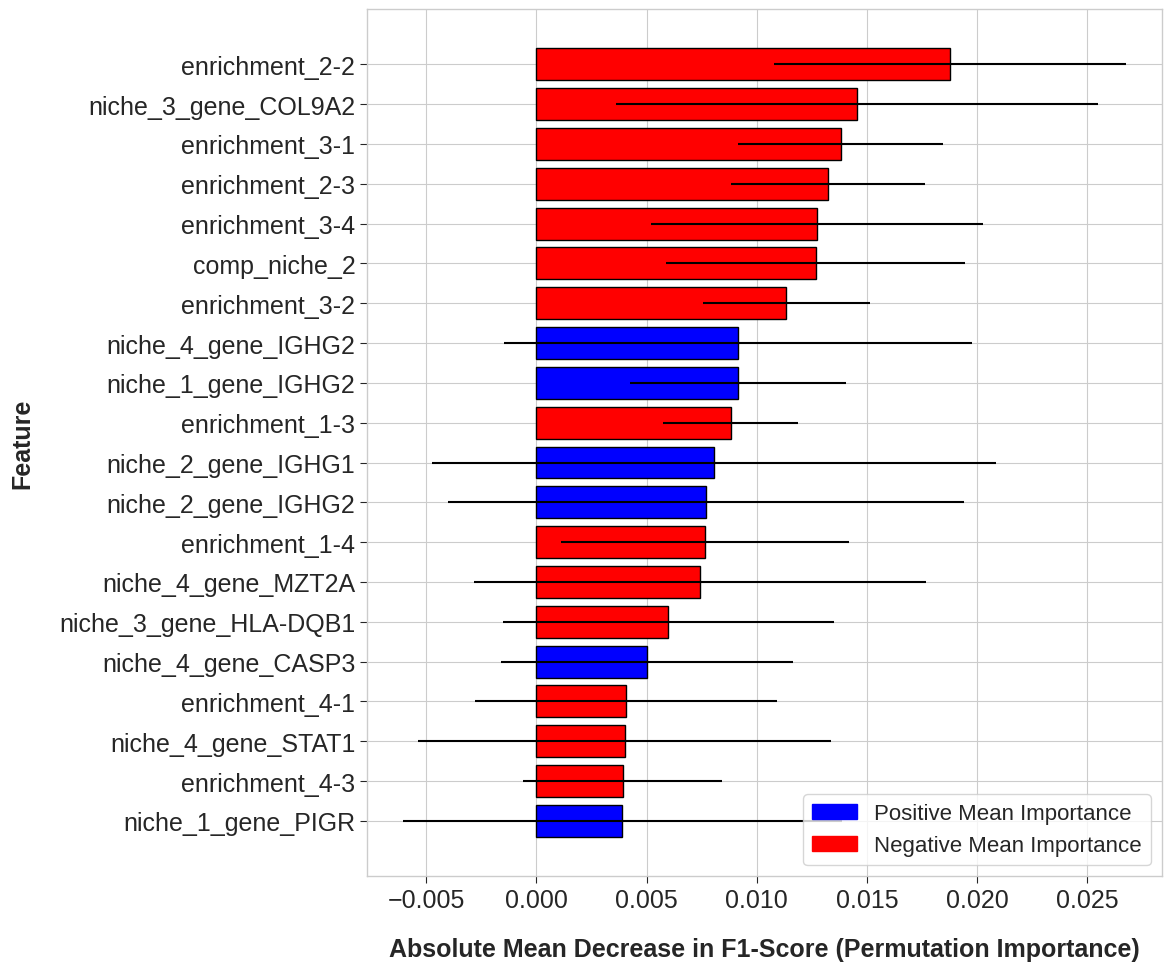

In [9]:
# --- Define the input/output directory ---
output_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis/MLP_44Features/BinaryClassification"
csv_path = os.path.join(output_dir, 'binary_permutation_importance.csv')
png_path = os.path.join(output_dir, 'binary_permutation_importance_top20.png')

# --- Check if the CSV file exists ---
if not os.path.exists(csv_path):
    print(f"Error: The file '{csv_path}' was not found. Please ensure the previous script was run successfully.")
else:
    # --- Load the permutation importance data ---
    print("--- Loading permutation importance data ---")
    importance_df = pd.read_csv(csv_path)

    # --- Prepare data for plotting ---
    # Create a column for the absolute importance to sort by magnitude
    importance_df['importance_abs'] = importance_df['importance_mean'].abs()

    # Assign colors: blue for positive, red for negative
    importance_df['color'] = importance_df['importance_mean'].apply(lambda x: 'blue' if x >= 0 else 'red')

    # Sort by absolute importance and keep only the top 20 features
    importance_df = importance_df.sort_values(by='importance_abs', ascending=False).head(20)

    # --- Plotting the top-20 Permutation Importance ---
    print("\n--- Generating and saving plot ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(12, 10))

    # Horizontal bar plot
    ax.barh(
        importance_df['feature'],
        importance_df['importance_abs'],
        xerr=importance_df['importance_std'],
        align='center',
        color=importance_df['color'],
        edgecolor='black'
    )

    # --- Legend for positive vs negative importance ---
    blue_patch = mpatches.Patch(color='blue', label='Positive Mean Importance')
    red_patch = mpatches.Patch(color='red', label='Negative Mean Importance')
    ax.legend(handles=[blue_patch, red_patch], fontsize=16, loc='lower right', frameon=True)

    # --- Labels and title ---
    ax.set_xlabel("Absolute Mean Decrease in F1-Score (Permutation Importance)", fontsize=18, labelpad=18,fontweight='bold')
    ax.set_ylabel("Feature", fontsize=18, labelpad=18,fontweight='bold')
    #ax.set_title("Top 20 MLP Permutation Importance for Binary Classification", fontsize=18, pad=20)

    # --- Adjust ticks and layout ---
    ax.tick_params(axis='both', which='major', labelsize=18, length=5)
    ax.invert_yaxis()  # Most important feature at the top
    plt.tight_layout()

    # --- Save the plot at 300 dpi ---
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    print(f"Permutation importance plot saved to: {png_path}")

    print("\n--- Script Finished Successfully ---")

#### SHAP Analysis

In [103]:
# --- 1) Paths ---
feature_input_dir = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Post-NMF_Analysis"
output_dir = os.path.join(feature_input_dir, "MLP_44Features/BinaryClassification")
os.makedirs(output_dir, exist_ok=True)

# --- 2) Load data ---
print("--- Loading data ---")
X = pd.read_parquet(os.path.join(feature_input_dir, 'reduced_features_final_15.parquet'))
y = pd.read_parquet(os.path.join(feature_input_dir, 'targets_y.parquet')).squeeze()

# --- 3) Binary labels: HC vs IBD (CD & UC collapsed) ---
print("--- Converting to binary labels (HC vs IBD) ---")
y_binary = y.replace({'UC': 'IBD', 'CD': 'IBD'})
print(y_binary.value_counts())

# --- 4) Train final model with best hyperparams ---
print("\n--- Training Final Model (Binary) ---")
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        solver='adam',
        learning_rate='adaptive',
        max_iter=1000,
        random_state=42,
        activation='relu',
        alpha=0.0010912668217800472,
        batch_size=4,
        hidden_layer_sizes=(40, 20, 10, 5)
    ))
])
best_pipeline.fit(X, y_binary)

# Use the fitted estimator’s class order to stay consistent with predict_proba columns
class_names = list(best_pipeline.named_steps['mlp'].classes_)  # expected ['HC','IBD']
print("Classes (order matches predict_proba columns):", class_names)

# --- 5) Build SHAP explainers (one per binary class) ---
print("\n--- Building SHAP Explainers ---")
X_sample = shap.sample(X, min(200, len(X)), random_state=42)
background = shap.sample(X, min(100, len(X)), random_state=0)

def predict_fn_class(class_idx):
    def f(data):
        data_df = pd.DataFrame(data, columns=X.columns)
        return best_pipeline.predict_proba(data_df)[:, class_idx]  # scalar prob for that class
    return f

explainers = []
for i, cname in enumerate(class_names):
    print(f"Building explainer for class {cname} (col {i}) ...")
    explainers.append(shap.KernelExplainer(predict_fn_class(i), background))

# --- 6) Global SHAP (across ALL samples) ---
print("\n--- Global SHAP Analysis (Binary) ---")
print("X_sample shape:", X_sample.shape)

for i, cname in enumerate(class_names):
    print(f"Explaining global importance for class {cname} ...")
    shap_vals = np.array(explainers[i].shap_values(X_sample))   # (n_samples, n_features)
    print(f"{cname} shap_values shape:", shap_vals.shape)

    if shap_vals.shape[1] != X_sample.shape[1]:
        raise ValueError(f"Shape mismatch: shap {shap_vals.shape} vs X {X_sample.shape}")

    # Beeswarm (pass rng to silence future RNG warning)
    plt.figure()
    shap.summary_plot(shap_vals, X_sample, feature_names=X.columns, show=False, rng=0)
    plt.title(f"Global SHAP Summary - Class {cname}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"shap_global_summary_{cname}.png"))
    plt.close()

    # Numeric importances
    mean_abs = np.abs(shap_vals).mean(axis=0)
    (pd.DataFrame({"feature": X.columns, f"mean_abs_shap_{cname}": mean_abs})
       .sort_values(f"mean_abs_shap_{cname}", ascending=False)
       .to_csv(os.path.join(output_dir, f"shap_global_importance_{cname}.csv"), index=False))

# --- 7) Condition-specific SHAP (subset by BINARY labels only: HC or IBD) ---
conditions = ["HC", "IBD"]  # only two subsets in binary world
for cond in conditions:
    X_cond = X[y_binary == cond]
    if len(X_cond) == 0:
        continue
    Xc = shap.sample(X_cond, min(200, len(X_cond)), random_state=42)
    print(f"\n--- SHAP Analysis for condition subset = {cond} ---")
    print("X_cond_sample shape:", Xc.shape)

    for i, cname in enumerate(class_names):
        print(f"Explaining subset {cond} for class {cname} ...")
        shap_vals_c = np.array(explainers[i].shap_values(Xc))
        print(f"{cond} | class {cname} shap_values shape:", shap_vals_c.shape)

        if shap_vals_c.shape[1] != Xc.shape[1]:
            raise ValueError(f"Shape mismatch in {cond}, class {cname}: {shap_vals_c.shape} vs {Xc.shape}")

        plt.figure()
        shap.summary_plot(shap_vals_c, Xc, feature_names=X.columns, show=False, rng=0)
        plt.title(f"SHAP Summary - Subset {cond}, Class {cname}")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"shap_{cond}_summary_{cname}.png"))
        plt.close()

        mean_abs_c = np.abs(shap_vals_c).mean(axis=0)
        (pd.DataFrame({"feature": X.columns, f"mean_abs_shap_{cname}_{cond}": mean_abs_c})
           .sort_values(f"mean_abs_shap_{cname}_{cond}", ascending=False)
           .to_csv(os.path.join(output_dir, f"shap_importance_{cond}_{cname}.csv"), index=False))

print("\n--- Binary SHAP Analysis Complete ---")

--- Loading data ---
--- Converting to binary labels (HC vs IBD) ---
Disease_State
IBD    116
HC      55
Name: count, dtype: int64

--- Training Final Model (Binary) ---
Classes (order matches predict_proba columns): ['HC', 'IBD']

--- Building SHAP Explainers ---
Building explainer for class HC (col 0) ...
Building explainer for class IBD (col 1) ...

--- Global SHAP Analysis (Binary) ---
X_sample shape: (171, 44)
Explaining global importance for class HC ...


  0%|          | 0/171 [00:00<?, ?it/s]

HC shap_values shape: (171, 44)
Explaining global importance for class IBD ...


  0%|          | 0/171 [00:00<?, ?it/s]

IBD shap_values shape: (171, 44)

--- SHAP Analysis for condition subset = HC ---
X_cond_sample shape: (55, 44)
Explaining subset HC for class HC ...


  0%|          | 0/55 [00:00<?, ?it/s]

HC | class HC shap_values shape: (55, 44)
Explaining subset HC for class IBD ...


  0%|          | 0/55 [00:00<?, ?it/s]

HC | class IBD shap_values shape: (55, 44)

--- SHAP Analysis for condition subset = IBD ---
X_cond_sample shape: (116, 44)
Explaining subset IBD for class HC ...


  0%|          | 0/116 [00:00<?, ?it/s]

IBD | class HC shap_values shape: (116, 44)
Explaining subset IBD for class IBD ...


  0%|          | 0/116 [00:00<?, ?it/s]

IBD | class IBD shap_values shape: (116, 44)

--- Binary SHAP Analysis Complete ---
